# Previsão de Falha

## Introdução

Esse exercício propõem o desenvolvimento de um modelo simplificado de classificação para manutenção preditiva, considerando as características temporais inerentes aos dados de manutenção preditiva. A metodologia combina a metodologia tradicional de modelos de machine learning nesse contexto (validação temporal) com calibração conforme.

É realizada uma análise exploratória, buscando identificar a distribuição dos atributos e relações entre seus dados históricos e eventos pré-falha, que auxiliem a identificar possíveis sinais que contribuam para a seleção e criação de features que assessorem o modelo a separar as classes falha e não falha.


In [1]:
%pip install lifelines
%pip install optuna
%pip install boruta
%pip install pycaret
%pip install shap


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Desenvolvimento

#### Bibliotecas

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from typing import List, Tuple, Dict, Optional, Iterable, Sequence, Literal
from functools import partial

from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    roc_auc_score, log_loss, cohen_kappa_score, matthews_corrcoef,
    average_precision_score, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, roc_curve, auc
)
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import (
    chi2, SelectKBest, SelectPercentile, mutual_info_classif
)
from sklearn.ensemble import (
    ExtraTreesClassifier, RandomForestClassifier, IsolationForest, GradientBoostingClassifier
)

from sklearn.inspection import PartialDependenceDisplay

from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import optuna

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import concordance_index

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from boruta import BorutaPy

from scipy.signal import find_peaks
import scipy.stats as stats

import warnings
from concurrent.futures import ThreadPoolExecutor
import multiprocessing as mp
import zipfile

#### Funções auxiliares

In [3]:
def optimal_number_of_bins(x: pd.Series) -> int:
    """estima o número de bins usando a regra de Freedman-Diaconis"""
    if x.isnull().all() or len(x) < 2:
        return 10 # retorna um valor padrão se a série estiver vazia

    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1

    # prevenção de divisão por zero se IQR for 0
    if IQR == 0:
        # usa a regra de Sturges como alternativa
        return int(1 + np.log2(len(x)))

    h = 2 * IQR * len(x)**(-1/3)

    # prevenção de divisão por zero se a largura do bin (h) for 0
    if h == 0:
        return int(np.sqrt(len(x))) # usa a raiz quadrada como alternativa

    num_bins = (x.max() - x.min()) / h

    return max(1, int(num_bins))


def diagnostic_plots(dataframe: pd.DataFrame, variable: str):

    n_bins = optimal_number_of_bins(dataframe[variable])

    plt.figure(figsize=(18, 5))
    plt.suptitle(f'Gráficos de Diagnóstico para "{variable}"', fontsize=16)

    # histograma com KDE
    plt.subplot(1, 3, 1)
    sns.histplot(data=dataframe, x=variable, kde=True, stat="density", bins=n_bins, color='teal')
    plt.title('Histograma e Curva de Densidade (KDE)')

    # Q-Q Plot (gráfico de quantis)
    plt.subplot(1, 3, 2)
    stats.probplot(dataframe[variable], dist='norm', plot=plt)
    plt.ylabel('Quantis da Variável')
    plt.xlabel('Quantis Teóricos (Normal)')
    plt.title('Q-Q Plot vs. Distribuição Normal')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=dataframe[variable], color='skyblue')
    plt.title('Boxplot para Detecção de Outliers')

    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.show()


A regra de Freedman-Diaconis será adotada para determinar o número de caixas (bins).
Ela é dada pela fórmula: $$h = \frac{2(IQR(X))}{n^{1/3}}$$, onde 
$IQR(X)$ é o intervalo interquartil do conjunto de dados $𝑋$.

Assim, o número de caixas (bins) é calculado por: $$\frac{\max(X) - \min(X)}{h}$$ onde $n$ é o número de observações.

In [62]:
def combined_metric_with_penalties(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    w: dict,
    threshold: float = 0.5,
    rec_thresh: float = 0.20,
    rec_penalty_power: float = 1.2,
    mcc_alpha: float = 2.0
) -> float:

    y_pred = (y_prob >= threshold).astype(int)

    rec = recall_score(y_true, y_pred, zero_division=0)
    mcc = matthews_corrcoef(y_true, y_pred)
    kap = cohen_kappa_score(y_true, y_pred)
    kap_n = (kap + 1.0) / 2.0
    auprc = average_precision_score(y_true, y_prob)

    # penalização de recall baixo
    rec_p = asymmetric_recall_penalty(rec, threshold=rec_thresh, penalty_factor=rec_penalty_power)
    
    # transformação do MCC
    mcc_nl = logistic_mcc_transform(mcc, alpha=mcc_alpha)

    return (
    w["recall"] * rec_p +
    w["mcc"]    * mcc_nl +
    w["auprc"]  * auprc * 2 +
    w["kappa"]  * kap_n * 3
    )


def asymmetric_recall_penalty(recall: float, threshold: float = 0.20, penalty_factor: float = 1.2) -> float:
    r = float(recall)
    if r < threshold:
        penalty = (r / threshold) ** penalty_factor
        return r * penalty
    return r


def logistic_mcc_transform(mcc: float, alpha: float = 2.0) -> float:
    mcc_norm = np.clip((mcc + 1.0) / 2.0, 0.0, 1.0)
    return float(1.0 / (1.0 + np.exp(-alpha * (mcc_norm - 0.5))))




##### Métrica customizada para classificação binária em dados extremamente desbalanceados

$$\text{Métrica Final} =  w_{\text{recall}} \cdot \text{Recall}_{\text{penalizado}} + w_{\text{mcc}} \cdot \text{MCC}_{\text{transformado}} + 2 \cdot w_{\text{auprc}} \cdot \text{AUPRC} + 3 \cdot w_{\text{kappa}} \cdot \text{Kappa}_{\text{normalizado}} $$

Componentes:

- Recall com penalização assimétrica

$$\text{Recall}_{\text{penalizado}} = \begin{cases} 
\text{recall} \times \left(\frac{\text{recall}}{\text{rec\_thresh}}\right)^{\text{penalty\_power}} & \text{se recall} < \text{rec\_thresh} \\
\text{recall} & \text{caso contrário}
\end{cases}$$

Objetivo: Aplicar penalização severa para modelos com recall abaixo do threshold mínimo aceitável.

- MCC com transformação logística

Normalização do MCC:
$$\text{MCC}_{\text{normalizado}} = \frac{\text{MCC} + 1}{2}$$

Transformação logística:
$$\text{MCC}_{\text{transformado}} = \frac{1}{1 + e^{-\alpha \cdot (\text{MCC}_{\text{normalizado}} - 0.5)}}$$

Objetivo: Suavizar o MCC para melhor otimização, mantendo sua robustez para dados desbalanceados.

- Kappa Normalizado

$$\text{Kappa}_{\text{normalizado}} = \frac{\text{Kappa} + 1}{2}$$

Objetivo: Normalizar Cohen's Kappa para escala [0,1], medindo concordância ajustada pelo acaso.

- AUPRC (Area Under Precision-Recall Curve)

Utilizada diretamente sem transformação, por ser mais informativa que ROC-AUC para classes desbalanceadas.


In [5]:
def evaluate_on_test(
    predictor_or_proba,                 
    test_df: pd.DataFrame,
    target_col: str = "failure",
    weights: dict = None,
    threshold: float = 0.5,
    rec_thresh: float = 0.20,
    rec_penalty_power: float = 1.2,
    mcc_alpha: float = 2.0,
    plot_cm: bool = True
) -> dict:
    if weights is None:
        weights = {"recall": 0.35, "mcc": 0.35, "auprc": 0.20, "kappa": 0.10}

    if hasattr(predictor_or_proba, "predict_proba"):
        y_prob = predictor_or_proba.predict_proba(test_df)[:, 1]
    else:

        arr = predictor_or_proba
        if isinstance(arr, pd.DataFrame):
            if arr.shape[1] != 1:
                raise ValueError("Se inputar um dataFrame, utilize apenas 1 coluna de probabilidades")
            arr = arr.iloc[:, 0]
        if isinstance(arr, pd.Series):
            arr = arr.reindex(test_df.index).values
        y_prob = np.asarray(arr, dtype=float).reshape(-1)
        if len(y_prob) != len(test_df):
            raise ValueError("y_prob deve ter o mesmo comprimento de teste")

    y_true = test_df[target_col].astype(int).values
    y_pred = (y_prob >= threshold).astype(int)

    metrics = {}
    metrics["accuracy"]  = accuracy_score(y_true, y_pred)
    metrics["recall"]    = recall_score(y_true, y_pred, zero_division=0)
    metrics["precision"] = precision_score(y_true, y_pred, zero_division=0)
    metrics["f1"]        = f1_score(y_true, y_pred, zero_division=0)

    try:
        metrics["auc"] = roc_auc_score(y_true, y_prob)
    except Exception:
        metrics["auc"] = np.nan

    eps = 1e-15
    metrics["logloss"] = log_loss(y_true, np.clip(y_prob, eps, 1 - eps))
    metrics["kappa"]   = cohen_kappa_score(y_true, y_pred)
    metrics["mcc"]     = matthews_corrcoef(y_true, y_pred)
    metrics["auprc"]   = average_precision_score(y_true, y_prob)

    metrics["custom_score"] = combined_metric_with_penalties(
        y_true=y_true, y_prob=y_prob, w=weights, threshold=threshold,
        rec_thresh=rec_thresh, rec_penalty_power=rec_penalty_power,
        mcc_alpha=mcc_alpha
    )

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    metrics["confusion_matrix"] = cm

    if plot_cm:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        fig, ax = plt.subplots(figsize=(5, 4))
        disp.plot(ax=ax, values_format='d', cmap='Blues', colorbar=False)
        ax.set_title("Matriz de Confusão - Teste")
        plt.tight_layout()
        plt.show()

    return metrics

#### Lendo os dados

In [6]:
zip_file_name = 'Data Science Challenge pt.zip'
excel_file_path_in_zip = 'Data Science Challenge pt/full_devices.csv'

with zipfile.ZipFile(zip_file_name, 'r') as z:
    with z.open(excel_file_path_in_zip) as f:
        try:
            df = pd.read_csv(f, encoding='latin1')
        except UnicodeDecodeError:
            f.seek(0)
            df = pd.read_csv(f, encoding='cp1252')
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        124494 non-null  object
 1   device      124494 non-null  object
 2   failure     124494 non-null  int64 
 3   attribute1  124494 non-null  int64 
 4   attribute2  124494 non-null  int64 
 5   attribute3  124494 non-null  int64 
 6   attribute4  124494 non-null  int64 
 7   attribute5  124494 non-null  int64 
 8   attribute6  124494 non-null  int64 
 9   attribute7  124494 non-null  int64 
 10  attribute8  124494 non-null  int64 
 11  attribute9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [8]:
df['date'] = pd.to_datetime(df['date'])
df['date'].min(), df['date'].max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2015-11-02 00:00:00'))

#### Análise Exploratória

In [9]:
# análise da variável alvo 'failure'
print("Distribuição da variável 'failure':")
print(df['failure'].value_counts(normalize=True))
print("\nContagem da variável 'failure':")
print(df['failure'].value_counts())

Distribuição da variável 'failure':
failure
0    0.999149
1    0.000851
Name: proportion, dtype: float64

Contagem da variável 'failure':
failure
0    124388
1       106
Name: count, dtype: int64


In [10]:
print("Ranking de dispositivos por número de falhas:")
df[df['failure'] == 1]['device'].value_counts().head(10)

Ranking de dispositivos por número de falhas:


device
S1F0RRB1    1
Z1F0B4XZ    1
W1F0Z3KR    1
S1F0QF3R    1
S1F0GSD9    1
W1F0WBTM    1
S1F0L0DW    1
W1F0X5GW    1
S1F0PJJW    1
W1F0FKWW    1
Name: count, dtype: int64

Não existem falhas recorrentes nos dispositivos, nenhum dispositivo que falhou possui mais de uma falha. O desafio, ao avaliar um modelo no conjunto de teste, é prever a primeira e única falha de qualquer dispositivo. O problema é de a "primeira falha".

In [11]:
print(f"Número de dispositivos sem falha: {(df.groupby('device')['failure'].sum() == 0).sum()}")

Número de dispositivos sem falha: 1063


- Visualizações

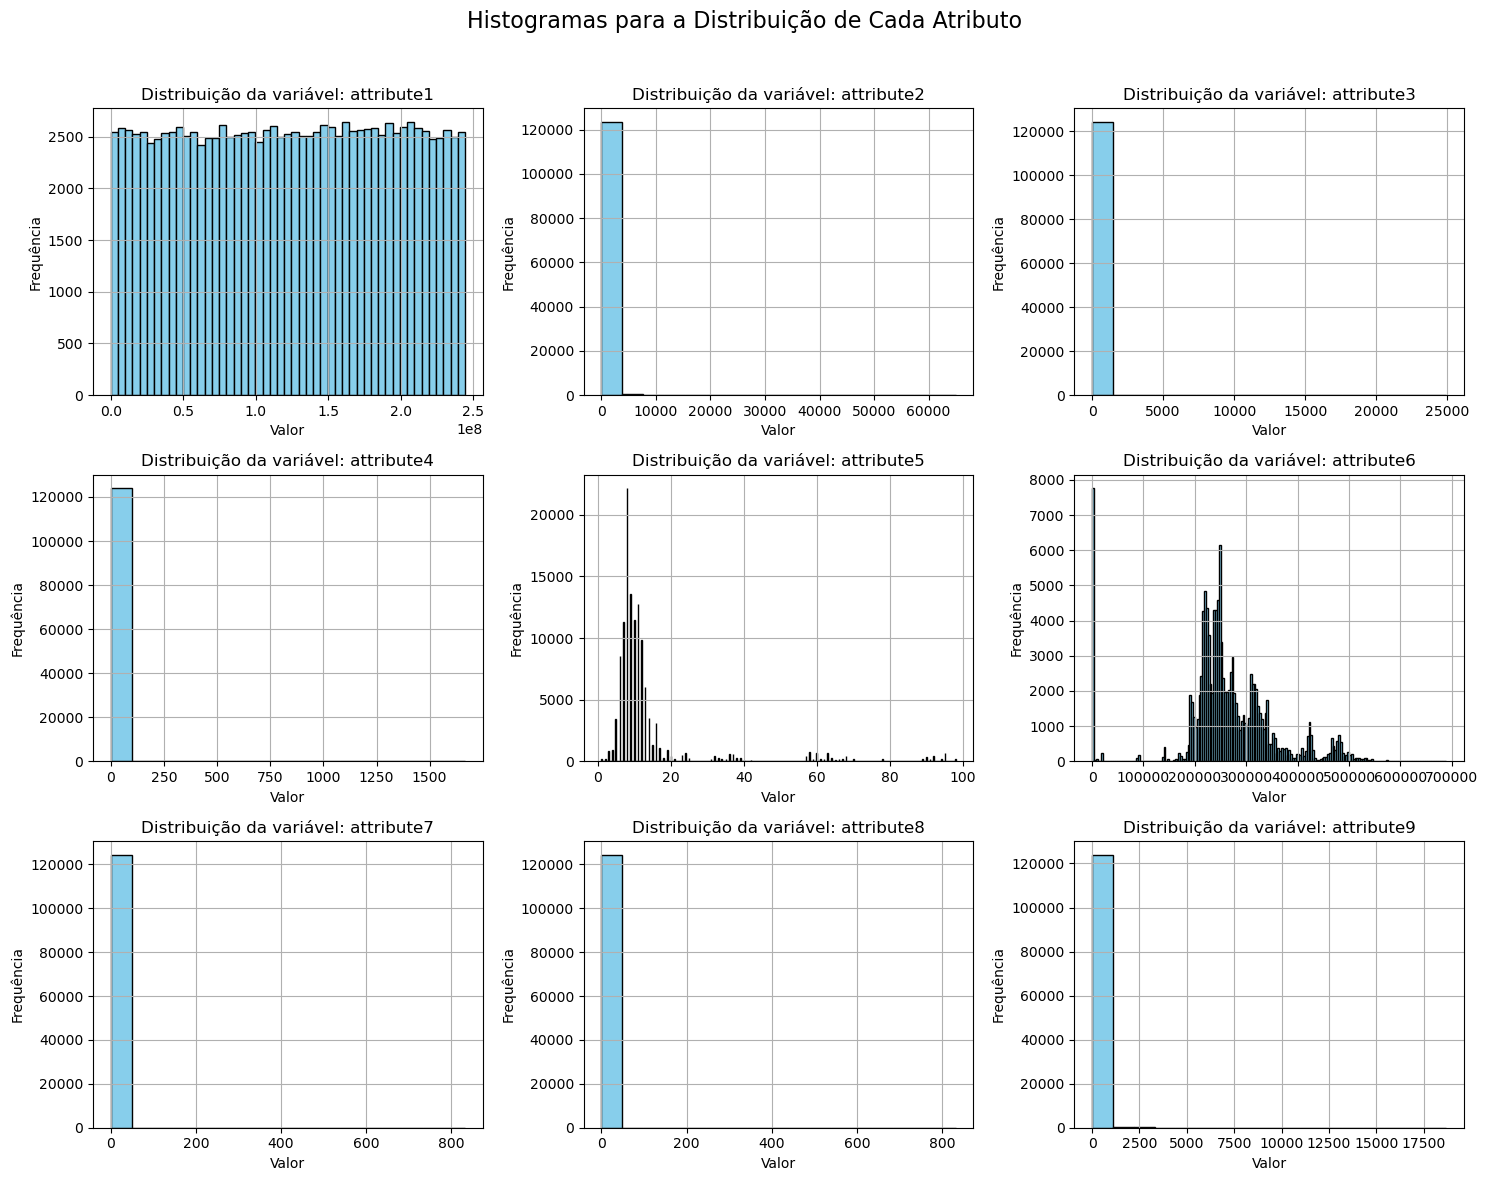

In [12]:
attribute_cols = [f'attribute{i}' for i in range(1, 10)]

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
for ax, col in zip(axes.flatten(), attribute_cols):

    bins = optimal_number_of_bins(df[col])
    df[col].hist(ax=ax, bins=bins, color='skyblue', edgecolor='black')

    ax.set_title(f'Distribuição da variável: {col}')
    ax.set_xlabel('Valor')
    ax.set_ylabel('Frequência')

plt.suptitle('Histogramas para a Distribuição de Cada Atributo', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Gerando gráficos para a coluna: attribute1


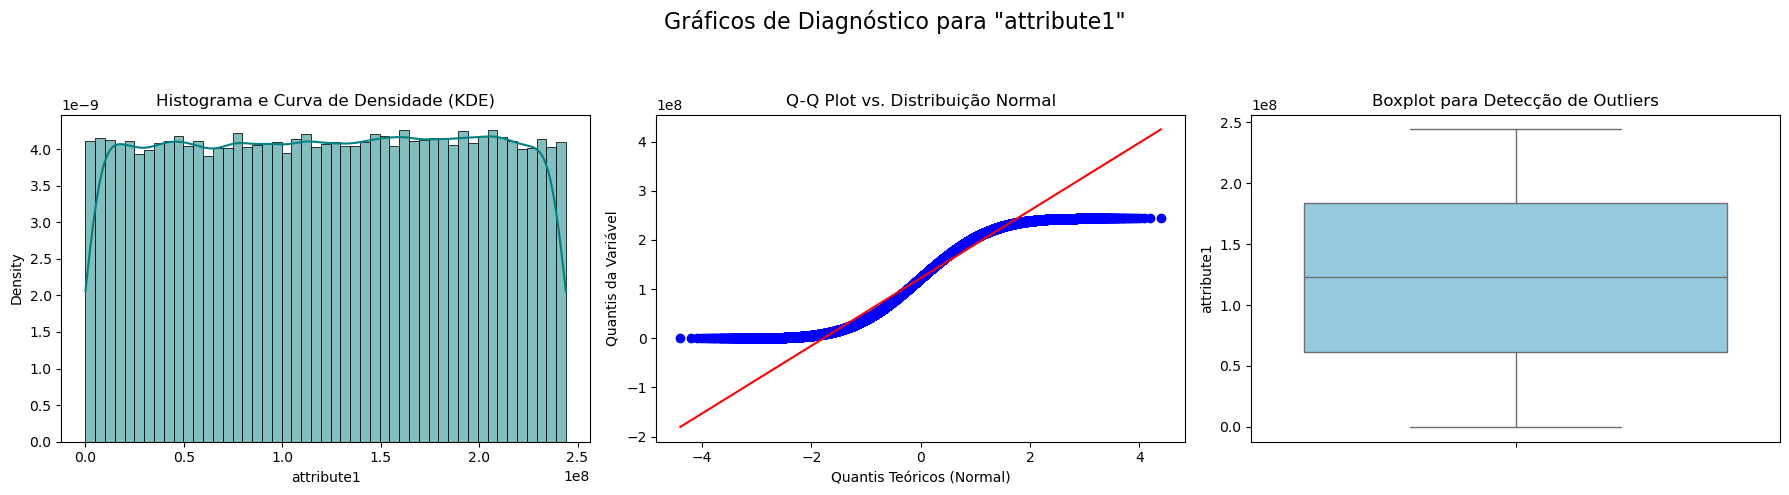

Gerando gráficos para a coluna: attribute2


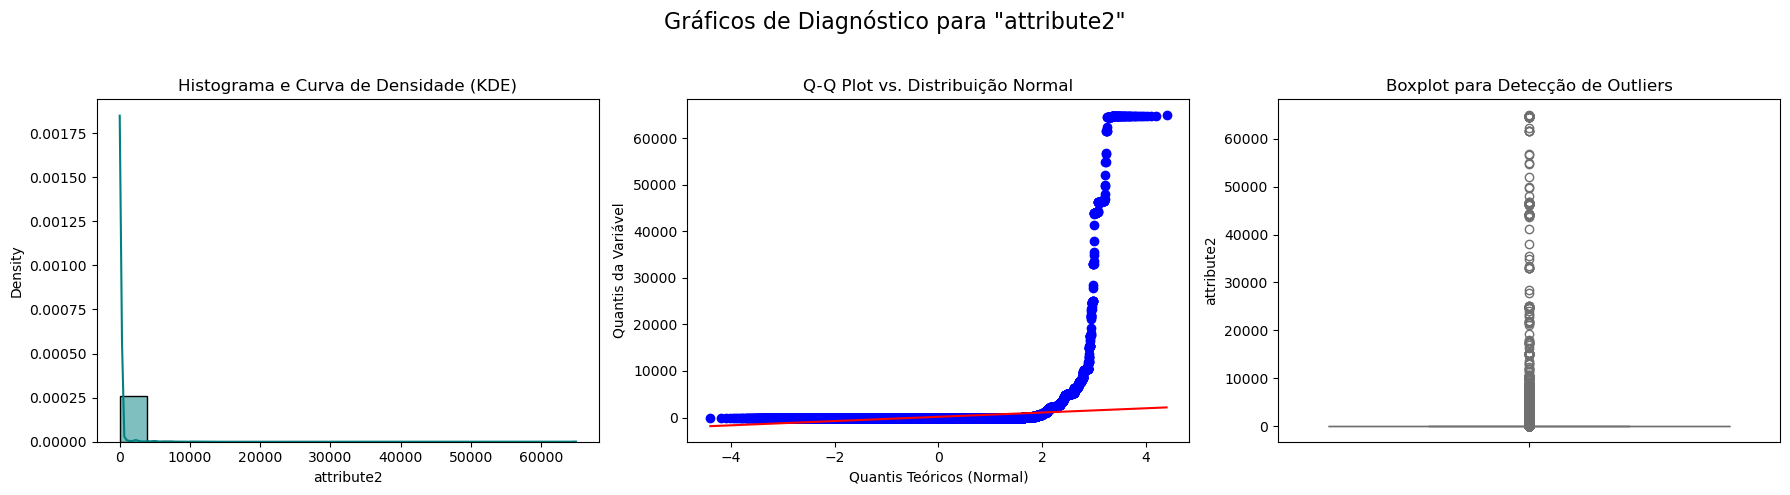

Gerando gráficos para a coluna: attribute3


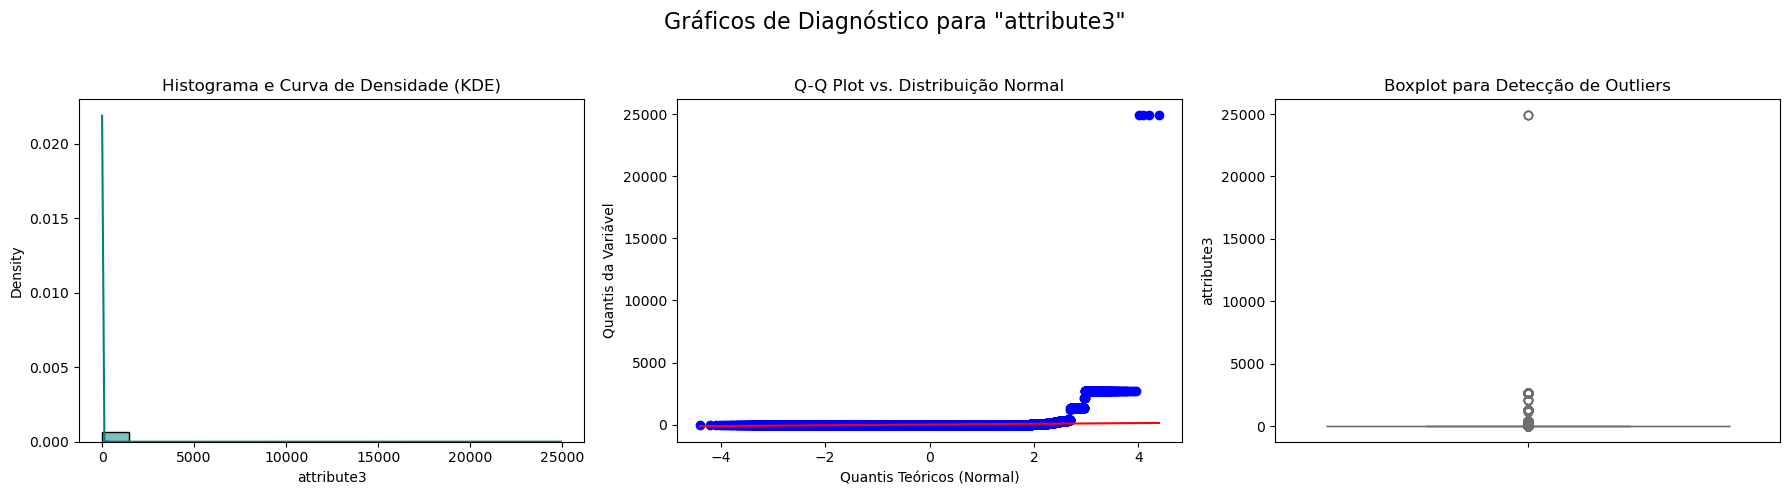

Gerando gráficos para a coluna: attribute4


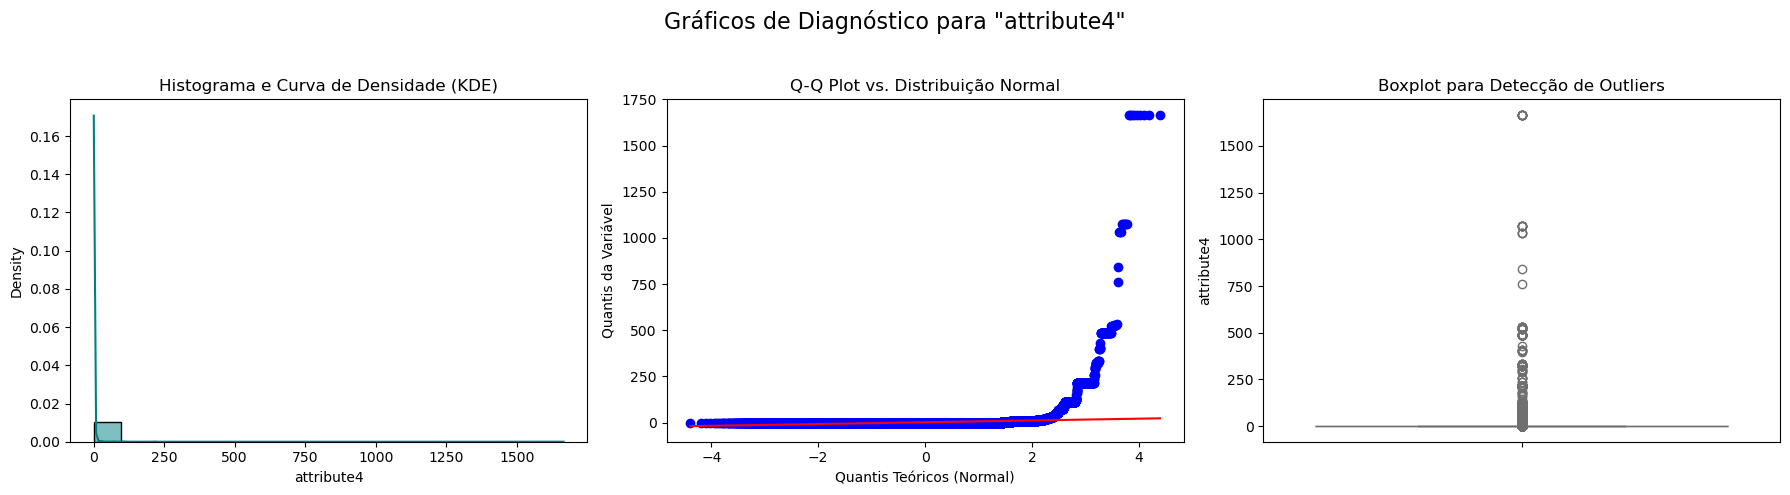

Gerando gráficos para a coluna: attribute5


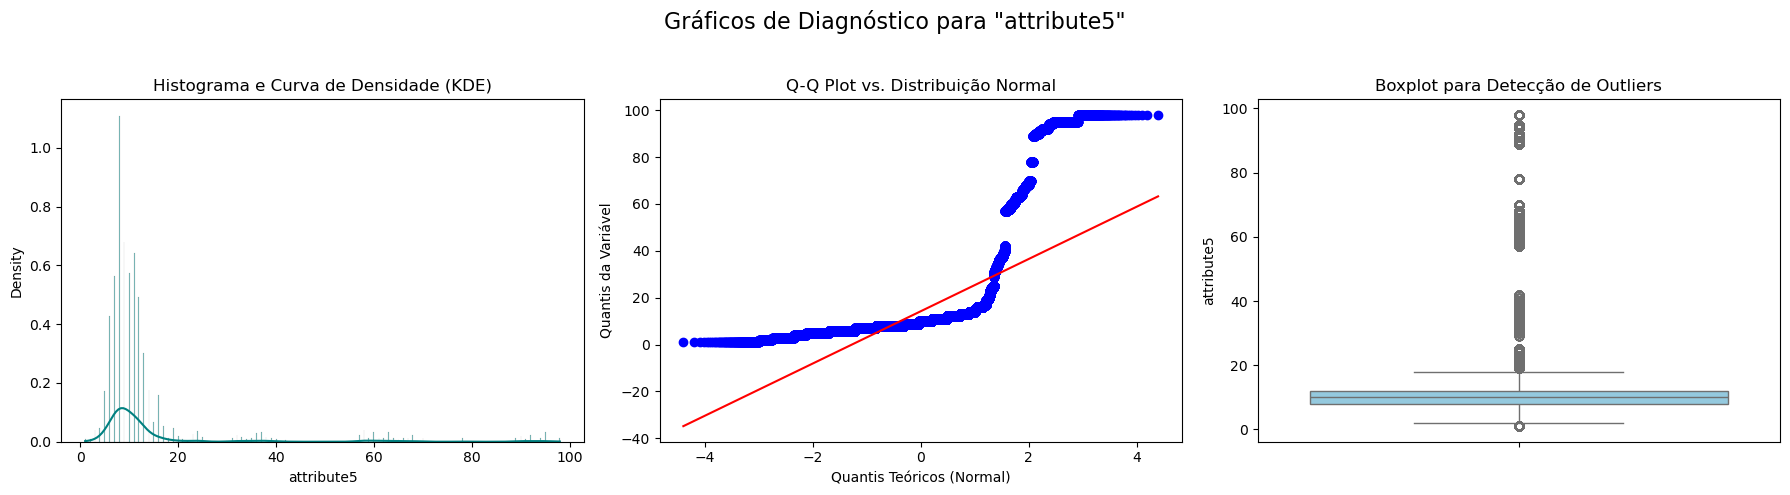

Gerando gráficos para a coluna: attribute6


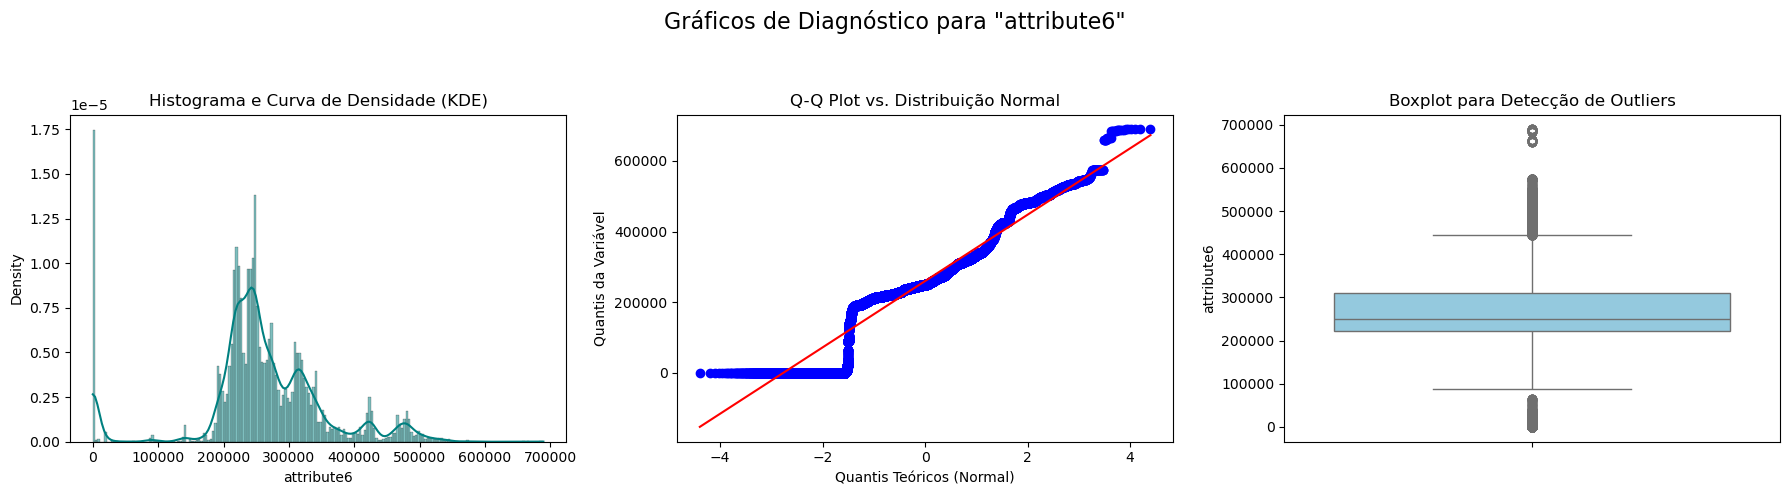

Gerando gráficos para a coluna: attribute7


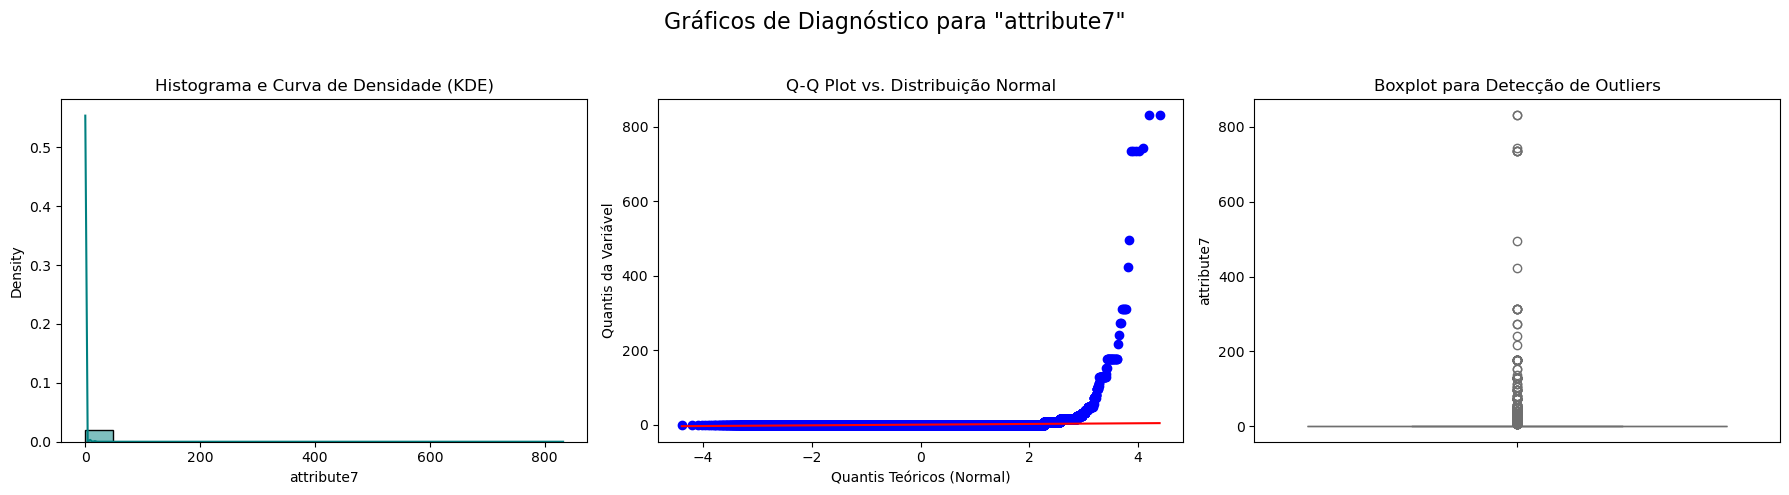

Gerando gráficos para a coluna: attribute8


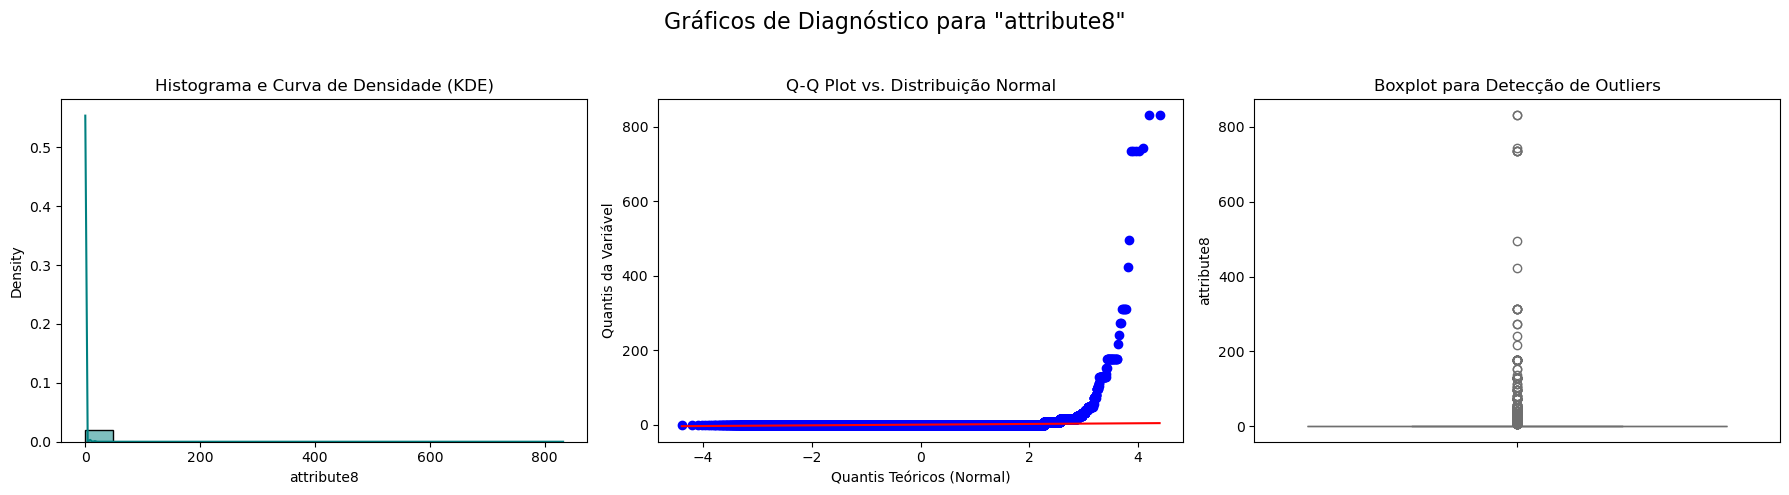

Gerando gráficos para a coluna: attribute9


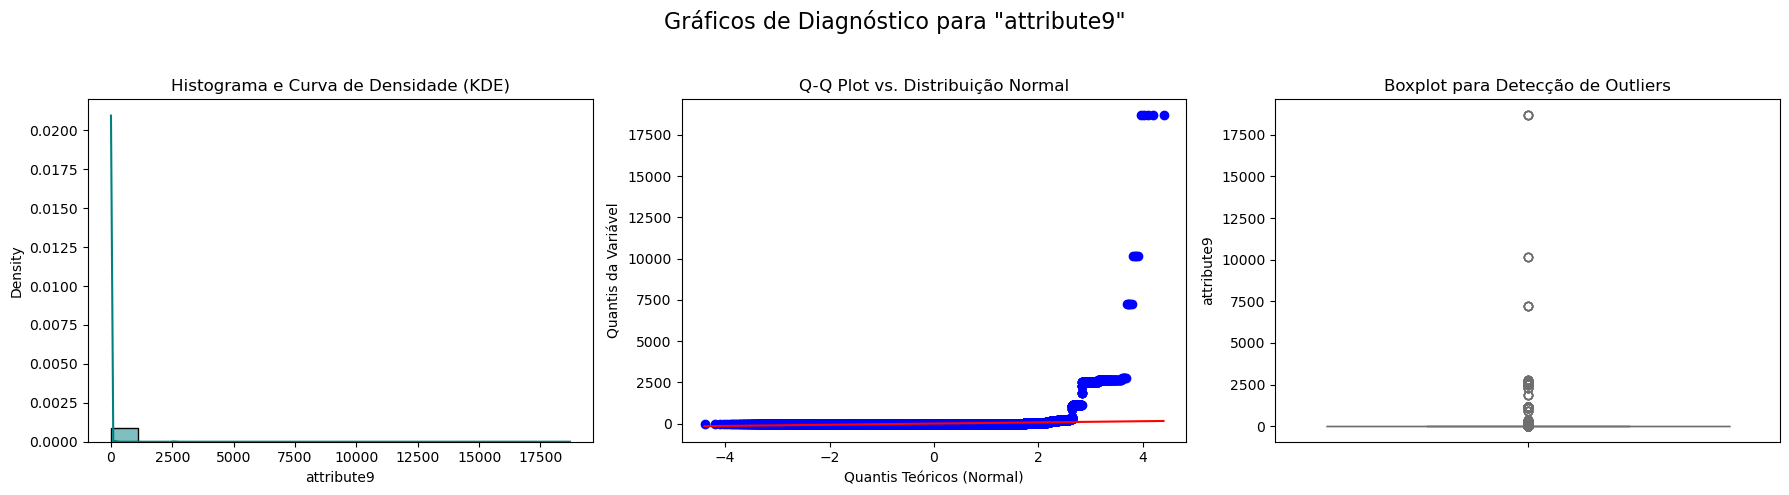

In [13]:
attribute_cols = [f'attribute{i}' for i in range(1, 10)]

for col in attribute_cols:
    print(f"Gerando gráficos para a coluna: {col}")
    diagnostic_plots(df, col)

Text(0.5, 1.0, 'Boxplot dos Atributos para Detectar Outliers')

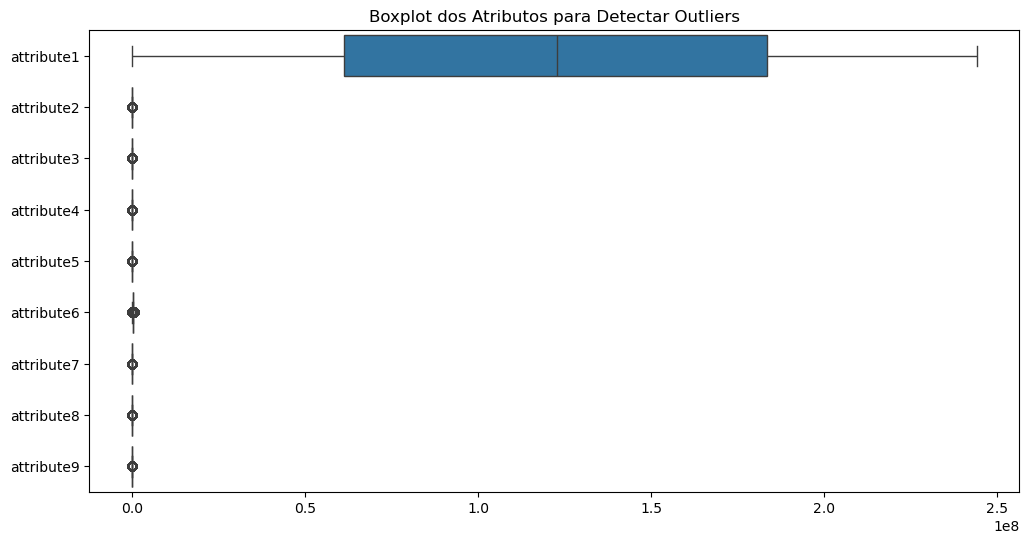

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[attribute_cols], orient='h')
plt.title('Boxplot dos Atributos para Detectar Outliers')

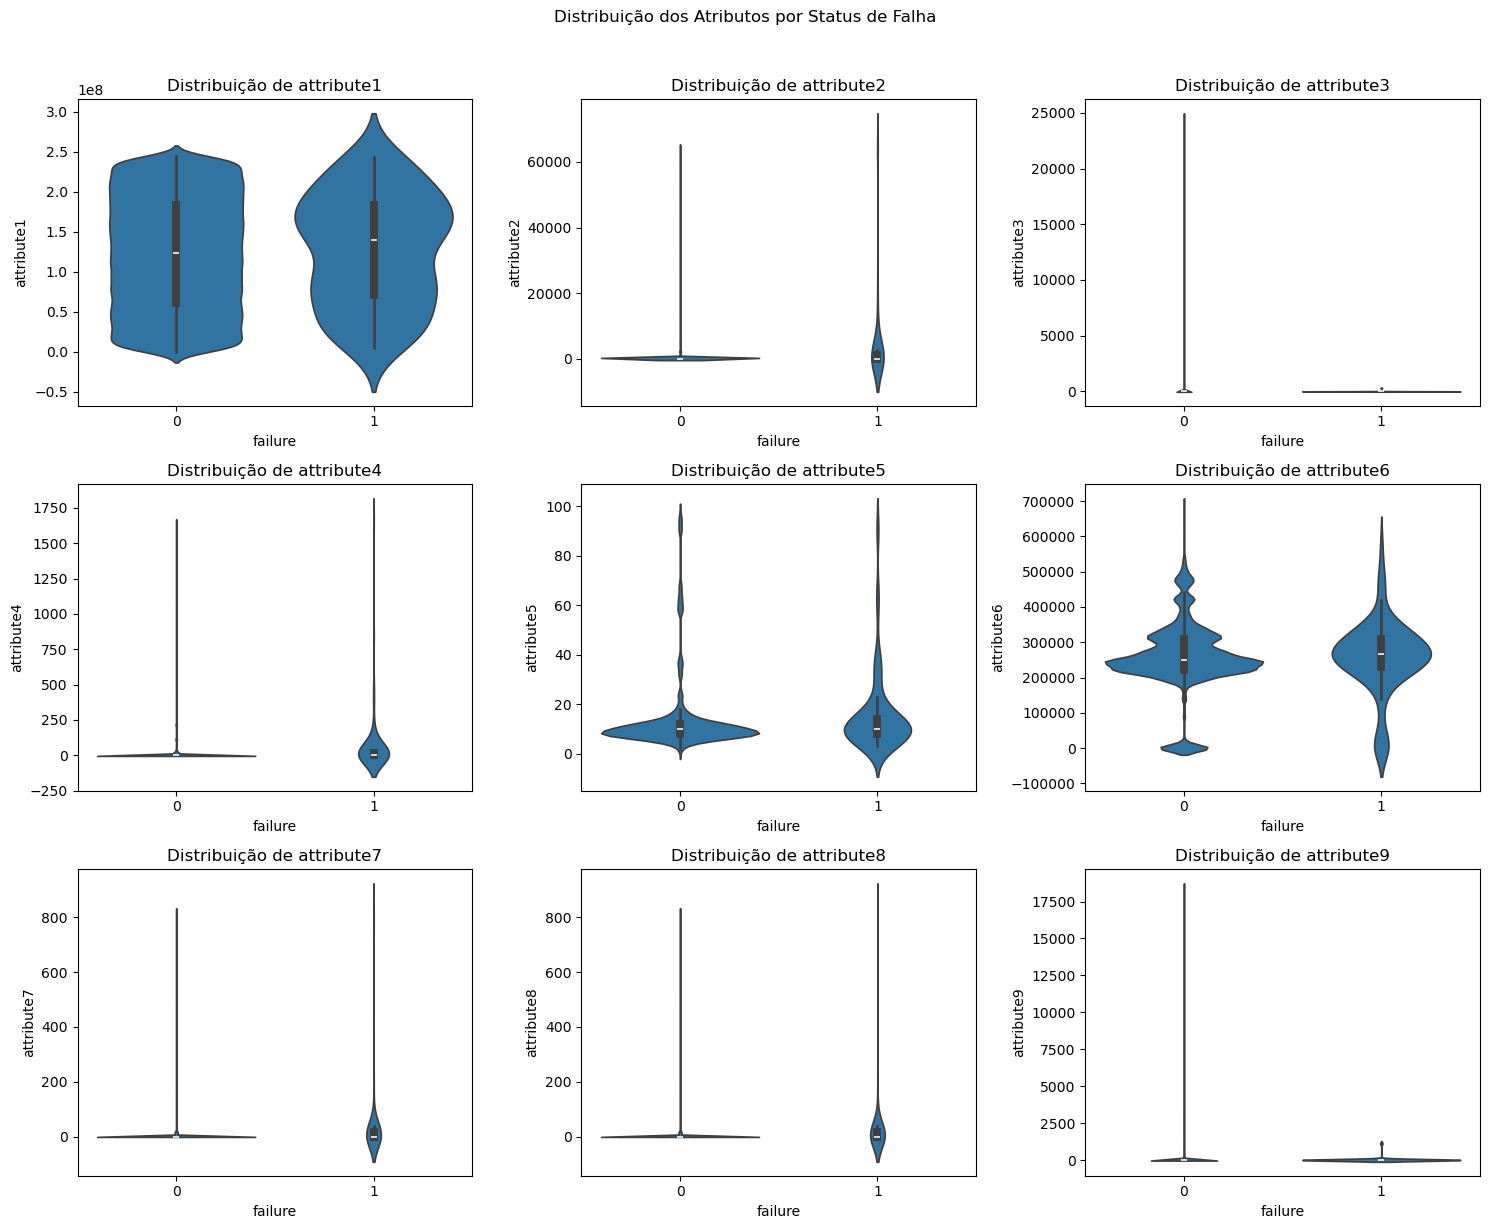

In [15]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
for i, col_name in enumerate(attribute_cols):
    row = i // 3
    col = i % 3
    sns.violinplot(data=df, y=col_name, x="failure", ax=axes[row, col])
    axes[row, col].set_title(f'Distribuição de {col_name}')
plt.suptitle('Distribuição dos Atributos por Status de Falha', y=1.02)
plt.tight_layout()

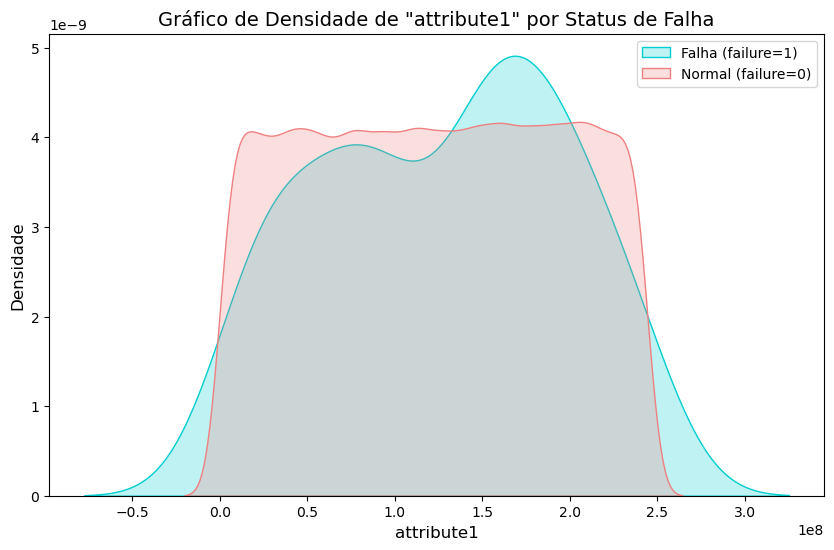

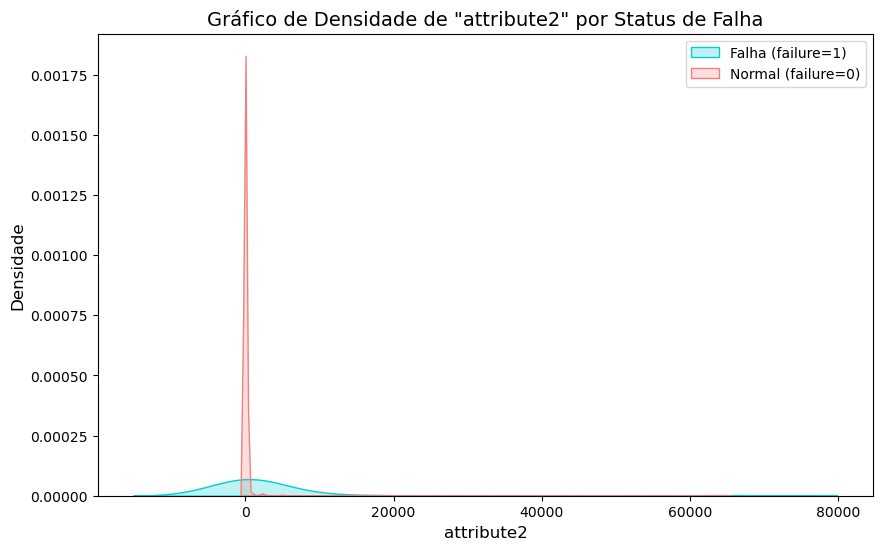

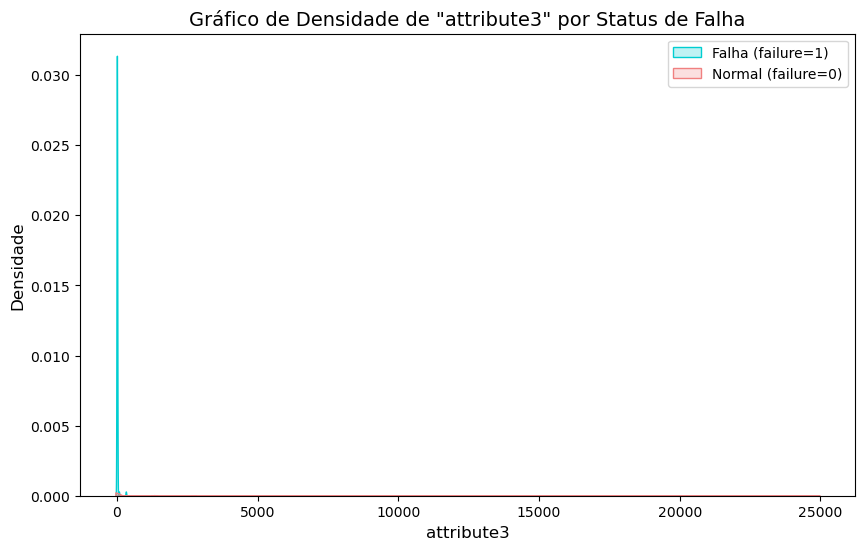

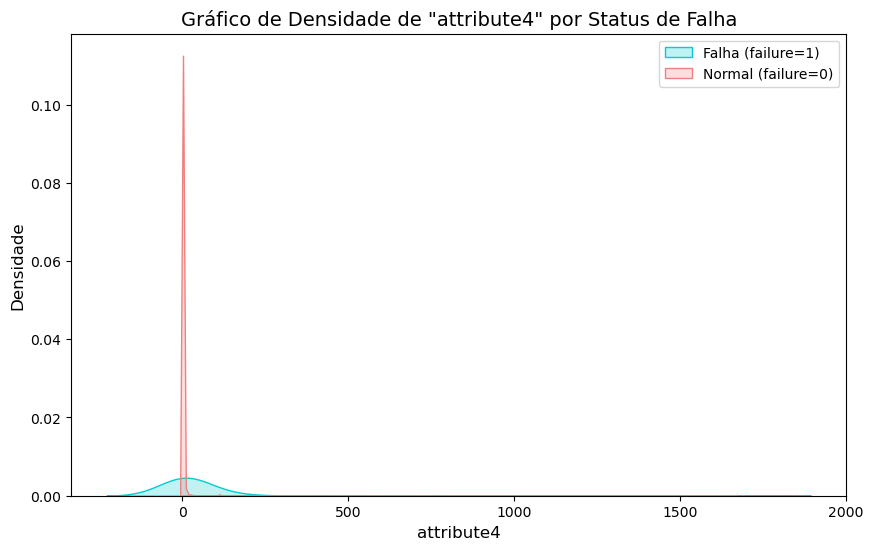

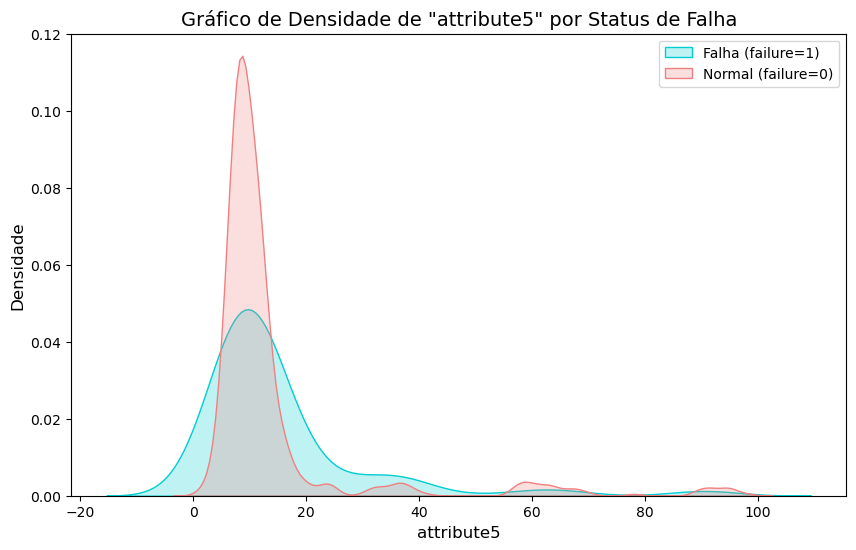

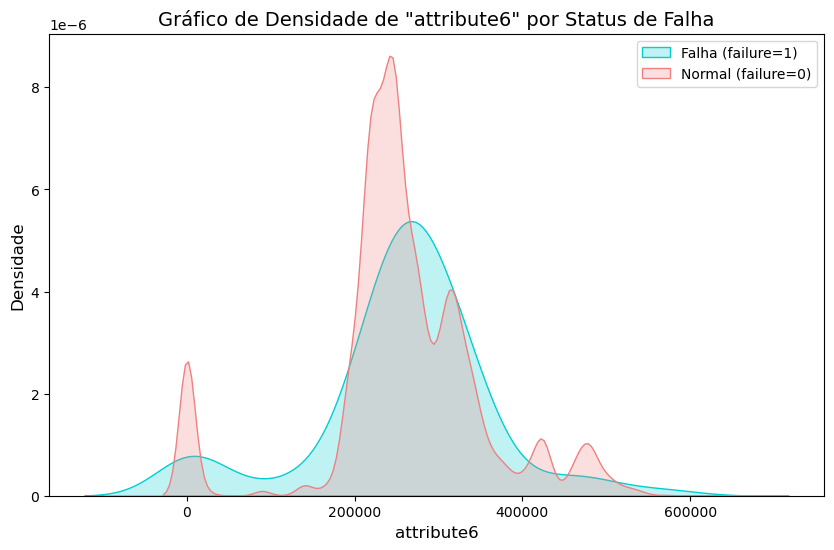

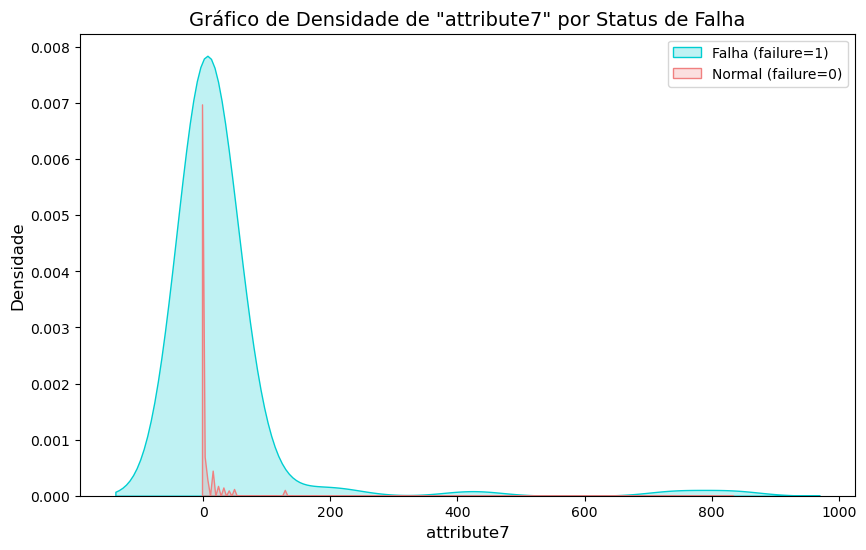

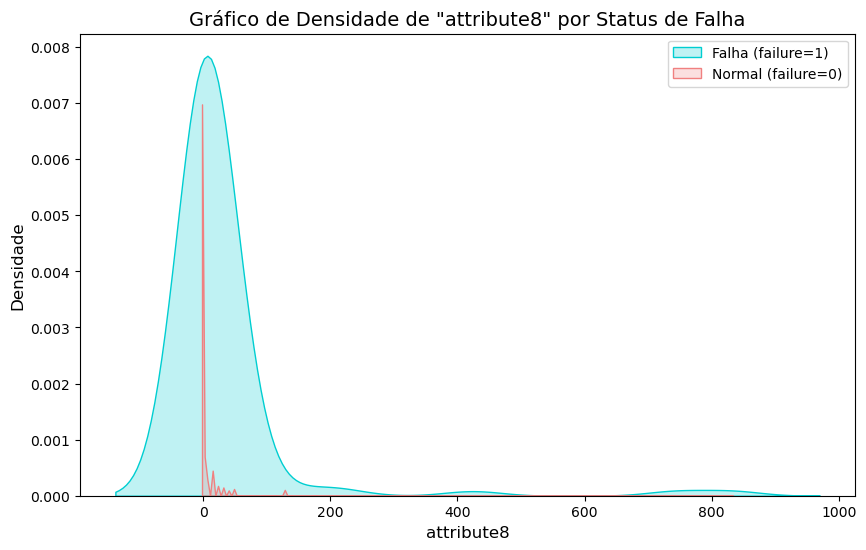

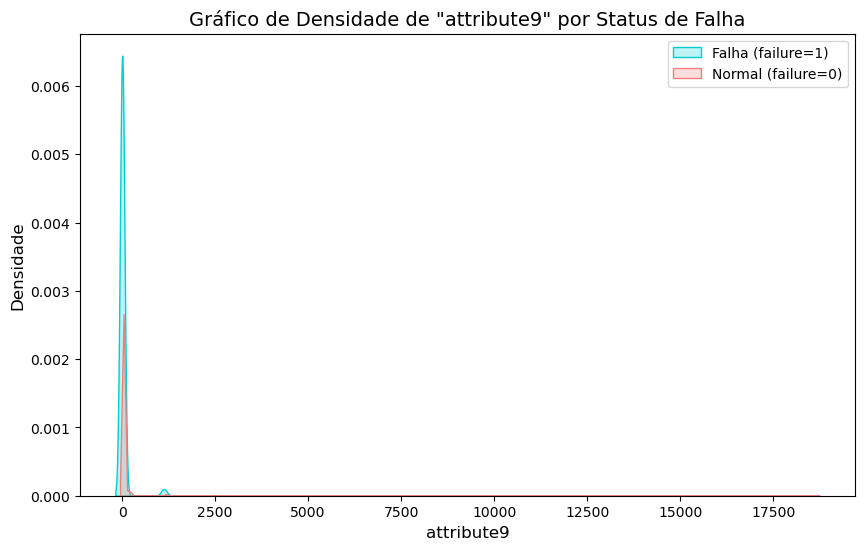

In [16]:
for col in attribute_cols:
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    ax.set_title(f'Gráfico de Densidade de "{col}" por Status de Falha', fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Densidade', fontsize=12)

    sns.kdeplot(data=df[df.failure == 1], x=col, color="darkturquoise", fill=True,
                label='Falha (failure=1)', ax=ax)

    sns.kdeplot(data=df[df.failure == 0], x=col, color="lightcoral", fill=True,
                label='Normal (failure=0)', ax=ax)
    ax.legend()
    plt.show()

- Análise de correlação

In [17]:
df[attribute_cols].describe()

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


Autocorrelação - análise comparativa de autocorrelação temporal 

In [18]:
def plot_comparative_acf(device_id: str,
             df_device: pd.DataFrame,
             features_to_analyze: List[str],
             pre_failure_window: int,
             normal_window_size: int,
             normal_window_offset: int,
             time_col: str = 'date'):

    total_lifespan = len(df_device)
    print(f"\n--- Analisando o Dispositivo: {device_id} (Vida Útil Total: {total_lifespan} registros) ---")

    if total_lifespan < pre_failure_window or total_lifespan < (normal_window_offset + normal_window_size):
        print("Dados insuficientes para as janelas definidas")
        return

    pre_failure_data = df_device.iloc[-pre_failure_window:]
    normal_data = df_device.iloc[normal_window_offset : normal_window_offset + normal_window_size]

    num_features = len(features_to_analyze)
    fig, axes = plt.subplots(num_features, 1, figsize=(12, num_features * 3.5), squeeze=False, sharex=True)
    fig.suptitle(f'Análise de Autocorrelação Comparativa para o Dispositivo {device_id}', fontsize=16)

    for i, feature in enumerate(features_to_analyze):
        ax = axes[i, 0]
        lags_to_plot = min(30, len(normal_data) - 1)

        ax.set_ylabel(feature, fontsize=12, rotation=0, ha='right', va='center', labelpad=50)
        ax.yaxis.set_label_coords(-0.1, 0.5)

        if lags_to_plot < 1:
            ax.text(0.5, 0.5, 'Janela de dados muito pequena', ha='center', va='center')
            continue

        acf_normal = acf(normal_data[feature].dropna(), nlags=1, fft=False)
        acf_pre_failure = acf(pre_failure_data[feature].dropna(), nlags=1, fft=False)
        lag1_normal = acf_normal[1] if len(acf_normal) > 1 else 0
        lag1_pre_failure = acf_pre_failure[1] if len(acf_pre_failure) > 1 else 0

        plot_acf(normal_data[feature].dropna(), ax=ax, lags=lags_to_plot, title='',
                 label='Normal', color='skyblue', vlines_kwargs={"colors": "skyblue"})
        plot_acf(pre_failure_data[feature].dropna(), ax=ax, lags=lags_to_plot, title='',
                 label='Pré-Falha', color='orangered', vlines_kwargs={"colors": "orangered"})

        ax.text(0.98, 0.95, f'ACF(1) Normal: {lag1_normal:.2f}', transform=ax.transAxes,
                ha='right', va='top', bbox=dict(boxstyle='round,pad=0.3', fc='skyblue', alpha=0.5))
        ax.text(0.98, 0.75, f'ACF(1) Pré-Falha: {lag1_pre_failure:.2f}', transform=ax.transAxes,
                ha='right', va='top', bbox=dict(boxstyle='round,pad=0.3', fc='orangered', alpha=0.5))

        handles, labels = ax.get_legend_handles_labels()

        if i == 0 and len(handles) > 2:
             ax.legend([handles[0], handles[2]], [labels[0], labels[2]], loc='upper right', bbox_to_anchor=(0.7, 1))
        else:
            legend = ax.get_legend()
            if legend:
                legend.remove()

    axes[-1, 0].set_xlabel('Lags')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

- Janela Normal: dias 10-39 da vida útil
- Janela Pré-falha: últimos 30 dias antes da falha

Calcula o ACF até o lag29 para cada janela e atributo, permitindo uma análise visual "nomal vs pré-falha". Dessa forma, mudanças na estrutura temporal podem indicar sinais de alerta pré-falha.


--- Analisando o Dispositivo: S1F023H2 (Vida Útil Total: 19 registros) ---
Dados insuficientes para as janelas definidas

--- Analisando o Dispositivo: S1F03YZM (Vida Útil Total: 215 registros) ---


u:\Users\0339867\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


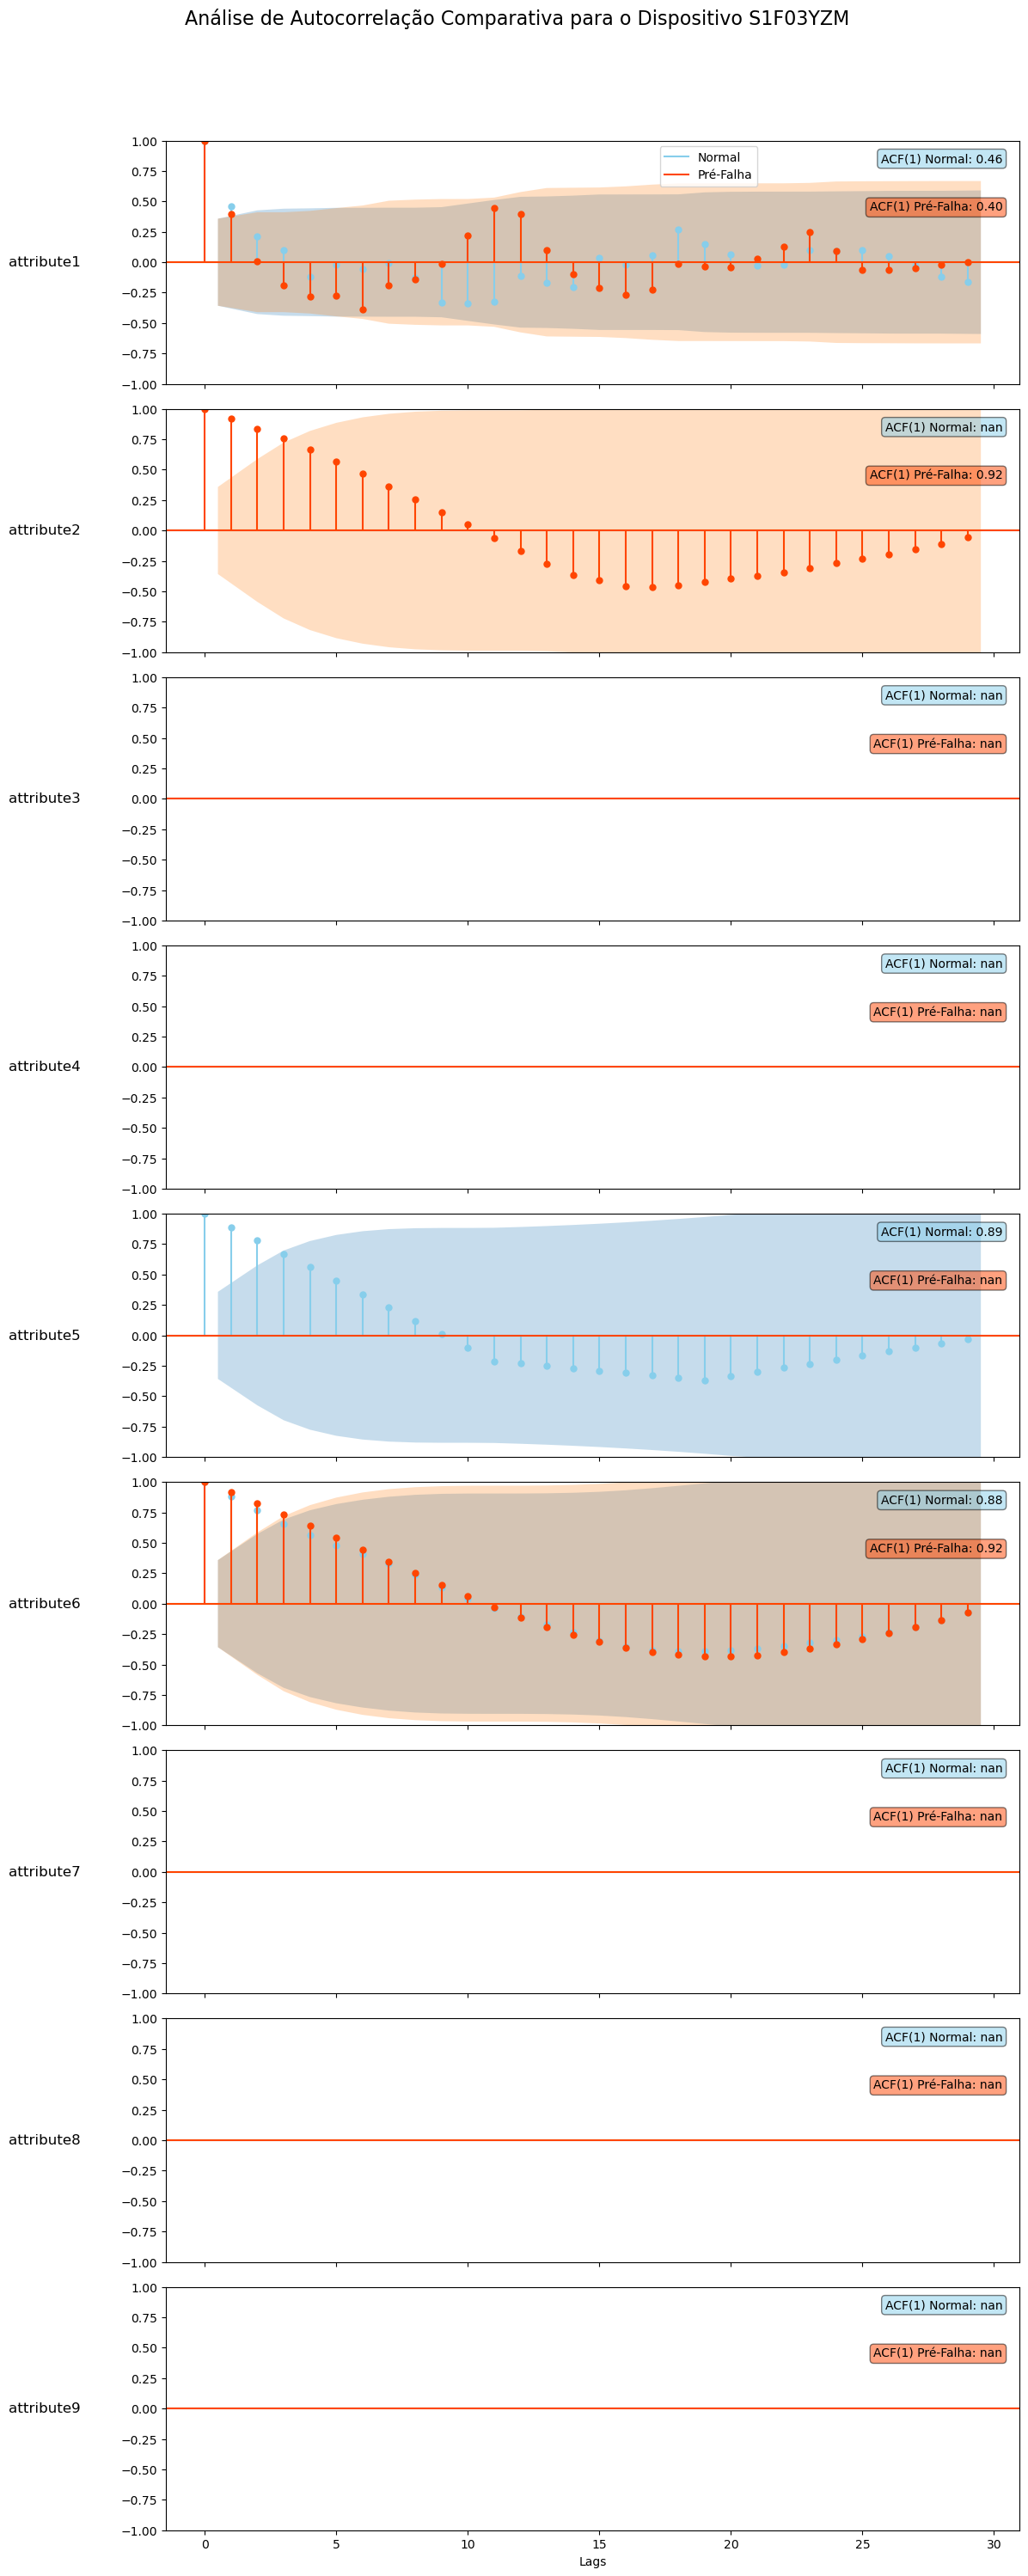


--- Analisando o Dispositivo: S1F09DZQ (Vida Útil Total: 199 registros) ---


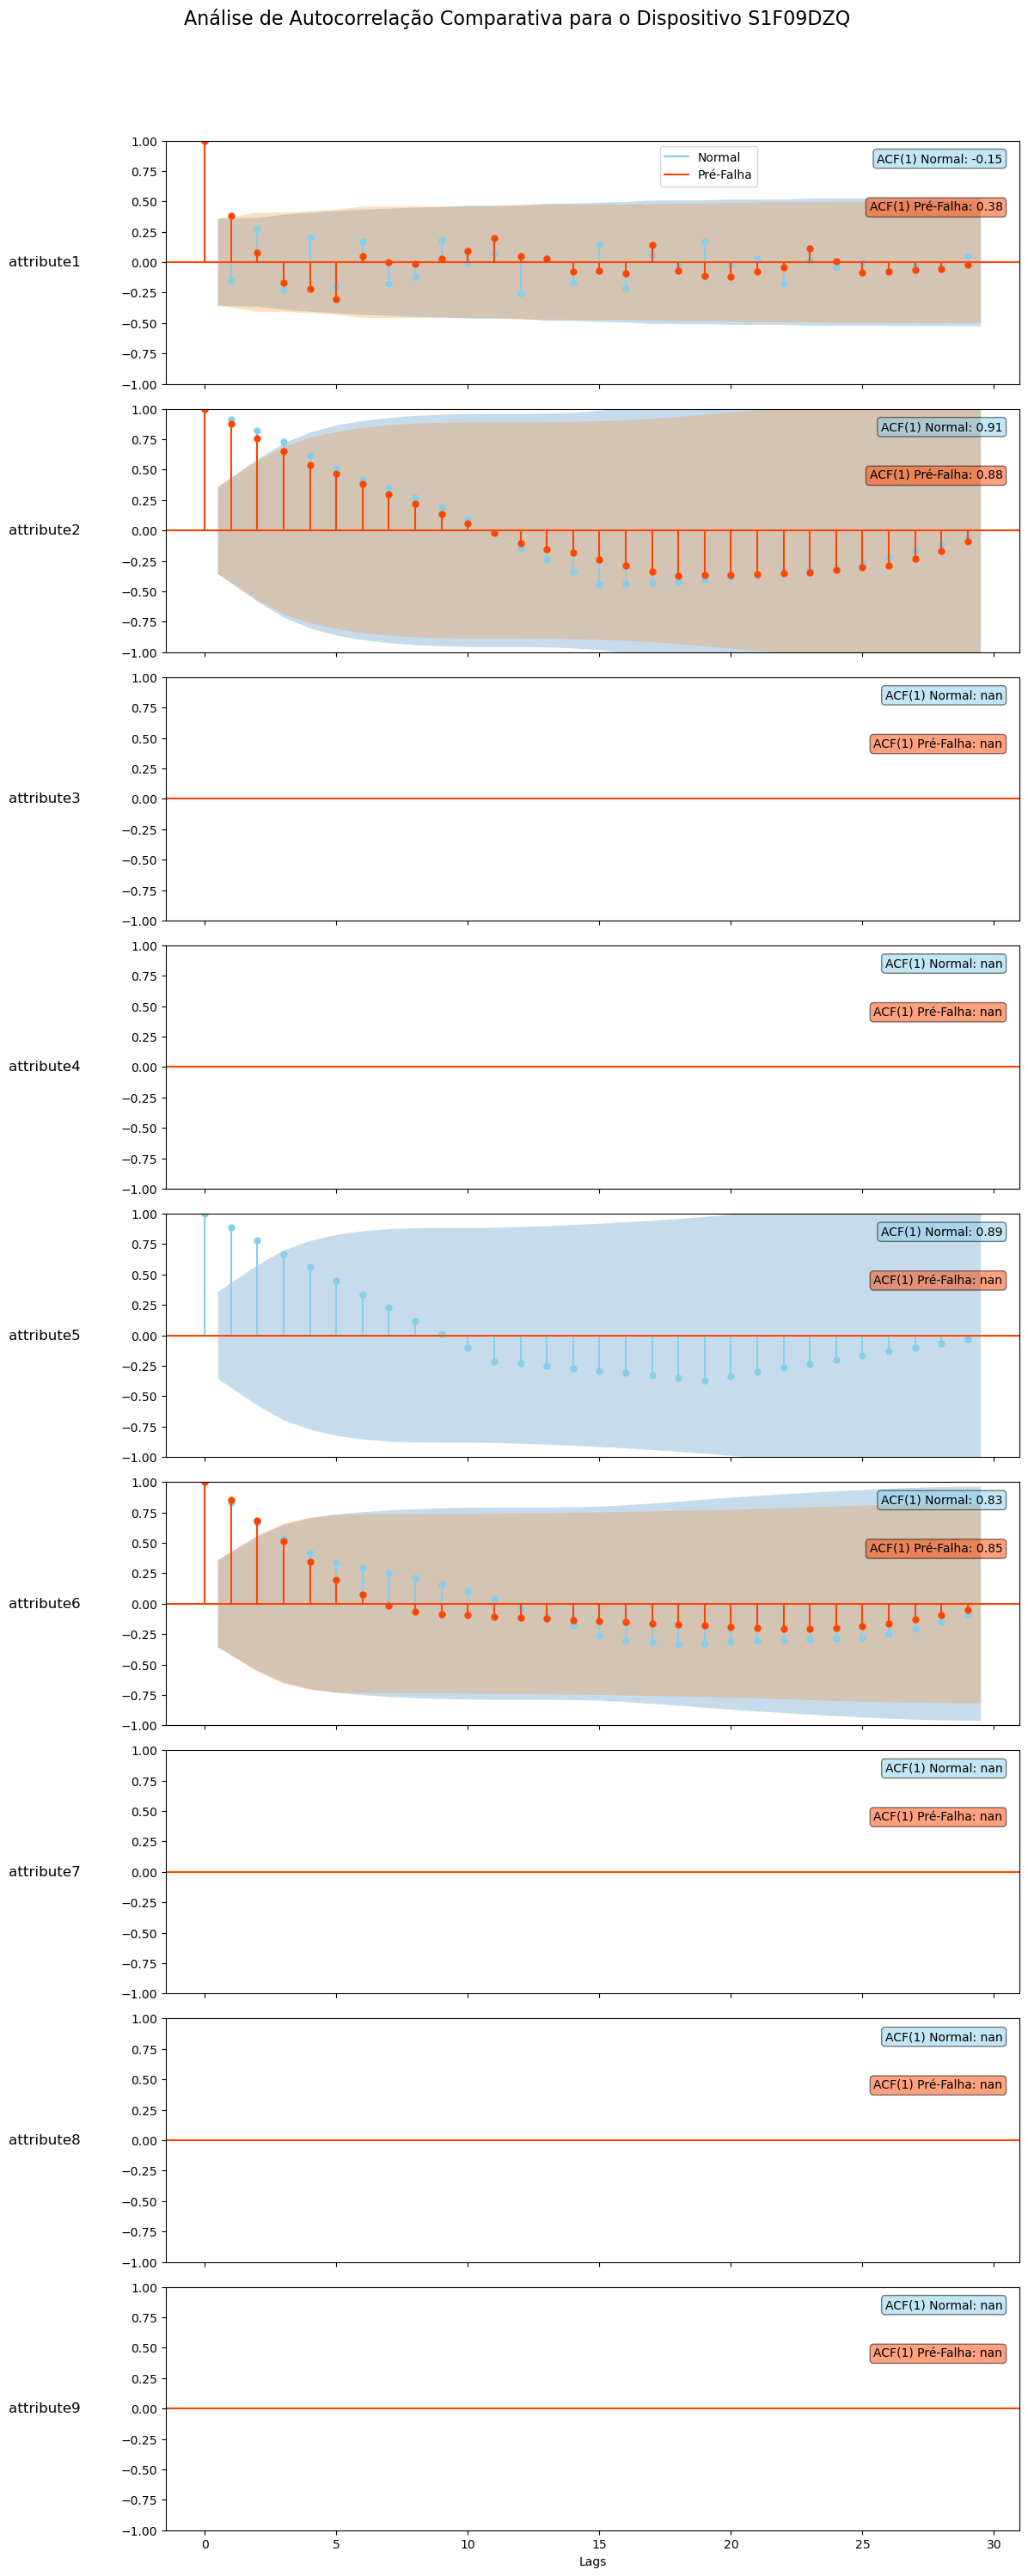


--- Analisando o Dispositivo: S1F0CTDN (Vida Útil Total: 7 registros) ---
Dados insuficientes para as janelas definidas

--- Analisando o Dispositivo: S1F0DSTY (Vida Útil Total: 45 registros) ---


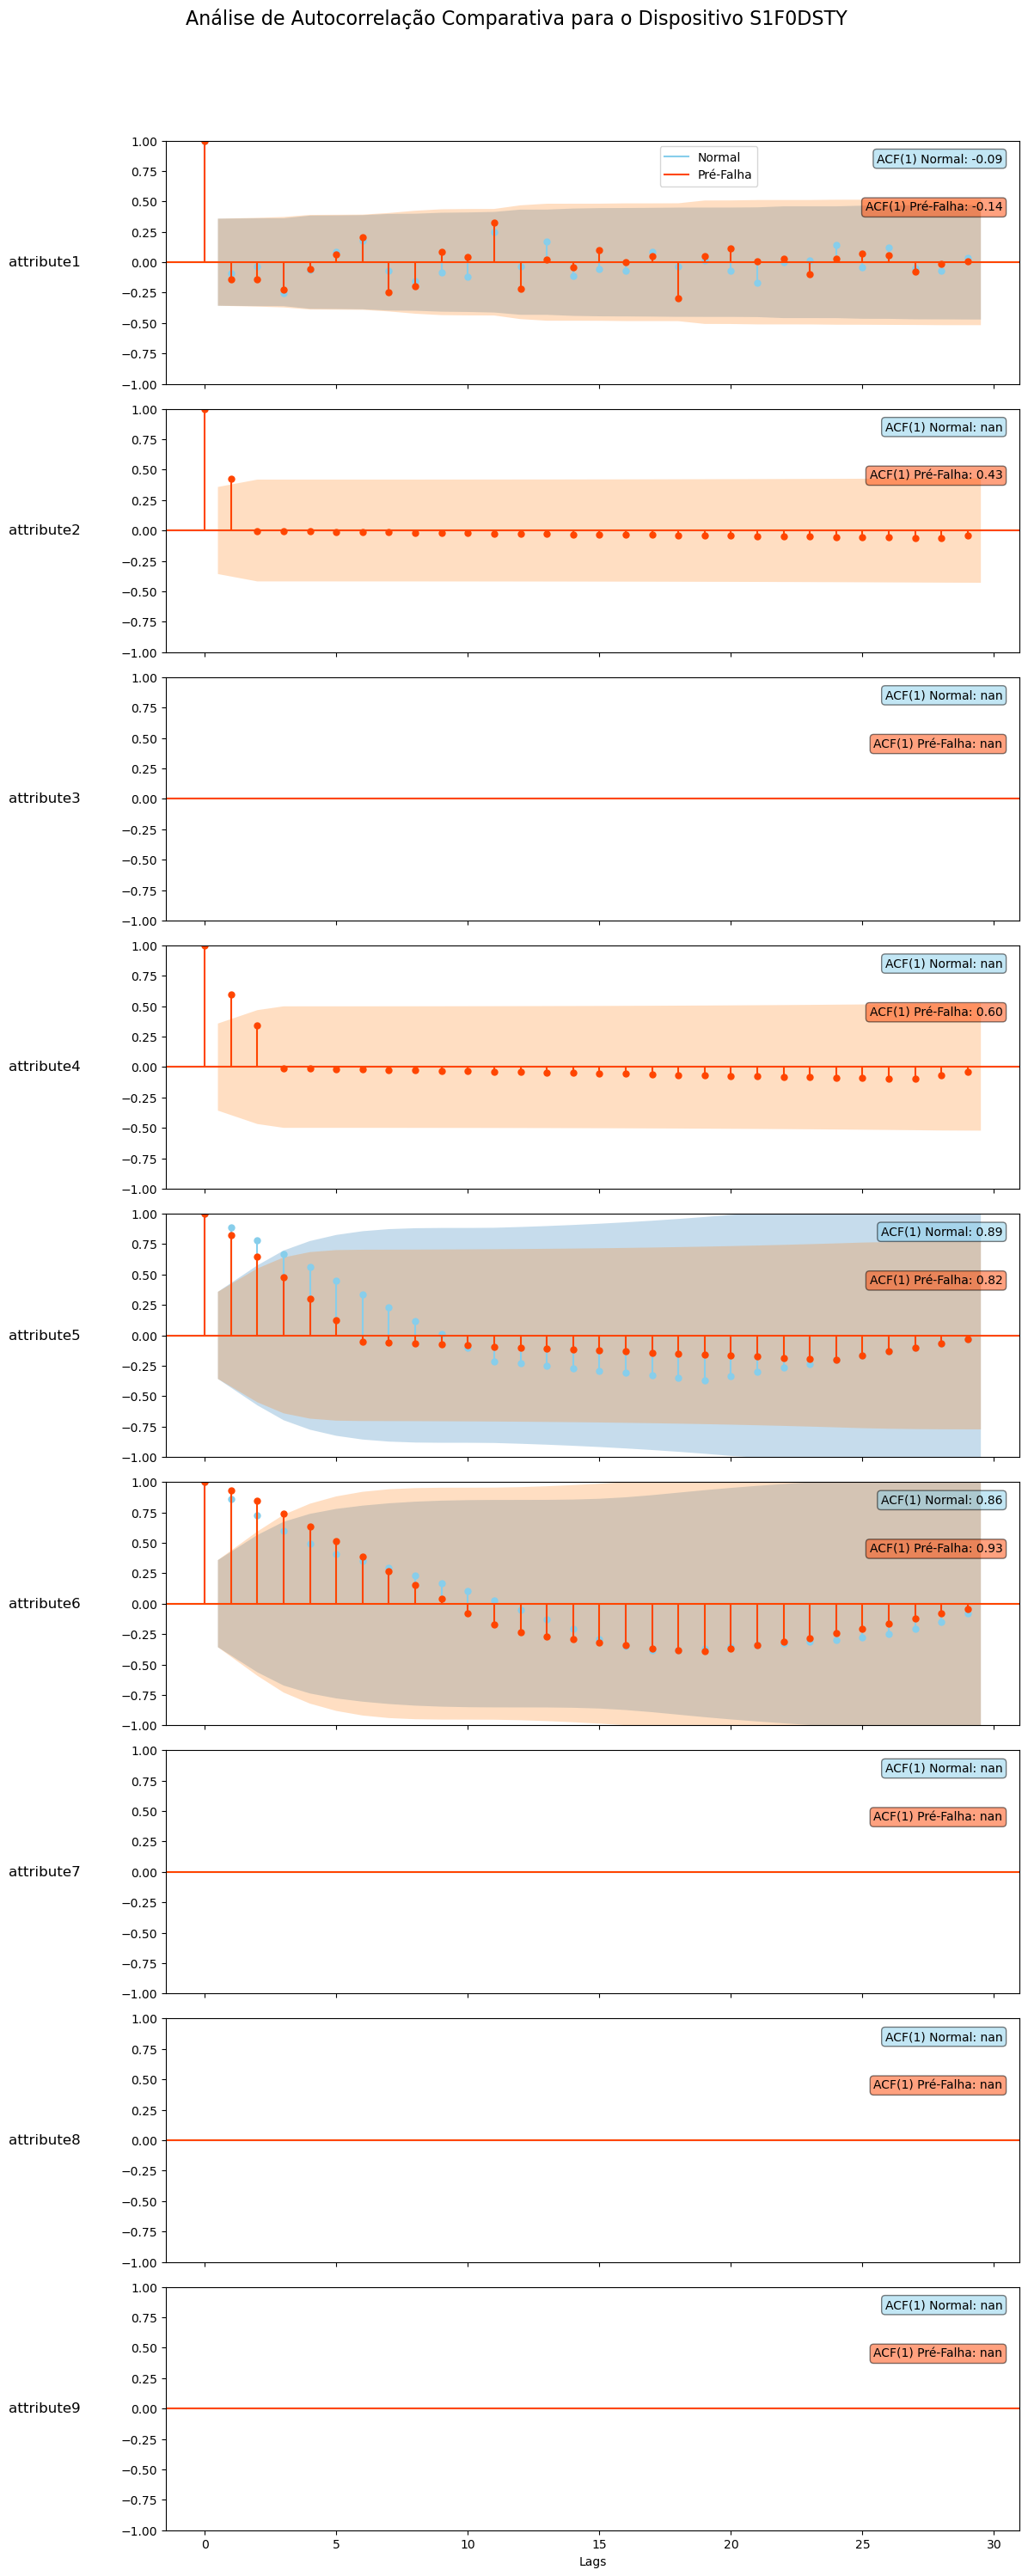

In [19]:
failure_summary = df.groupby('device')['failure'].max()
failing_devices_list = failure_summary[failure_summary == 1].index
df_failing_only = df[df['device'].isin(failing_devices_list)].copy()

dispositivos_para_analise = failing_devices_list[:5]

for device in dispositivos_para_analise:
    df_single_device = df_failing_only[df_failing_only['device'] == device].sort_values('date')

    plot_comparative_acf(
        device_id=device,
        df_device=df_single_device,
        features_to_analyze=attribute_cols,
        pre_failure_window=30,
        normal_window_size=30,
        normal_window_offset=10,
        time_col='date'
    )

- A partir de uma análise visual nas janelas consideradas, os dispositivos 1, 2 e 6 aparentam ter correlação baixa no período normal e aumento da correlação no período pré-falha.

- Os atributos 3, 4, 7, 8 e 9 aparentemente não apresentam sinais são muito informativos

- O atributo 5 parece ser bastante relevante.

Correlação entre as variáveis

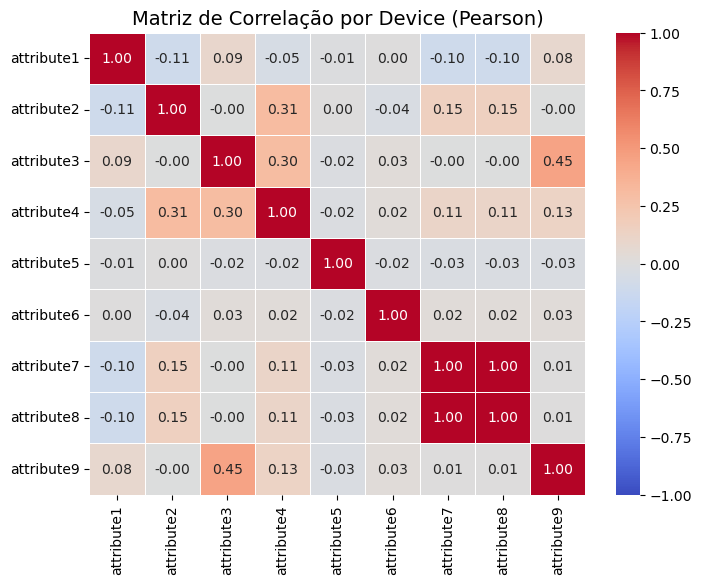

In [20]:
def plot_device_correlation_heatmap(
    df: pd.DataFrame,
    attribute_cols: List[str],
    device_col: str = "device",
    method: str = "pearson",
    figsize: tuple = (8, 6),
    cmap: str = "coolwarm"
):

    df_agg = df.groupby(device_col)[attribute_cols].mean()

    corr_matrix = df_agg.corr(method=method)

    # heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr_matrix,
        annot=True, fmt=".2f",
        cmap=cmap,
        linewidths=.5,
        vmin=-1, vmax=1
    )
    plt.title(f"Matriz de Correlação por Device ({method.capitalize()})", fontsize=14)
    plt.show()

attributes = [c for c in df.columns if c.startswith("attribute")]
plot_device_correlation_heatmap(df, attributes, device_col="device", method="pearson")


As features *attribute7* e *attribute8* são redundantes.

#### Modelagem

- Separação em treino e teste

In [21]:
def split_data(
    data: pd.DataFrame,
    test_percentage: float = 20,
    date_col: str = "date",
    group_col: str = "device",
    gap: str = None,           
    boundary_to: str = "test"  
) -> Tuple[pd.DataFrame, pd.DataFrame]:

    df = data.copy()
    if df[date_col].dtype == "object":
        df[date_col] = pd.to_datetime(df[date_col])

    df = df.sort_values(date_col).reset_index(drop=True)

    split_idx = int(len(df) * (100 - test_percentage) / 100)
    split_idx = max(1, min(split_idx, len(df)-1))
    cutoff_ts = df.loc[split_idx, date_col]

    if boundary_to == "test":

        train = df[df[date_col] <=  cutoff_ts].copy()
        test  = df[df[date_col] > cutoff_ts].copy()
    else:

        train = df[df[date_col] <= cutoff_ts].copy()
        test  = df[df[date_col] >  cutoff_ts].copy()

    if gap:
        gap_delta = pd.to_timedelta(gap)
        start_test = test[date_col].min()
        if pd.notna(start_test):
            test = test[test[date_col] >= (start_test + gap_delta)].copy()

    failed_devices_train = train.loc[train["failure"] == 1, group_col].unique()
    test = test[~test[group_col].isin(failed_devices_train)].copy()

    return train, test

In [22]:
train_data, test_data = split_data(df, test_percentage=20, date_col="date", group_col="device",
                                   gap=None, boundary_to="test")

print("Datas de treino:", train_data["date"].min(), train_data["date"].max())
print("Datas de teste :", test_data["date"].min(), test_data["date"].max())

Datas de treino: 2015-01-01 00:00:00 2015-07-05 00:00:00
Datas de teste : 2015-07-06 00:00:00 2015-11-02 00:00:00


In [23]:
train_data, test_data = split_data(df, test_percentage=20)
print("Dimensão dos dados de treino:", train_data.shape)
print("Dimensão dos dados de teste:", test_data.shape)

Dimensão dos dados de treino: (99906, 12)
Dimensão dos dados de teste: (24588, 12)


In [24]:
print("Falhas no treino:", train_data['failure'].sum())
print("Falhas no teste:", test_data['failure'].sum())

Falhas no treino: 83
Falhas no teste: 23


#### Feature engineering

- Pré-processamento

    - Ordenação dos dados por dispositivo e data
    - Conversão automática da coluna de data para datetime
    - Identificação automática de colunas de atributos (prefixo "attribute")

- Features de Defasagem (Lag)

    - Criação de lag1 para todos os atributos (attribute_*_lag1)
        - Para evitar data leakage em séries temporais

- Suavização LOWESS

    - Aplicação de regressão LOWESS nos valores lag1 de cada atributo

- Estatísticas Rolling

    - Janelas configuráveis (padrão: 3, 7, 14 dias)
    - Estatísticas descritivas: média, desvio padrão, máximo, mínimo, mediana
    - Features derivadas:
        - range (max - min)
        - coeficiente de variação (CV = std/|mean|)
        - suavização exponencial (EWM)
        - delta entre primeiro e último valor da janela

    - deltas sazonais: diferença entre lag1 e estatísticas da janela de 7 dias

- Entropia

    - Entropia de Shannon em janela móvel de 7 dias
    - Discretização em 10 bins para o cálculo probabilístico

- Features de Fourier nas variáveis de calendário

    - Componentes seno e cosseno para períodos de 7 e 14 dias
    - Captura padrões cíclicos semanais e quinzenais

- Variáveis de calendário
    
    - dia da semana, mês, fim de semana, fim do mês ...
    - se é final de semana ou não
    - se é fim de mês 

- Variáveis de velocidade de degradação

    - "primeira derivada": velocidade de mudança
    - "segunda derivada": aceleração da mudança
    - estatísticas de velocidade: média e desvio padrão rolantes nas janelas de 7 e 14 dias
    - monotonicidade: tendência de crescimento/descrescimento em janelas de 14 dias

- Detecção de outliers

    - Isolation Forest para identificar outliers
    - features binárias indicando anomalias

- Variáveis de análise de sobrevivência

    - duração operacional: dias desde a primeira medição por dispositivo
    - log-duração: transformação logarítmica da duração
    - fases de vida útil:
        - early life: decaimento exponencial de 30 dias
        - wear-out: crescimento quadrático (365 dias)

- Transformação logarítmica nas features originais defasadas

    - Aplica log1p (log(1+x)) nos atributos originais com lag1


In [ ]:
def feature_engineering(
    train: pd.DataFrame,
    test: pd.DataFrame,
    attr_cols: Optional[List[str]] = None,
    windows: List[int] = [3, 7, 14],
    entropy_window: int = 7,
    fourier_periods: List[int] = [7, 14],
    iso_n_estimators: int = 100,
    iso_contamination: float = 0.01,
    iso_random_state: int = 42,
    lowess_frac: float = 0.1,
) -> Tuple[pd.DataFrame, pd.DataFrame]:


    def _ensure_attr_cols(df: pd.DataFrame) -> List[str]:
        return [c for c in df.columns if c.startswith("attribute")]

    def _ensure_sorted(df: pd.DataFrame) -> pd.DataFrame:
        X = df.copy()
        if not np.issubdtype(X["date"].dtype, np.datetime64):
            X["date"] = pd.to_datetime(X["date"])
        return X.sort_values(["device", "date"]).reset_index(drop=True)

    def _rolling_from_base(df: pd.DataFrame, base_col: str, w: int, minp: int = 2):
        g = df.groupby("device", sort=False)[base_col]
        return g.rolling(window=w, min_periods=minp)

    # -------------------------
    # cria lag1 
    # -------------------------
    def _make_lag1_only(df: pd.DataFrame) -> pd.DataFrame:
        X = df.copy()
        for c in attr_cols:
            X[f"{c}_lag1"] = X.groupby("device", sort=False)[c].shift(1)
        return X

    # -------------------------
    # suavização lowess
    # -------------------------
    def _lowess_transform(df: pd.DataFrame) -> pd.DataFrame:
        X = df.copy()
        for c in attr_cols:
            out = []
            for _, g in X.groupby("device", sort=False):
                y = g[f"{c}_lag1"].astype(float)
                if y.notna().sum() < 5:
                    out.append(pd.Series(np.nan, index=g.index))
                    continue
                x = np.arange(len(g), dtype=float)
                mask = y.notna()
                sm = np.full(len(g), np.nan)
                try:
                    y_hat = lowess(y[mask], x[mask], frac=lowess_frac, return_sorted=False)
                    sm[mask] = y_hat
                except Exception:
                    pass
                out.append(pd.Series(sm, index=g.index))
            X[f"{c}_lowess"] = pd.concat(out).sort_index()
        return X

    # -------------------------
    # estatísticas rolling
    # -------------------------
    def _rolling_statistics_core(df: pd.DataFrame) -> pd.DataFrame:
        X = df.copy()

        for c in attr_cols:
            base = f"{c}_lag1"
            for w in windows:
                r = _rolling_from_base(X, base, w)

                X[f"{c}_ma{w}"] = r.mean().reset_index(level=0, drop=True)
                X[f"{c}_std{w}"] = r.std().reset_index(level=0, drop=True)
                X[f"{c}_max{w}"] = r.max().reset_index(level=0, drop=True)
                X[f"{c}_min{w}"] = r.min().reset_index(level=0, drop=True)
                X[f"{c}_median{w}"] = r.quantile(0.5).reset_index(level=0, drop=True)

                X[f"{c}_range{w}"] = X[f"{c}_max{w}"] - X[f"{c}_min{w}"]
                X[f"{c}_cv{w}"] = X[f"{c}_std{w}"] / (X[f"{c}_ma{w}"].abs() + 1e-8)

                # suavização exponencial
                X[f"{c}_ewm{w}"] = (
                    X.groupby("device", sort=False)[base]
                      .apply(lambda s: s.ewm(halflife=w//2, min_periods=1).mean())
                      .reset_index(level=0, drop=True)
                )

                # delta
                X[f"{c}_win_delta{w}"] = (
                    r.apply(lambda a: a[-1] - a[0] if len(a) >= 2 else np.nan, raw=True)
                      .reset_index(level=0, drop=True)
                )

            # diferenças (sazonalidade semanal)
            w = 7
            for suf in [f"ma{w}", f"std{w}", f"ewm{w}"]:
                st = f"{c}_{suf}"
                if st in X.columns:
                    X[f"{c}_dev_{suf}"] = X[f"{c}_lag1"] - X[st]

        return X

    # -------------------------
    # entropia
    # -------------------------
    def _rolling_shannon_entropy(df: pd.DataFrame) -> pd.DataFrame:
        X = df.copy()
        EPS = 1e-12

        def _entropy_window(a: np.ndarray, bins: int = 10) -> float:
            a = np.asarray(a)
            a = a[np.isfinite(a)]
            if a.size < 2:
                return 0.0
            rng = np.nanmax(a) - np.nanmin(a)
            if not np.isfinite(rng) or rng < EPS:
                return 0.0
            a_norm = (a - np.nanmin(a)) / (rng + EPS)
            hist, _ = np.histogram(a_norm, bins=bins, range=(0.0, 1.0))
            p = hist.astype(float) / (hist.sum() + EPS)
            p = p[p > 0]
            return float(-np.sum(p * np.log2(p + EPS)))

        for c in attr_cols:
            base = f"{c}_lag1"
            X[f"{c}_entropy{entropy_window}"] = (
                _rolling_from_base(X, base, entropy_window)
                  .apply(_entropy_window, raw=True)
                  .reset_index(level=0, drop=True)
            )
        return X

    # -------------------------
    # Fourier calendário (sazonalidade semanal)
    # -------------------------
    def _calendar_fourier_simple(df: pd.DataFrame) -> pd.DataFrame:
        X = df.copy()
        t = (pd.to_datetime(X["date"]) - pd.to_datetime(X["date"]).min()).dt.days.astype(float)
        for p in fourier_periods:
            w = 2 * np.pi / p
            X[f"sin_{p}"] = np.sin(w * t)
            X[f"cos_{p}"] = np.cos(w * t)
        return X

    # -------------------------
    # features temporais
    # -------------------------
    def _temporal_pattern_core(df: pd.DataFrame) -> pd.DataFrame:
        X = df.copy()
        X["date"] = pd.to_datetime(X["date"])

        X["day_of_week"] = X["date"].dt.dayofweek
        X["month"] = X["date"].dt.month
        X["is_weekend"] = (X["day_of_week"] >= 5).astype(int)
        X["is_month_end"] = X["date"].dt.is_month_end.astype(int)

        # if "failure" in X.columns:
        #     for p in ["day_of_week", "month"]:
        #         rates = X.groupby(p)["failure"].mean()
        #         X[f"failure_rate_{p}"] = X[p].map(rates)

        return X

    # -------------------------
    # velocidades 
    # -------------------------
    def _degradation_velocity_core(df: pd.DataFrame) -> pd.DataFrame:
        X = df.copy()
        for c in attr_cols:
            lag_col = f"{c}_lag1"
            if lag_col not in X.columns:
                continue

            # primeira e segunda derivadas
            X[f"{c}_velocity"] = X.groupby("device", sort=False)[lag_col].diff()
            X[f"{c}_acceleration"] = X.groupby("device", sort=False)[f"{c}_velocity"].diff()

            # estatística de velocidade (janelas 7 e 14)
            for w in [7, 14]:
                r = _rolling_from_base(X, f"{c}_velocity", w)
                X[f"{c}_velocity_mean_{w}"] = r.mean().reset_index(level=0, drop=True)
                X[f"{c}_velocity_std_{w}"] = r.std().reset_index(level=0, drop=True)

            # monotonicidade (apenas janela 14)
            w = 14
            X[f"{c}_monotonicity_{w}"] = (
                X.groupby("device", sort=False)[lag_col]
                 .rolling(w, min_periods=3)
                 .apply(lambda s: 0 if len(s.dropna()) < 3
                                 else (np.sum(np.diff(s.dropna()) > 0) -
                                       np.sum(np.diff(s.dropna()) < 0)) / max(1, len(s.dropna())-1),
                        raw=False)
                 .reset_index(level=0, drop=True)
            )
        return X

    # -------------------------
    # outlier - isolation forest 
    # -------------------------
    def _isolation_forest_flags(train_df: pd.DataFrame, test_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
        tr, te = train_df.copy(), test_df.copy()
        feat_cols = [f"{c}_lag1" for c in attr_cols if f"{c}_lag1" in tr.columns]

        Xtr = tr[feat_cols].astype(float)
        Xte = te[feat_cols].astype(float)

        med = Xtr.median(numeric_only=True)
        Xtr = Xtr.fillna(med)
        Xte = Xte.fillna(med)

        iso = IsolationForest(
            n_estimators=iso_n_estimators,
            contamination=iso_contamination,
            random_state=iso_random_state,
            n_jobs=-1
        )
        iso.fit(Xtr.values)

        tr["iso_outlier"] = (iso.predict(Xtr.values) == -1).astype(int)
        te["iso_outlier"] = (iso.predict(Xte.values) == -1).astype(int)

        return tr, te

    # -------------------------
    # análise de sobrevivência 
    # -------------------------
    def _survival_analysis_core(df: pd.DataFrame, date_col: str = "date", fail_col: str = "failure") -> pd.DataFrame:
        X = df.copy()
        X[date_col] = pd.to_datetime(X[date_col])

        # duração de operação
        first = X.groupby("device", sort=False)[date_col].transform("min")
        X["duration_days_survival"] = (X[date_col] - first).dt.days + 1
        X["log_duration_survival"] = np.log1p(X["duration_days_survival"])

        # fases de vida útil
        X["early_life_survival"] = np.exp(-X["duration_days_survival"] / 30.0)
        X["wear_out_survival"] = 1.0 - np.exp(-(X["duration_days_survival"] / 365.0) ** 2)

        return X

    # -------------------------
    # transformações log nas features originais defasadas
    # -------------------------
    def _append_log1p_selective(df: pd.DataFrame) -> pd.DataFrame:
        X = df.copy()
        for c in attr_cols:
            if c in X.columns:
                X[f"{c}_log1p"] = np.log1p(X[c].astype(float).clip(lower=0))
            lagc = f"{c}_lag1"
            if lagc in X.columns:
                X[f"{lagc}_log1p"] = np.log1p(X[lagc].astype(float).clip(lower=0))
        return X


    def _clean_and_align(train_df: pd.DataFrame, test_df: pd.DataFrame):
        # remove constantes
        const_cols = train_df.columns[train_df.nunique(dropna=False) <= 1].tolist()
        if const_cols:
            train_df = train_df.drop(columns=const_cols, errors="ignore")
            test_df = test_df.drop(columns=const_cols, errors="ignore")

        missing_in_test = set(train_df.columns) - set(test_df.columns)
        for m in missing_in_test:
            test_df[m] = np.nan

        extra_in_test = set(test_df.columns) - set(train_df.columns)
        if extra_in_test:
            test_df = test_df.drop(columns=list(extra_in_test))

        test_df = test_df[train_df.columns]

        return train_df, test_df


    train = _ensure_sorted(train)
    test = _ensure_sorted(test)
    if attr_cols is None:
        attr_cols = _ensure_attr_cols(train)

    train_fe = _make_lag1_only(train)
    test_fe = _make_lag1_only(test)

    # suavização lowess
    train_fe = _lowess_transform(train_fe)
    test_fe = _lowess_transform(test_fe)

    # estatísticas rolling
    train_fe = _rolling_statistics_core(train_fe)
    test_fe = _rolling_statistics_core(test_fe)

    # entropia
    train_fe = _rolling_shannon_entropy(train_fe)
    test_fe = _rolling_shannon_entropy(test_fe)

    # Fourier 
    train_fe = _calendar_fourier_simple(train_fe)
    test_fe = _calendar_fourier_simple(test_fe)

    # features temporais
    train_fe = _temporal_pattern_core(train_fe)
    test_fe = _temporal_pattern_core(test_fe)

    # velocidades de degradação
    train_fe = _degradation_velocity_core(train_fe)
    test_fe = _degradation_velocity_core(test_fe)

    # outlier
    train_fe, test_fe = _isolation_forest_flags(train_fe, test_fe)

    # análise de sobrevivência
    train_fe = _survival_analysis_core(train_fe, date_col="date", fail_col="failure")
    test_fe = _survival_analysis_core(test_fe, date_col="date", fail_col="failure")

    for DF in (train_fe, test_fe):
        num_cols = DF.select_dtypes(include=[np.number]).columns
        DF[num_cols] = DF[num_cols].replace([np.inf, -np.inf], np.nan)

    # transformação log
    train_fe = _append_log1p_selective(train_fe)
    test_fe = _append_log1p_selective(test_fe)

    train_fe, test_fe = _clean_and_align(train_fe, test_fe)

    return train_fe, test_fe

In [26]:
train_data, test_data = split_data(df.drop(["attribute8"], axis=1), test_percentage=20)
train_df, test_df = feature_engineering(train_data, test_data)

train_df_ = train_df.drop(
    ["attribute1", "attribute2",
     "attribute3", "attribute4",
     "attribute5", "attribute6",
     "attribute7", "attribute9"
], axis=1)


test_df_ = test_df.drop(
    ["attribute1", "attribute2",
     "attribute3", "attribute4",
     "attribute5", "attribute6",
     "attribute7", "attribute9"
], axis=1)
print(train_df_.shape, test_df_.shape)

U:\Users\0339867\AppData\Local\Temp\ipykernel_16680\2171607385.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{c}_cv{w}"] = X[f"{c}_std{w}"] / (X[f"{c}_ma{w}"].abs() + 1e-8)
U:\Users\0339867\AppData\Local\Temp\ipykernel_16680\2171607385.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{c}_ewm{w}"] = (
U:\Users\0339867\AppData\Local\Temp\ipykernel_16680\2171607385.py:89: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

(99906, 346) (24588, 346)


#### Feature selection

- Fisher Score (chi-quadrado) com V de Cramér


Utiliza o teste chi-quadrado de independência combinado com o coeficiente V de Cramér para selecionar as variáveis categóricas mais relevantes.

O processo identifica variáveis com até 5 categorias únicas, e aplica o chi-quadrado para medir a associação com o target, calculando o V de Cramér para quantificar a força dessa associação, normalizada entre 0 e 1. As variáveis são selecionadas com base em um p-valor inferior a 0,05 e um V de Cramér maior ou igual a 0,02, garantindo que as variáveis selecionadas sejam estatisticamente significativas.

In [27]:
def _cramers_v(chi2_score: float, n: int, k: int, r: int) -> float:
    if k <= 1 or r <= 1:
        return 0.0
    return float(np.sqrt((chi2_score / n) / min(k - 1, r - 1)))


def select_categorical_features(
    df: pd.DataFrame,
    target: str = "failure",
    essential: List[str] = ("date", "device"),
    max_uniques: int = 10,
    alpha: float = 0.05,
    min_v: float = 0.10,
) -> Tuple[List[str], pd.DataFrame, pd.DataFrame]:

    y = df[target].astype(int)
    cats = [
        c for c in df.columns
        if c != target
        and (
            pd.api.types.is_bool_dtype(df[c])
            or (pd.api.types.is_integer_dtype(df[c]) and df[c].nunique(dropna=True) <= max_uniques)
            or (pd.api.types.is_categorical_dtype(df[c]) and df[c].nunique(dropna=True) <= max_uniques)
        )
    ]
    if not cats:
        return [], pd.DataFrame(columns=["feature","chi2","p","cramers_v","k"]), df[[*essential, target]].copy()

    X = df[cats].copy()
    for c in X.columns:
        m = X[c].min(skipna=True)
        if pd.notna(m) and m < 0:
            X[c] = X[c] - m
    X = X.fillna(0)

    chi2_scores, pvals = chi2(X, y)
    n = len(X); r = y.nunique()
    k_list = [X[c].nunique() for c in X.columns]
    v = [_cramers_v(s, n, k, r) for s, k in zip(chi2_scores, k_list)]

    results = (
        pd.DataFrame({"feature": X.columns, "chi2": chi2_scores, "p": pvals, "cramers_v": v, "k": k_list})
        .sort_values(["p", "cramers_v"], ascending=[True, False])
        .reset_index(drop=True)
    )

    selected = results.query("p < @alpha and cramers_v >= @min_v")["feature"].tolist()
    reduced = df[[*essential, target, *selected]].copy()
    return selected, results, reduced

In [28]:
selected_fisher_score, results, reduced_df = select_categorical_features(
    train_df_,
    target="failure",
    essential=["date", "device"],
    max_uniques=5,
    alpha=0.05,
    min_v=0.02
)

print("\nFeatures selecionadas:", selected_fisher_score)
print("\nResultados detalhados:")
print(results)
print("\nDataFrame reduzido:")
print(reduced_df)


Features selecionadas: ['iso_outlier']

Resultados detalhados:
        feature        chi2             p  cramers_v  k
0   iso_outlier  242.946480  8.958955e-55   0.049313  2
1    is_weekend   12.147965  4.914145e-04   0.011027  2
2  is_month_end    0.075629  7.833105e-01   0.000870  2

DataFrame reduzido:
            date    device  failure  iso_outlier
0     2015-01-01  S1F01085        0            0
1     2015-01-02  S1F01085        0            0
2     2015-01-03  S1F01085        0            0
3     2015-01-04  S1F01085        0            0
4     2015-01-05  S1F01085        0            0
...          ...       ...      ...          ...
99901 2015-04-02  Z1F2PBHX        0            0
99902 2015-04-03  Z1F2PBHX        0            0
99903 2015-04-04  Z1F2PBHX        0            0
99904 2015-04-05  Z1F2PBHX        0            0
99905 2015-04-06  Z1F2PBHX        0            0

[99906 rows x 4 columns]


U:\Users\0339867\AppData\Local\Temp\ipykernel_16680\2871918297.py:23: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  or (pd.api.types.is_categorical_dtype(df[c]) and df[c].nunique(dropna=True) <= max_uniques)


In [29]:
def drop_categoricals(df: pd.DataFrame, target: str = "failure", consider_features: List[str] = []) -> pd.DataFrame:

    cat_cols = [
        col for col in df.columns
        if df[col].dtype == 'int64'  
        and df[col].nunique() <= 10  
        and col != target  
        and col not in consider_features  
    ]
    return df.drop(columns=cat_cols)

train_df_ = drop_categoricals(train_df_, target="failure", consider_features=selected_fisher_score)
train_df_.tail()

,date,device,failure,attribute1_lag1,attribute2_lag1,attribute3_lag1,attribute4_lag1,attribute5_lag1,attribute6_lag1,attribute7_lag1,...,attribute4_log1p,attribute4_lag1_log1p,attribute5_log1p,attribute5_lag1_log1p,attribute6_log1p,attribute6_lag1_log1p,attribute7_log1p,attribute7_lag1_log1p,attribute9_log1p,attribute9_lag1_log1p
99901,2015-04-02,Z1F2PBHX,0,232559640.0,0.0,0.0,0.0,5.0,162645.0,0.0,...,0.0,0.0,1.791759,1.791759,11.999331,11.999331,0.0,0.0,0.0,0.0
99902,2015-04-03,Z1F2PBHX,0,180917784.0,0.0,0.0,0.0,5.0,162645.0,0.0,...,0.0,0.0,1.791759,1.791759,11.999331,11.999331,0.0,0.0,0.0,0.0
99903,2015-04-04,Z1F2PBHX,0,33952520.0,0.0,0.0,0.0,5.0,162645.0,0.0,...,0.0,0.0,1.791759,1.791759,11.999331,11.999331,0.0,0.0,0.0,0.0
99904,2015-04-05,Z1F2PBHX,0,59053184.0,0.0,0.0,0.0,5.0,162645.0,0.0,...,0.0,0.0,1.791759,1.791759,12.001800,11.999331,0.0,0.0,0.0,0.0
99905,2015-04-06,Z1F2PBHX,0,110545440.0,0.0,0.0,0.0,5.0,163047.0,0.0,...,0.0,0.0,1.791759,1.791759,12.007750,12.001800,0.0,0.0,0.0,0.0


#### Remoção de multicolinearidade

- Filtro de correlação

Remove variáveis altamente correlacionadas.

Calcula a matriz de correlação e identifica iterativamente o par de variáveis com maior correlação no triângulo superior, removendo (de forma gulosa) a segunda variável do índice com do par com correlação máxima, e recalcula a matriz até que todas as correlações remanescentes sejam inferiores ao threshold definido. 

In [30]:
def correlation_filter(
    df: pd.DataFrame,
    exclude: Iterable[str] = ("date", "device", "failure"),
    corr_thresh: float = 0.75
) -> Tuple[pd.DataFrame, List[str]]:

    base_cols = [c for c in exclude if c in df.columns]

    X = df.drop(columns=base_cols, errors="ignore").select_dtypes(include=[np.number])

    removed: List[str] = []
    corr_matrix = X.corr().abs()

    while True:
        upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        max_corr = upper_triangle.max().max()

        if pd.isna(max_corr) or max_corr <= corr_thresh:
            break

        col_to_drop = upper_triangle.stack().idxmax()[1]
        removed.append(col_to_drop)

        corr_matrix = corr_matrix.drop(index=col_to_drop, columns=col_to_drop)

    kept_cols = [c for c in X.columns if c not in removed]
    df_reduced = pd.concat([df[base_cols], df[kept_cols]], axis=1)

    return df_reduced, removed

In [31]:
exclude_cols = [col for col in train_df_.columns if col.endswith('survival') or col == 'iso_outlier']

train_df_reduced, removed_cols = correlation_filter(train_df_, exclude=tuple(exclude_cols), corr_thresh=0.75)

print("Colunas removidas por alta correlação:", removed_cols)
print("DataFrame resultante:", train_df_reduced.shape)

Colunas removidas por alta correlação: ['attribute3_max3', 'attribute3_max7', 'attribute3_max14', 'attribute4_max3', 'attribute4_max7', 'attribute4_max14', 'attribute6_max3', 'attribute6_max7', 'attribute6_max14', 'attribute9_max3', 'attribute9_max7', 'attribute9_max14', 'attribute3_win_delta3', 'attribute3_win_delta7', 'attribute3_win_delta14', 'attribute4_win_delta3', 'attribute4_win_delta7', 'attribute4_win_delta14', 'attribute5_max7', 'attribute5_max14', 'attribute5_win_delta14', 'attribute6_win_delta3', 'attribute6_win_delta7', 'attribute6_win_delta14', 'attribute9_win_delta3', 'attribute9_win_delta7', 'attribute9_win_delta14', 'attribute9_ewm7', 'attribute9_ewm3', 'attribute9_ewm14', 'attribute9_median14', 'attribute9_dev_std7', 'attribute9_median3', 'attribute9_median7', 'attribute9_ma14', 'attribute5_max3', 'attribute9_ma7', 'attribute9_min3', 'attribute9_ma3', 'attribute9_min14', 'attribute3_ewm7', 'attribute3_ewm3', 'attribute6_ewm3', 'attribute5_ewm3', 'attribute3_ewm14', 'a

- Filtro de VIF (Variance Inflation Factor)

Utiliza o VIF para identificar e remover variáveis altamente colineares.

Inicialmente as variáveis com baixa variância são descartadas. O VIF é calculado de forma paralela, acelerando o processo, e as variáveis com VIF superior a um threshold são removidas em cada iteração até que todas as variáveis restantes tenham um VIF satisfatório. O processo termina quando o número máximo de iterações é atingido ou quando todas as variáveis restantes atendem ao critério de VIF.

In [32]:
def _remove_low_variance_features(X: pd.DataFrame, threshold: float = 1e-6) -> pd.DataFrame:
    variances = X.var()
    return X.loc[:, variances > threshold]


def _calculate_vif_chunk(data: np.ndarray, indices: List[int]) -> List[Tuple[int, float]]:
    results = []
    for i in indices:
        try:
            vif_value = variance_inflation_factor(data, i)
            results.append((i, vif_value))
        except Exception:
            results.append((i, np.inf))
    return results


def _calculate_vif_parallel(X: pd.DataFrame, max_workers: int = 4) -> pd.DataFrame:
    data = X.values.astype(float)
    n_features = data.shape[1]
    chunk_size = max(1, n_features // max_workers)
    chunks = [list(range(i, min(i + chunk_size, n_features))) for i in range(0, n_features, chunk_size)]

    vif_results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(_calculate_vif_chunk, data, chunk) for chunk in chunks]
        for future in futures:
            vif_results.extend(future.result())

    vif_results.sort(key=lambda x: x[0])

    return pd.DataFrame({
        "feature": X.columns,
        "VIF": [vif for _, vif in vif_results]
    }).sort_values("VIF", ascending=False).reset_index(drop=True)


def vif_filter(
    df: pd.DataFrame,
    exclude: Iterable[str] = ("date", "device", "failure"),
    vif_thresh: float = 10.0,
    max_iter: int = 100,
    sample: Optional[int] = None,
    variance_threshold: float = 1e-6,
    use_parallel: bool = None,
    max_workers: Optional[int] = None,
    standardize: bool = True
) -> Tuple[pd.DataFrame, pd.DataFrame, List[str]]:

    base_cols = [c for c in exclude if c in df.columns]
    feature_candidates = df.drop(columns=base_cols, errors="ignore")

    numeric_cols = feature_candidates.select_dtypes(include=[np.number]).columns
    X = feature_candidates[numeric_cols].copy()

    X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median())

    dropped_features = []
    nunique = X.nunique()
    constant_features = nunique[nunique <= 1].index.tolist()
    if constant_features:
        X = X.drop(columns=constant_features)
        dropped_features.extend(constant_features)

    if variance_threshold > 0:
        X_var_filtered = _remove_low_variance_features(X, variance_threshold)
        low_var_features = list(set(X.columns) - set(X_var_filtered.columns))
        if low_var_features:
            X = X_var_filtered
            dropped_features.extend(low_var_features)

    if X.shape[1] <= 1:
        return df[base_cols], pd.DataFrame({"feature": X.columns, "VIF": [np.nan] * len(X.columns)}), dropped_features

    if sample is not None and len(X) > sample:
        X_vif = X.sample(sample, random_state=42)
    else:
        X_vif = X.copy()

    if standardize:
        scaler = StandardScaler()
        X_vif_scaled = pd.DataFrame(
            scaler.fit_transform(X_vif),
            columns=X_vif.columns,
            index=X_vif.index
        )
        X_vif = X_vif_scaled

    use_parallel = use_parallel if use_parallel is not None else X_vif.shape[1] > 20
    max_workers = max_workers or 4

    kept_features = list(X_vif.columns)
    iteration = 0

    while iteration < max_iter and len(kept_features) > 1:
        X_current = X_vif[kept_features]
        vif_table = _calculate_vif_parallel(X_current, max_workers)

        worst_feature = vif_table.iloc[0]["feature"]
        worst_vif = vif_table.iloc[0]["VIF"]

        if worst_vif > vif_thresh:
            kept_features.remove(worst_feature)
            dropped_features.append(worst_feature)
        else:
            break

        iteration += 1

    X_final = X_vif[kept_features]
    final_vif_table = _calculate_vif_parallel(X_final, max_workers)

    result_columns = base_cols + kept_features
    df_filtered = df[result_columns]

    return df_filtered, final_vif_table, dropped_features


In [33]:
include_cols = [col for col in train_df_.columns if col.endswith('survival') or col == 'iso_outlier']

train_df_reduced_, vif_table, removed = vif_filter(
    train_df_reduced,
    vif_thresh=10.0,
    sample=2000,
    variance_threshold=1e-6,
    use_parallel=True
)

print("Colunas removidas por VIF:", removed)
print("Dimensões da base resultante:", train_df_reduced_.shape)

u:\Users\0339867\AppData\Local\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
u:\Users\0339867\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
u:\Users\0339867\AppData\Local\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
u:\Users\0339867\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
u:\Users\0339867\AppData\Local\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
u:

Colunas removidas por VIF: ['failure_rate_month', 'attribute5_velocity', 'attribute4_acceleration', 'attribute2_velocity', 'attribute7_cv3', 'attribute9_std3', 'attribute9_cv3', 'attribute4_lag1', 'attribute2_std3', 'attribute7_lag1', 'duration_days_survival', 'attribute4_std3', 'log_duration_survival', 'attribute1_lag1', 'month', 'attribute2_cv3', 'attribute1_cv14', 'attribute1_std7']
Dimensões da base resultante: (99906, 67)


#### Informação mútua (MI - mutual information)

Quantifica a dependência não-linear entre cada feature e o target, selecionando as features mais relevantes. O algoritmo aplica *SelectPercentile* com *mutual_info_classif* para selecionar o percentil de features a partir dos scores do MI, fornecendo um ranking das features mais informativas para predição da variável de falha.

In [34]:
def mutual_information_selection(
    df: pd.DataFrame,
    target: str = "failure",
    exclude: Sequence[str] = ("date", "device"),
    percentile: int = 10,
    random_state: int = 42
) -> List[str]:

    drop_cols = set(exclude) | {target}
    X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")
    X = X.select_dtypes(include=[np.number]).replace([np.inf, -np.inf], np.nan).fillna(0.0)
    y = df[target].values

    if X.shape[1] == 0:
        print("Nenhuma feature numérica para a avaliação")
        return []

    score_func = partial(mutual_info_classif, random_state=random_state)
    selector = SelectPercentile(score_func=score_func, percentile=percentile)
    selector.fit(X, y)

    scores_raw = pd.Series(selector.scores_, index=X.columns)

    selected_cols = X.columns[selector.get_support()].tolist()

    scores_selected = scores_raw.loc[selected_cols].sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    scores_selected.sort_values().plot(kind='barh', color='teal')
    plt.title(f'Features Selecionadas por Informação Mútua ({len(selected_cols)} variáveis)')
    plt.xlabel('Score de Informação Mútua')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

    return selected_cols

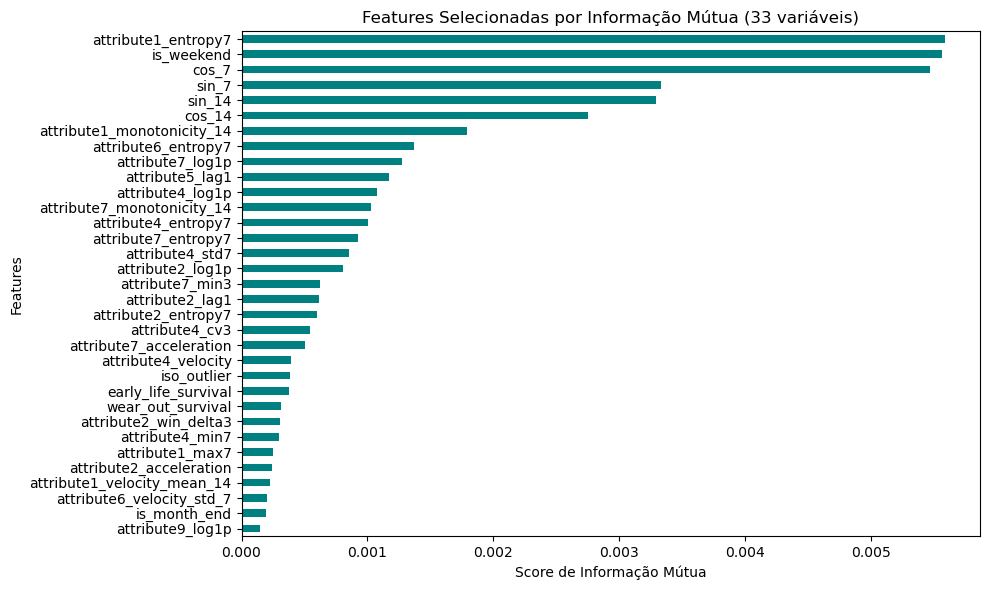

Features selecionadas pela informação mútua: ['iso_outlier', 'early_life_survival', 'wear_out_survival', 'attribute2_lag1', 'attribute5_lag1', 'attribute1_max7', 'attribute2_win_delta3', 'attribute4_cv3', 'attribute4_std7', 'attribute4_min7', 'attribute7_min3', 'attribute1_entropy7', 'attribute2_entropy7', 'attribute4_entropy7', 'attribute6_entropy7', 'attribute7_entropy7', 'sin_7', 'cos_7', 'sin_14', 'cos_14', 'is_weekend', 'is_month_end', 'attribute1_velocity_mean_14', 'attribute1_monotonicity_14', 'attribute2_acceleration', 'attribute4_velocity', 'attribute6_velocity_std_7', 'attribute7_acceleration', 'attribute7_monotonicity_14', 'attribute2_log1p', 'attribute4_log1p', 'attribute7_log1p', 'attribute9_log1p']
Quantidade de variáveis restantes: 33


In [35]:
feature_selected_mi = mutual_information_selection(train_df_reduced_, target="failure", percentile=50)
print("Features selecionadas pela informação mútua:", feature_selected_mi)
print("Quantidade de variáveis restantes:", len(feature_selected_mi))

#### Boruta

O usuário pode escolher utilizar como estimadores o ExtraTrees ou Random Forest (está sendo considerado o ExtraTrees por questão de tempo de processamento). Antes de aplicar o método do Boruta, o método faz imputação dos valores NaN por -9999. 

In [36]:
def _ensure_numpy_compat_aliases():
    if not hasattr(np, "int"):   np.int = int         
    if not hasattr(np, "bool"):  np.bool = bool
    if not hasattr(np, "float"): np.float = float

def run_boruta(
    df: pd.DataFrame,
    target: str = "failure",
    exclude: Sequence[str] = ("date", "device"),
    estimator_type: Literal["extratrees","rf"] = "extratrees",
    max_iter: int = 50,
    max_depth: Optional[int] = 8,
    class_weight: Optional[str] = "balanced",
    random_state: int = 42,
    perc: int = 85,
    two_step: bool = True,
) -> Dict[str, object]:

    _ensure_numpy_compat_aliases()

    base_cols = [c for c in exclude if c in df.columns]
    X = (df.drop(columns=[*base_cols, target], errors="ignore")
           .select_dtypes(include=[np.number])
           .replace([np.inf, -np.inf], np.nan))
    y = df[target].astype(int).values

    # imputação dos valores NaN por -9999
    for c in X.columns:
        if X[c].isna().any():
            X[c] = X[c].fillna(-9999)  

    X = X.astype(np.float32)

    if estimator_type == "extratrees":
        est = ExtraTreesClassifier(
            n_estimators=1000,              
            max_depth=max_depth,
            max_features="sqrt",
            bootstrap=False,
            n_jobs=-1,
            class_weight=class_weight,
            random_state=random_state,
        )
    else:
        est = RandomForestClassifier(
            n_estimators=1000,
            max_depth=max_depth,
            max_features="sqrt",
            bootstrap=False,
            n_jobs=-1,
            class_weight=class_weight,
            random_state=random_state,
        )


    boruta = BorutaPy(
        estimator=est,
        n_estimators="auto",
        max_iter=max_iter,
        alpha=0.05,
        perc=perc,
        two_step=two_step,
        random_state=random_state,
        verbose=0,
    )
    boruta.fit(X.values, y)

    support_strong = boruta.support_.astype(bool)
    support_weak   = boruta.support_weak_.astype(bool)
    ranking        = boruta.ranking_

    features = np.array(X.columns)
    confirmed = features[support_strong].tolist()
    tentative = features[support_weak].tolist()
    rejected  = features[~(support_strong | support_weak)].tolist()


    imp_mean = getattr(boruta, "feature_importances_", None)
    if (imp_mean is None) or (len(imp_mean) != X.shape[1]):
        imp_mean = np.full(X.shape[1], np.nan)

    report = (
        pd.DataFrame({
            "feature": features,
            "selected": support_strong,
            "tentative": support_weak,
            "rank": ranking,
            "importance_mean": imp_mean,
        })
        .sort_values(["selected", "tentative", "rank", "importance_mean"],
                     ascending=[False, False, True, False])
        .reset_index(drop=True)
    )

    return {
        "confirmed": confirmed,
        "tentative": tentative,
        "rejected": rejected,
        "report": report,
        "support_mask": support_strong,
        "tentative_mask": support_weak,
    }


In [37]:
columns_for_boruta = feature_selected_mi + ["failure"]
df_boruta = train_df_reduced_[columns_for_boruta].copy()

res = run_boruta(
    df_boruta,
    target="failure",
    estimator_type="extratrees",
    max_iter=100,
    max_depth=8,
    perc=85,
    class_weight="balanced",
    random_state=42,
)

print("Confirmadas:", len(res["confirmed"]))
print("Tentativas:", len(res["tentative"]))
print(res["report"].head())

U:\Users\0339867\AppData\Local\Temp\ipykernel_16680\2008285083.py:3: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "bool"):  np.bool = bool


Confirmadas: 19
Tentativas: 3
               feature  selected  tentative  rank  importance_mean
0          iso_outlier      True      False     1              NaN
1  early_life_survival      True      False     1              NaN
2    wear_out_survival      True      False     1              NaN
3      attribute2_lag1      True      False     1              NaN
4       attribute4_cv3      True      False     1              NaN


### Modelos

In [38]:
model_features = list(dict.fromkeys(res['confirmed'] + ['failure'])) 
required_cols = ['date', 'device']
missing_cols = [col for col in required_cols if col not in train_df_.columns]


train_df_model = train_df_[model_features + ['date', 'device']]  
train_df_model['date'] = pd.to_datetime(train_df_model['date'], errors='coerce')
print(train_df_model.shape)

(99906, 22)


U:\Users\0339867\AppData\Local\Temp\ipykernel_16680\368640356.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_model['date'] = pd.to_datetime(train_df_model['date'], errors='coerce')


#### Baseline

Naive - Assumindo a classe majoritária

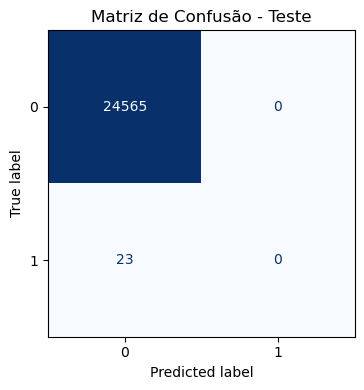

accuracy        0.999065
recall               0.0
precision            0.0
f1                   0.0
auc                  0.5
logloss         0.032308
kappa                0.0
mcc                  0.0
auprc           0.000935
custom_score    0.425748
dtype: object

In [39]:
# probabilidade 0 para todos (baseline trivial)
y_prob_baseline = np.zeros(len(test_df), dtype=float)

metrics_baseline_naive = evaluate_on_test(
    predictor_or_proba=y_prob_baseline,
    test_df=test_df,
    target_col="failure",
    weights=None,
    threshold=0.5,      
    plot_cm=True
)

pd.Series(metrics_baseline_naive).drop("confusion_matrix")

In [40]:
class WrapperBaseline:

    def __init__(self, model, feature_columns, imputer):
        self.model = model
        self.feature_columns = feature_columns
        self.imputer = imputer
    
    def predict_proba(self, X):

        X_features = X[self.feature_columns]
        
        X_features = X_features.select_dtypes(exclude=["datetime"])
        
        X_imputed = self.imputer.transform(X_features)
        
        return self.model.predict_proba(X_imputed)
    
    def predict(self, X):
        return self.model.predict(self.predict_proba(X)[:, 1] >= 0.5)

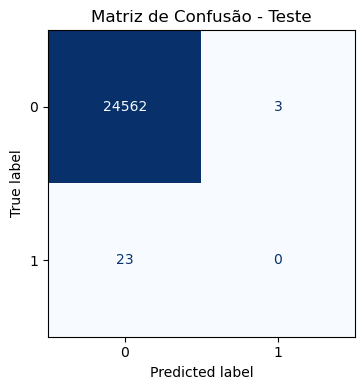

Métricas de desempenho: {'accuracy': 0.9989425736131446, 'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'auc': 0.8000681421959486, 'logloss': 0.016378935347222005, 'kappa': -0.00021591175780333316, 'mcc': -0.0003380111719483856, 'auprc': 0.012966289756258442, 'custom_score': 0.435289477888292, 'confusion_matrix': array([[24562,     3],
       [   23,     0]], dtype=int64)}


accuracy        0.998943
recall               0.0
precision            0.0
f1                   0.0
auc             0.800068
logloss         0.016379
kappa          -0.000216
mcc            -0.000338
auprc           0.012966
custom_score    0.435289
dtype: object

In [41]:
X_train_baseline = train_df_model.drop(columns=["failure", "date", "device"])
y_train_baseline = train_df_model["failure"] 

X_test_baseline = test_df_.drop(columns=["failure", "date", "device"])
y_test_baseline = test_df_["failure"]

X_train_clean = X_train_baseline.select_dtypes(exclude=["datetime"])
X_test_clean = X_test_baseline.select_dtypes(exclude=["datetime"])

X_test_clean = X_test_clean[X_train_clean.columns]

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_clean)
X_test_imputed = imputer.transform(X_test_clean)

rf_model = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
rf_model.fit(X_train_imputed, y_train_baseline)


model_baseline_rf = WrapperBaseline(rf_model, X_train_clean.columns.tolist(), imputer)


metrics_baseline_rf = evaluate_on_test(
    predictor_or_proba=model_baseline_rf,  
    test_df=test_df_,  
    target_col="failure",  
    weights={"recall": 0.35, "mcc": 0.35, "auprc": 0.20, "kappa": 0.10},
    threshold=0.5,  
    plot_cm=True  
)

print("Métricas de desempenho:", metrics_baseline_rf)
pd.Series(metrics_baseline_rf).drop("confusion_matrix")

#### LightGBM + Previsão Conforme

- Divisão temporal por grupos
    - Agrupa os dados do mesmo dispositivo (evitando que vazem no treino/teste). Os dispositivos são ordenados pela primeira data de operação, e é feito um split temporal:
        - Treino: dispositivos mais antigos
        - Teste: dispositivos mais recentes

- Calibração conforme
    - Separa os scores preditos entre positivos e negativos no conjunto de calibração
    - Calcula p-valores para cada classe:

        - p1 = probabilidade condicional de ser positivo dado o score

        - p0 = probabilidade condicional de ser negativo

        - Normaliza as probabilidades: P(classe=1) = p1 / (p1 + p0)




- Tratamento para os dados desbalanceados
    - Ajusta o parâmetro *scale_pos_weight* do LightGBM para lidar com classes raras
    - Calcula a razão negativos/positivos
    - Aplica limites:
        if proporção_positivos < 0.001:    # <0.1%
            peso_máximo = 10.0
        elif proporção_positivos < 0.01:   # <1%  
            peso_máximo = 20.0
        else:
            peso_máximo = 30.0

- Otimização com pesos ordenados
    - Prioridade: Recall > Kappa > AUPRC > MCC

        - Recall (máxima prioridade): Captura todas as falhas reais - custo de falso negativo é alto
        - Kappa: Concordância ajustada para desbalanceamento
        - AUPRC: Performance geral em ranking de probabilidades
        - MCC: Correlação Matthews, é uma métrica robusta para classes raras

    - Geração de pesos:

        z = [w_z1, w_z2, w_z3, w_z4]  # Optuna sugere valores
        q = exp(z) / sum(exp(z))       # transformação softmax
        
    - Atribuição hierárquica:
        - w_recall = sum(q)              # Peso máximo (soma total)
        - w_kappa = sum(q[1:])           # Segundo maior  
        - w_auprc = sum(q[2:])           # Terceiro maior
        - w_mcc = q[3]                   # Menor peso

- Geração de thresholds candidatos
    - Fonte 1: pontos da curva Precision-Recall
    - Fonte 2: quantis de probabilidade
    - Filtros aplicados:
        - Mínimo: 0.02
        - Máximo: 0.99
        - Máximo de candidatos: 200 por fold

    - Processo de seleção:
        - Para cada threshold candidato:
            1. Calcula métricas (recall, kappa, auprc, mcc)
            2. Aplica penalizações (recall baixo é penalizado)
            3. Combina métricas com pesos hierárquicos
            4. Seleciona threshold que maximiza score combinado

- Estimativa de threshold ótimo:

    - Para cada fold de CV:
        1. Treina modelo com melhores hiperparâmetros
        2. Aplica calibração conforme
        3. Gera thresholds candidatos da PR-curve
        4. Avalia cada threshold com métrica combinada
        5. Seleciona melhor threshold do fold

    - Agregação final:
        - best_threshold = median(fold_thresholds)  

- Holdout final
    - É executado como a última avaliação
    - Usa o split temporal mais recente que nunca foi visto durante todo o processo de otimização
    - Após treinar o modelo final nos dados históricos (splits 1-5), aplicar a calibração conforme no conjunto de calibração, e otimizar o threshold com probabilidades calibradas, o modelo completo é testado uma única vez no conjunto holdout

Processo do treinamento 

- Divisão Temporal Estruturada

    - **dataset completo** *(ordenado por data e dispositivo)*
        - **CV folds** *(splits 1 a n-2)*
        - Otimização de hiperparâmetros via Optuna
        - Seleção de pesos de métricas  
        - Estimativa de threshold (mediana)
        - **calibration set** *(split n-1)*
        - Treino do ConformalCalibrator
        - Re-threshold final com probas calibradas
        - **holdout set** *(split n)*
        - Avaliação final não enviesada


    - **Validação**
        - Otimização de hiperparâmetros e pesos de métricas 
        - Nested CV com GroupTimeSeriesSplit
        - 50 trials via Optuna
        - Split interno 80/20 (treino/calibração)
        - **output**: Melhores parâmetros e threshold estimado

    - **conjunto de calibration**
        - Calibração de probabilidades e ajuste final de threshold
        - Treino da classe ConformalCalibrator
        - Re-threshold com probabilidades calibradas
        - **output**: Calibrador fitted e threshold otimizado

    - **Holdout Set**
        - Avaliação final não enviesada
        - Teste único com modelo final
        - **output**: Métrica de performance realista para produção

Exemplo de como está sendo aplicada a previsão conformem para calibrar as probabilidades do modelo

- Supondo que o LightGBM produziu as seguintes probabilidades brutas no conjunto de calibração:
    - Classe 0 (falhas=não): [0.1, 0.2, 0.3, 0.4]
    - Classe 1 (falhas=sim): [0.6, 0.7, 0.8, 0.9]

- Para um novo s=0.75
    - p-value classe 1: _p1(0.75)
        - Quantos da classe 1 têm score ≤ 0.75? -> 2 exemplos (0.6, 0.7)
            - p1 = (2 + 1) / (4 + 1) = 0.6
    
    - P-value classe 0: _p0(0.75)
        - Quantos da classe 0 têm score ≥ 0.75? -> 0 exemplos
            - p0 = (0 + 1) / (4 + 1) = 0.2

    - probabilidade calibrada
        - p_conf = 0.6 / (0.6 + 0.2) = 0.75

In [42]:
# =========================
# GroupTimeSeriesSplit, por device e data
# =========================
class GroupTimeSeriesSplitCompat:
    def __init__(self, n_splits: int = 5):
        if n_splits < 2:
            raise ValueError("n_splits deve ser >= 2")
        self.n_splits = n_splits

    def split(self, X, y=None, groups=None, dates=None):
        if groups is None:
            raise ValueError("É necessário fornecer 'groups'")
        if dates is None:
            raise ValueError("É necessário fornecer 'dates' (alinhado a X)")

        df_aux = pd.DataFrame({"group": groups, "date": pd.to_datetime(dates)})
        first_date = df_aux.groupby("group", sort=True)["date"].min()
        ordered_groups = first_date.sort_values().index.to_list()

        n_blocks = min(len(ordered_groups), self.n_splits + 1)
        if n_blocks < 2:
            raise ValueError("Poucos grupos para criar folds (>= 2 blocos)")

        blocks = np.array_split(np.array(ordered_groups, dtype=object), n_blocks)
        for i in range(n_blocks - 1):
            train_groups = set(np.concatenate(blocks[:i+1]).tolist())
            test_groups  = set(blocks[i+1].tolist())

            train_idx = np.where(np.isin(groups, list(train_groups)))[0]
            test_idx  = np.where(np.isin(groups, list(test_groups)))[0]

            train_idx = train_idx[np.argsort(pd.to_datetime(dates[train_idx]).values)]
            test_idx  = test_idx[np.argsort(pd.to_datetime(dates[test_idx]).values)]

            if len(train_idx) == 0 or len(test_idx) == 0:
                continue
            yield train_idx, test_idx


# =========================
# split-conformal, binário
# =========================
class ConformalCalibrator:
    def __init__(self):
        self.pos_scores_: Optional[np.ndarray] = None
        self.neg_scores_: Optional[np.ndarray] = None
        self.n_pos_: int = 0
        self.n_neg_: int = 0

    def fit(self, scores: np.ndarray, y_true: np.ndarray):
        scores = np.asarray(scores, dtype=float)
        y_true = np.asarray(y_true, dtype=int)
        self.pos_scores_ = np.sort(scores[y_true == 1])
        self.neg_scores_ = np.sort(scores[y_true == 0])
        self.n_pos_ = len(self.pos_scores_)
        self.n_neg_ = len(self.neg_scores_)
        return self

    def _p1(self, s: np.ndarray) -> np.ndarray:
        idx = np.searchsorted(self.pos_scores_, s, side="right")
        return (idx + 1) / (self.n_pos_ + 1 if self.n_pos_ > 0 else 1)

    def _p0(self, s: np.ndarray) -> np.ndarray:
        idx = np.searchsorted(self.neg_scores_, s, side="left")
        geq = (self.n_neg_ - idx)
        return (geq + 1) / (self.n_neg_ + 1 if self.n_neg_ > 0 else 1)

    def predict_proba(self, scores: np.ndarray) -> np.ndarray:
        s = np.asarray(scores, dtype=float)
        p1 = self._p1(s); p0 = self._p0(s)
        denom = np.where(p1 + p0 <= 0, 1.0, p1 + p0)
        p_conf = p1 / denom
        return np.vstack([1.0 - p_conf, p_conf]).T


def _ensure_sorted(df: pd.DataFrame, date_col: str = "date", group_col: str = "device") -> pd.DataFrame:
    X = df.copy()
    if date_col in X.columns and not np.issubdtype(X[date_col].dtype, np.datetime64):
        X[date_col] = pd.to_datetime(X[date_col])
    if date_col in X.columns and group_col in X.columns:
        X = X.sort_values([date_col, group_col]).reset_index(drop=True)
    elif date_col in X.columns:
        X = X.sort_values([date_col]).reset_index(drop=True)
    return X

def _prepare_xy_groups_and_dates(
    df: pd.DataFrame,
    target: str,
    drop_cols: List[str],
    group_col: str = "device",
    date_col: str = "date"
) -> Tuple[pd.DataFrame, np.ndarray, np.ndarray, np.ndarray]:
    X = (df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")
           .select_dtypes(include=[np.number])
           .replace([np.inf, -np.inf], np.nan))
    y = df[target].astype(int).values
    if group_col not in df.columns:
        raise ValueError(f"Coluna de grupo '{group_col}' não encontrada.")
    if date_col not in df.columns:
        raise ValueError(f"Coluna de data '{date_col}' não encontrada.")
    groups = df[group_col].values
    dates = pd.to_datetime(df[date_col]).values
    return X, y, groups, dates

def _scale_pos_weight_adaptive_capped(y: np.ndarray, cap_small: float = 10.0, cap_mid: float = 20.0, cap_large: float = 30.0) -> float:
    pos = int((y == 1).sum()); neg = int((y == 0).sum())
    if pos == 0:
        return 1.0
    pr = pos / (pos + neg)
    raw = neg / max(1, pos)
    if pr < 0.001:     # <0.1%
        return float(min(raw, cap_small))
    elif pr < 0.01:    # <1%
        return float(min(raw, cap_mid))
    else:
        return float(min(raw, cap_large))


# =========================
# pesos ordenados (recall > kappa > auprc > mcc)
# =========================
def ordered_weights_from_trial(trial: optuna.trial.Trial) -> Dict[str, float]:
    z = np.array([
        trial.suggest_float("w_z1", 1e-3, 5.0, log=True),
        trial.suggest_float("w_z2", 1e-3, 5.0, log=True),
        trial.suggest_float("w_z3", 1e-3, 5.0, log=True),
        trial.suggest_float("w_z4", 1e-3, 5.0, log=True),
    ], dtype=float)
    q = np.exp(z) / np.exp(z).sum()
    w_rec   = q.sum()
    w_mcc   = q[1:].sum()
    w_auprc = q[2:].sum()
    w_kappa = q[3]
    w_raw = np.array([w_rec, w_kappa, w_auprc, w_mcc], dtype=float)
    w = w_raw / w_raw.sum()
    return {"recall": float(w[0]), "kappa": float(w[1]), "auprc": float(w[2]), "mcc": float(w[3])}


# =========================
# thresholds candidatos a partir da PR-curve
# =========================
def _candidate_thresholds_from_pr(y_true_fold: np.ndarray, y_prob_fold: np.ndarray,
                                  n_keep: int = 200, min_thr: float = 0.02, max_thr: float = 0.99) -> np.ndarray:
    precision, recall, thr = precision_recall_curve(y_true_fold, y_prob_fold)
    thr = np.asarray(thr, dtype=float)

    qs = np.quantile(y_prob_fold, q=np.linspace(0.50, 0.999, 25))
    cand = np.unique(np.concatenate([thr, qs]))

    cand = cand[np.isfinite(cand)]
    cand = cand[(cand >= min_thr) & (cand <= max_thr)]
    if cand.size == 0:
        cand = np.linspace(0.05, 0.60, 40)

    if cand.size > n_keep:
        idx = np.linspace(0, cand.size - 1, n_keep).astype(int)
        cand = cand[idx]

    return np.unique(np.clip(cand, min_thr, max_thr))


# =========================
# tuning com calibração dentro do CV
# =========================
def optimize_lgbm_params_and_weights(
    df: pd.DataFrame,
    target: str = "failure",
    exclude: List[str] = ["date", "device"],
    group_col: str = "device",
    date_col: str = "date",
    n_trials: int = 50,
    n_splits_total: int = 6,
    random_state: int = 42,
    rec_thresh: float = 0.20,
    rec_penalty_power: float = 1.2,
    mcc_alpha: float = 2.0,

) -> Tuple[Dict, Dict, float, float, Tuple[int, np.ndarray, np.ndarray, np.ndarray]]:
    df = _ensure_sorted(df, date_col=date_col, group_col=group_col)

    X_all, y_all, groups_all, dates_all = _prepare_xy_groups_and_dates(
        df, target=target, drop_cols=exclude + [target], group_col=group_col, date_col=date_col
    )

    gtscv_all = GroupTimeSeriesSplitCompat(n_splits=n_splits_total)
    folds = list(gtscv_all.split(X_all, y_all, groups=groups_all, dates=dates_all))
    if len(folds) < 3:
        raise ValueError("n_splits_total deve ser >= 3.")

    cv_folds = folds[:-2]
    cal_tr_idx, cal_idx = folds[-2]
    hold_tr_idx, hold_idx = folds[-1]

    cv_last_index = cal_tr_idx[-1]
    mask_cv = np.arange(len(X_all)) <= cv_last_index
    X_cv = X_all.iloc[mask_cv]
    y_cv = y_all[mask_cv]
    groups_cv = groups_all[mask_cv]
    dates_cv = dates_all[mask_cv]

    n_splits_cv = max(3, len(cv_folds))
    gtscv_cv = GroupTimeSeriesSplitCompat(n_splits=n_splits_cv)

    def objective(trial: optuna.trial.Trial) -> float:
        params = {
            "objective": "binary",
            "boosting_type": "gbdt",
            "metric": "None",
            "n_estimators": trial.suggest_int("n_estimators", 300, 1200),
            "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.08, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 15, 127),
            "max_depth": trial.suggest_int("max_depth", -1, 10),
            "min_child_samples": trial.suggest_int("min_child_samples", 100, 800),
            "min_child_weight": trial.suggest_float("min_child_weight", 1e-3, 10.0, log=True),
            "subsample": trial.suggest_float("subsample", 0.7, 0.95),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 0.95),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 30.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 30.0, log=True),
            "n_jobs": -1,
            "random_state": random_state,
            "verbosity": -1,
        }

        w = ordered_weights_from_trial(trial)
        fold_scores = []

        for tr_idx, va_idx in gtscv_cv.split(X_cv, y_cv, groups=groups_cv, dates=dates_cv):

            tr_order = tr_idx[np.argsort(dates_cv[tr_idx])]
            cut = int(0.8 * len(tr_order))
            if cut <= 0 or cut >= len(tr_order):
                continue
            tr_sub, cal_sub = tr_order[:cut], tr_order[cut:]

            spw = _scale_pos_weight_adaptive_capped(y_cv[tr_sub])
            clf = LGBMClassifier(**params, scale_pos_weight=spw)
            clf.fit(
                X_cv.iloc[tr_sub], y_cv[tr_sub],
                eval_set=[(X_cv.iloc[cal_sub], y_cv[cal_sub])],
                eval_metric="logloss",
                callbacks=[early_stopping(200), log_evaluation(0)]
            )

            # calibra no cal_sub
            cal_scores = clf.predict_proba(X_cv.iloc[cal_sub])[:, 1]
            calib = ConformalCalibrator().fit(cal_scores, y_cv[cal_sub])

            # probas calibradas na validação
            y_prob_val = calib.predict_proba(clf.predict_proba(X_cv.iloc[va_idx])[:, 1])[:, 1]

            # thresholds candidatos e score
            thr_candidates = _candidate_thresholds_from_pr(y_cv[va_idx], y_prob_val)
            best_fold = -np.inf
            for thr in thr_candidates:
                s = combined_metric_with_penalties(
                    y_cv[va_idx], y_prob_val, w,
                    threshold=thr, rec_thresh=rec_thresh,
                    rec_penalty_power=rec_penalty_power, mcc_alpha=mcc_alpha
                )
                if s > best_fold:
                    best_fold = s

            fold_scores.append(best_fold)

        return float(np.mean(fold_scores))

    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=random_state))
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_trial.params.copy()
    weight_keys = [k for k in list(best_params.keys()) if k.startswith("w_z")]
    zvals = [best_params.pop(k) for k in weight_keys]

    class DummyTrial:
        def __init__(self, z): self._z = z; self._i = -1
        def suggest_float(self, *args, **kwargs):
            self._i += 1
            return float(self._z[self._i])
    best_weights = ordered_weights_from_trial(DummyTrial(zvals))

    # estima threshold pela mediana 
    gtscv_cv = GroupTimeSeriesSplitCompat(n_splits=max(3, len(cv_folds)))
    best_thr_list = []
    for tr_idx, va_idx in gtscv_cv.split(X_cv, y_cv, groups=groups_cv, dates=dates_cv):
        tr_order = tr_idx[np.argsort(dates_cv[tr_idx])]
        cut = int(0.8 * len(tr_order))
        if cut <= 0 or cut >= len(tr_order):
            continue
        tr_sub, cal_sub = tr_order[:cut], tr_order[cut:]

        spw = _scale_pos_weight_adaptive_capped(y_cv[tr_sub])
        clf = LGBMClassifier(**best_params, scale_pos_weight=spw)
        clf.fit(
            X_cv.iloc[tr_sub], y_cv[tr_sub],
            eval_set=[(X_cv.iloc[cal_sub], y_cv[cal_sub])],
            eval_metric="logloss",
            callbacks=[early_stopping(200), log_evaluation(0)]
        )

        cal_scores = clf.predict_proba(X_cv.iloc[cal_sub])[:, 1]
        calib = ConformalCalibrator().fit(cal_scores, y_cv[cal_sub])
        y_prob_val = calib.predict_proba(clf.predict_proba(X_cv.iloc[va_idx])[:, 1])[:, 1]

        thr_candidates = _candidate_thresholds_from_pr(y_cv[va_idx], y_prob_val)
        scores = [combined_metric_with_penalties(
            y_cv[va_idx], y_prob_val, best_weights, t,
            rec_thresh=rec_thresh, rec_penalty_power=rec_penalty_power,
            mcc_alpha=mcc_alpha
        ) for t in thr_candidates]
        best_thr_list.append(float(thr_candidates[int(np.argmax(scores))]))

    best_thr = float(np.median(best_thr_list))

    cv_scores = []
    for tr_idx, va_idx in gtscv_cv.split(X_cv, y_cv, groups=groups_cv, dates=dates_cv):
        tr_order = tr_idx[np.argsort(dates_cv[tr_idx])]
        cut = int(0.8 * len(tr_order))
        if cut <= 0 or cut >= len(tr_order):
            continue
        tr_sub, cal_sub = tr_order[:cut], tr_order[cut:]

        spw = _scale_pos_weight_adaptive_capped(y_cv[tr_sub])
        clf = LGBMClassifier(**best_params, scale_pos_weight=spw)
        clf.fit(X_cv.iloc[tr_sub], y_cv[tr_sub], eval_set=[(X_cv.iloc[cal_sub], y_cv[cal_sub])],
                eval_metric="logloss", callbacks=[early_stopping(200), log_evaluation(0)])

        cal_scores = clf.predict_proba(X_cv.iloc[cal_sub])[:, 1]
        calib = ConformalCalibrator().fit(cal_scores, y_cv[cal_sub])
        y_prob_val = calib.predict_proba(clf.predict_proba(X_cv.iloc[va_idx])[:, 1])[:, 1]

        cv_scores.append(combined_metric_with_penalties(
            y_cv[va_idx], y_prob_val, best_weights, threshold=best_thr,
            rec_thresh=rec_thresh, rec_penalty_power=rec_penalty_power,
            mcc_alpha=mcc_alpha
        ))

    best_cv_score = float(np.mean(cv_scores))
    return best_params, best_weights, best_cv_score, best_thr, (cv_last_index, cal_idx, hold_idx, groups_all)


# =========================
# preditor
# =========================
class LGBMConformalPredictor:
    def __init__(self, model: LGBMClassifier, calibrator: ConformalCalibrator, selected_features: List[str]):
        self.model = model
        self.calibrator = calibrator
        self.selected_features = selected_features

    def predict_proba(self, df: pd.DataFrame) -> np.ndarray:
        X = (df[self.selected_features]
             .select_dtypes(include=[np.number])
             .replace([np.inf, -np.inf], np.nan))
        raw = self.model.predict_proba(X)[:, 1]
        return self.calibrator.predict_proba(raw)

    def predict(self, df: pd.DataFrame, threshold: float = 0.5) -> np.ndarray:
        proba = self.predict_proba(df)[:, 1]
        return (proba >= threshold).astype(int)


# =========================
# treino final + calibração + re-threshold + holdout
# =========================
def lgbm_conformal(
    df: pd.DataFrame,
    target: str = "failure",
    exclude: List[str] = ["date", "device"],
    group_col: str = "device",
    date_col: str = "date",
    use_features: Optional[List[str]] = None,
    n_trials: int = 50,
    n_splits_total: int = 6,
    random_state: int = 42,
    rec_thresh: float = 0.20,
    rec_penalty_power: float = 1.2,
    mcc_alpha: float = 2.0
) -> Dict[str, object]:
    df = _ensure_sorted(df, date_col=date_col, group_col=group_col)

    if use_features is not None:
        cols = [c for c in use_features if c not in [target]]
        data = df[[*cols, target, group_col, date_col]].copy()
    else:
        cols = [c for c in df.columns if c not in [target]]
        data = df[[*cols, target, group_col, date_col]].copy()

    best_params, best_weights, best_cv_score, best_thr_cv, idx_info = optimize_lgbm_params_and_weights(
        data, target=target, exclude=[group_col, date_col], group_col=group_col, date_col=date_col,
        n_trials=n_trials, n_splits_total=n_splits_total, random_state=random_state,
        rec_thresh=rec_thresh, rec_penalty_power=rec_penalty_power, mcc_alpha=mcc_alpha
    )
    cv_last_index, cal_idx, hold_idx, groups_all = idx_info

    X_all, y_all, groups_all, dates_all = _prepare_xy_groups_and_dates(
        data, target=target, drop_cols=[target, group_col, date_col],
        group_col=group_col, date_col=date_col
    )
    gtscv_all = GroupTimeSeriesSplitCompat(n_splits=n_splits_total)
    folds = list(gtscv_all.split(X_all, y_all, groups=groups_all, dates=dates_all))
    tr_cal_idx, cal_idx = folds[-2]
    tr_hold_idx, hold_idx = folds[-1]

    X_tr, y_tr = X_all.iloc[tr_cal_idx], y_all[tr_cal_idx]
    X_cal, y_cal = X_all.iloc[cal_idx], y_all[cal_idx]
    X_hold, y_hold = X_all.iloc[hold_idx], y_all[hold_idx]

    spw = _scale_pos_weight_adaptive_capped(y_tr)
    final_params = dict(best_params)
    final_params.setdefault("verbosity", -1)

    clf = LGBMClassifier(**final_params, objective="binary", n_jobs=-1,
                         random_state=random_state, scale_pos_weight=spw)
    clf.fit(
        X_tr, y_tr,
        eval_set=[(X_cal, y_cal)],
        eval_metric="logloss",
        callbacks=[early_stopping(200), log_evaluation(0)]
    )

    # calibração no cal-set
    cal_scores = clf.predict_proba(X_cal)[:, 1]
    conformal = ConformalCalibrator().fit(cal_scores, y_cal)
    predictor = LGBMConformalPredictor(clf, conformal, list(X_tr.columns))

    # === re-threshold no cal-set com probas ===
    proba_cal = predictor.predict_proba(pd.DataFrame(X_cal, columns=X_tr.columns))[:, 1]
    thr_candidates = _candidate_thresholds_from_pr(y_cal, proba_cal)
    scores = [combined_metric_with_penalties(
        y_true=y_cal, 
        y_prob=proba_cal, 
        w=best_weights,
        threshold=t, 
        rec_thresh=rec_thresh, 
        rec_penalty_power=rec_penalty_power,
        mcc_alpha=mcc_alpha
    ) for t in thr_candidates]
    best_thr_final = float(thr_candidates[int(np.argmax(scores))])

    # holdout
    hold_df = pd.DataFrame(X_hold, columns=X_tr.columns)
    hold_proba = predictor.predict_proba(hold_df)[:, 1]
    hold_score = combined_metric_with_penalties(
        y_true=y_hold, y_prob=hold_proba, w=best_weights,
        threshold=best_thr_final, rec_thresh=rec_thresh,
        rec_penalty_power=rec_penalty_power, mcc_alpha=mcc_alpha
    )

    return {
        "predictor": predictor,
        "best_params": best_params,
        "best_weights": best_weights,
        "best_threshold_cv": best_thr_cv,
        "best_threshold": best_thr_final,
        "cv_score": best_cv_score,
        "holdout_score": float(hold_score),
        "used_features": list(X_tr.columns),
    }



In [63]:
model_features = list(dict.fromkeys(res['confirmed'] + ['failure']))  

required_cols = ['date', 'device']
missing_cols = [col for col in required_cols if col not in train_df_.columns]

if missing_cols:
    raise KeyError(f"As colunas {missing_cols} não foram encontradas no DataFrame!")

train_df_model = train_df_[model_features + ['date', 'device']]

train_df_model['date'] = pd.to_datetime(train_df_model['date'], errors='coerce')


result_lgbm_cp = lgbm_conformal(
    df=train_df_model,
    target="failure",
    exclude=["device"],  
    group_col="device", 
    date_col="date",
    use_features=model_features,
    n_trials=50,
    n_splits_total=6,
    random_state=42
)

predictor = result_lgbm_cp["predictor"]
print(f"Melhores parâmetros encontrados: {result_lgbm_cp['best_params']}")
print(f"Melhores pesos: {result_lgbm_cp['best_weights']}")
print(f"Melhor threshold: {result_lgbm_cp['best_threshold']}")
print(f"CV score: {result_lgbm_cp['cv_score']}")
print(f"Holdout score: {result_lgbm_cp['holdout_score']}")

U:\Users\0339867\AppData\Local\Temp\ipykernel_16680\930783752.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_model['date'] = pd.to_datetime(train_df_model['date'], errors='coerce')
[I 2025-08-11 11:18:53,761] A new study created in memory with name: no-name-d9263cf4-bddd-4891-884d-320ca286a4d0


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.00954223
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.00837626
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.00937211
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.00778907


[I 2025-08-11 11:19:02,559] Trial 0 finished with value: 0.7342749945112835 and parameters: {'n_estimators': 637, 'learning_rate': 0.06978211022792681, 'num_leaves': 97, 'max_depth': 6, 'min_child_samples': 209, 'min_child_weight': 0.004207053950287938, 'subsample': 0.7145209030420498, 'colsample_bytree': 0.9165440364437337, 'reg_alpha': 3.083434817935579, 'reg_lambda': 5.675206026988748, 'w_z1': 0.0011916299962955155, 'w_z2': 3.8696122574142664, 'w_z3': 1.1999975480350795, 'w_z4': 0.00610149136730271}. Best is trial 0 with value: 0.7342749945112835.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.00954803
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.00846808
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.00952553
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.00761587


[I 2025-08-11 11:19:12,543] Trial 1 finished with value: 0.7369485992813883 and parameters: {'n_estimators': 463, 'learning_rate': 0.008314019514903102, 'num_leaves': 49, 'max_depth': 5, 'min_child_samples': 402, 'min_child_weight': 0.014618962793704957, 'subsample': 0.8529632236805949, 'colsample_bytree': 0.7348734651630104, 'reg_alpha': 0.5292705365436974, 'reg_lambda': 0.8082071885709252, 'w_z1': 0.04863951003835899, 'w_z2': 0.8023102291340046, 'w_z3': 0.005477562363971304, 'w_z4': 0.07982478599323917}. Best is trial 1 with value: 0.7369485992813883.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0119135
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[114]	valid_0's binary_logloss: 0.00965836
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[107]	valid_0's binary_logloss: 0.00998528
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.00758273


[I 2025-08-11 11:19:18,710] Trial 2 finished with value: 0.7323720654126855 and parameters: {'n_estimators': 833, 'learning_rate': 0.0056872441740860695, 'num_leaves': 83, 'max_depth': 1, 'min_child_samples': 145, 'min_child_weight': 6.245139574743075, 'subsample': 0.9414080082686398, 'colsample_bytree': 0.9020993370291153, 'reg_alpha': 0.5682837558512266, 'reg_lambda': 0.17456037635797406, 'w_z1': 0.33959199243313637, 'w_z2': 0.042472797953697176, 'w_z3': 0.002827585657311758, 'w_z4': 0.06786479434196534}. Best is trial 1 with value: 0.7369485992813883.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[275]	valid_0's binary_logloss: 0.00963124
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[127]	valid_0's binary_logloss: 0.00833922
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.00919049
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.00743531


[I 2025-08-11 11:19:26,909] Trial 3 finished with value: 0.8088606487027825 and parameters: {'n_estimators': 330, 'learning_rate': 0.0622158259663901, 'num_leaves': 44, 'max_depth': 6, 'min_child_samples': 318, 'min_child_weight': 0.12030178871154672, 'subsample': 0.8366775698358199, 'colsample_bytree': 0.7462136138813817, 'reg_alpha': 25.221951700214287, 'reg_lambda': 8.319514671870786, 'w_z1': 2.9866092370009407, 'w_z2': 2.0414536703077757, 'w_z3': 0.16278488880914346, 'w_z4': 2.570307853015558}. Best is trial 3 with value: 0.8088606487027825.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.0096303
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.00885161
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.00941241
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.00737197


[I 2025-08-11 11:19:33,660] Trial 4 finished with value: 0.7763014286095844 and parameters: {'n_estimators': 379, 'learning_rate': 0.008609082809111277, 'num_leaves': 20, 'max_depth': 2, 'min_child_samples': 372, 'min_child_weight': 0.01217295809836997, 'subsample': 0.9071843772879823, 'colsample_bytree': 0.7891883316733973, 'reg_alpha': 0.49648810171066565, 'reg_lambda': 2.2096526145513846, 'w_z1': 0.0033210428646429763, 'w_z2': 0.9274757630456326, 'w_z3': 0.0018869508789698256, 'w_z4': 4.4716229470373845}. Best is trial 3 with value: 0.8088606487027825.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[113]	valid_0's binary_logloss: 0.00953261
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.00876066
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.00946726
Training until validation scores don't improve for 200 rounds


[I 2025-08-11 11:19:43,499] Trial 5 finished with value: 0.8043519469927602 and parameters: {'n_estimators': 995, 'learning_rate': 0.008674561439130764, 'num_leaves': 15, 'max_depth': 8, 'min_child_samples': 595, 'min_child_weight': 0.8241925264876453, 'subsample': 0.8928175866714864, 'colsample_bytree': 0.7185111629335226, 'reg_alpha': 0.772614892774646, 'reg_lambda': 0.1936518766909303, 'w_z1': 1.5580940996926465, 'w_z2': 0.20209756220944194, 'w_z3': 0.016748729494641602, 'w_z4': 0.0017183057019185925}. Best is trial 3 with value: 0.8088606487027825.


Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.00784451
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[183]	valid_0's binary_logloss: 0.00906355
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.00848178
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.00939386
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.00739447


[I 2025-08-11 11:19:53,524] Trial 6 finished with value: 0.7486317046177415 and parameters: {'n_estimators': 580, 'learning_rate': 0.012317703342786175, 'num_leaves': 97, 'max_depth': 6, 'min_child_samples': 721, 'min_child_weight': 0.0774211647399625, 'subsample': 0.7298985614845754, 'colsample_bytree': 0.8783111968057487, 'reg_alpha': 7.665788170871725, 'reg_lambda': 2.4566974547738343, 'w_z1': 0.7108606477829392, 'w_z2': 0.06707104906311694, 'w_z3': 0.08581694621646047, 'w_z4': 0.03814708899459646}. Best is trial 3 with value: 0.8088606487027825.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[306]	valid_0's binary_logloss: 0.00957837
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[156]	valid_0's binary_logloss: 0.00831533
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[141]	valid_0's binary_logloss: 0.00921009
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.00754369


[I 2025-08-11 11:20:04,507] Trial 7 finished with value: 0.7224010620966137 and parameters: {'n_estimators': 322, 'learning_rate': 0.00674348238712931, 'num_leaves': 18, 'max_depth': 6, 'min_child_samples': 320, 'min_child_weight': 0.1082138291061399, 'subsample': 0.9268916184815232, 'colsample_bytree': 0.7623230572872187, 'reg_alpha': 1.0388868790048469, 'reg_lambda': 7.440322909623881, 'w_z1': 0.007019683821378796, 'w_z2': 0.0019263995910971143, 'w_z3': 0.011797281245016885, 'w_z4': 0.003947777846526162}. Best is trial 3 with value: 0.8088606487027825.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[185]	valid_0's binary_logloss: 0.00931249
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.00862302
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.00914041
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.00752711


[I 2025-08-11 11:20:13,724] Trial 8 finished with value: 0.7192190514916168 and parameters: {'n_estimators': 1137, 'learning_rate': 0.046994161144587716, 'num_leaves': 86, 'max_depth': 9, 'min_child_samples': 663, 'min_child_weight': 0.005575453980775369, 'subsample': 0.9231397496224945, 'colsample_bytree': 0.8348355604789126, 'reg_alpha': 10.002928632464418, 'reg_lambda': 16.585432655261954, 'w_z1': 0.015006703959278904, 'w_z2': 0.0025531643266569876, 'w_z3': 0.0069682757636133075, 'w_z4': 0.038006589374604244}. Best is trial 3 with value: 0.8088606487027825.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[140]	valid_0's binary_logloss: 0.00940682
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.0085698
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.00984475
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.0162615


[I 2025-08-11 11:20:23,910] Trial 9 finished with value: 0.7752965805147163 and parameters: {'n_estimators': 1037, 'learning_rate': 0.054374202381620954, 'num_leaves': 15, 'max_depth': 5, 'min_child_samples': 392, 'min_child_weight': 0.007734482156646798, 'subsample': 0.7299663418334207, 'colsample_bytree': 0.7844037928509069, 'reg_alpha': 21.662155489352177, 'reg_lambda': 0.6318483453139458, 'w_z1': 0.08298334718019176, 'w_z2': 0.3985162559069982, 'w_z3': 0.02213374957157973, 'w_z4': 3.9318122798867297}. Best is trial 3 with value: 0.8088606487027825.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[252]	valid_0's binary_logloss: 0.00984298
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[142]	valid_0's binary_logloss: 0.00836131
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.00913208
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.00755839


[I 2025-08-11 11:20:34,066] Trial 10 finished with value: 0.9074472914877934 and parameters: {'n_estimators': 762, 'learning_rate': 0.024255026353522967, 'num_leaves': 124, 'max_depth': -1, 'min_child_samples': 548, 'min_child_weight': 0.3123568055954923, 'subsample': 0.7910368997290436, 'colsample_bytree': 0.7030900761849588, 'reg_alpha': 0.17386150126223418, 'reg_lambda': 28.72120461620912, 'w_z1': 4.686154710033679, 'w_z2': 3.1515324555187614, 'w_z3': 0.3964867393590531, 'w_z4': 0.6631966251835083}. Best is trial 10 with value: 0.9074472914877934.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 0.0097252
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	valid_0's binary_logloss: 0.00846195
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.00912882
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.00751335


[I 2025-08-11 11:20:44,270] Trial 11 finished with value: 0.823956445925591 and parameters: {'n_estimators': 804, 'learning_rate': 0.0286476664213759, 'num_leaves': 126, 'max_depth': -1, 'min_child_samples': 514, 'min_child_weight': 0.3832002315345672, 'subsample': 0.794253344753347, 'colsample_bytree': 0.7017327975405206, 'reg_alpha': 0.12190192346945562, 'reg_lambda': 23.51426854869911, 'w_z1': 4.650455640790112, 'w_z2': 4.750672619040374, 'w_z3': 0.40124181370507356, 'w_z4': 0.4301149460892572}. Best is trial 10 with value: 0.9074472914877934.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[189]	valid_0's binary_logloss: 0.00971649
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.00846256
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.00912223
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.00751452


[I 2025-08-11 11:20:55,508] Trial 12 finished with value: 0.8170487277006265 and parameters: {'n_estimators': 830, 'learning_rate': 0.02662886625616187, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 546, 'min_child_weight': 0.7414865158519757, 'subsample': 0.7847681022786518, 'colsample_bytree': 0.7046271177288836, 'reg_alpha': 0.10778297218068943, 'reg_lambda': 24.61836147383407, 'w_z1': 4.624667660859257, 'w_z2': 4.8332244907036195, 'w_z3': 0.772095961204881, 'w_z4': 0.518646857033131}. Best is trial 10 with value: 0.9074472914877934.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[211]	valid_0's binary_logloss: 0.00981914
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.0083968
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.00912691
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.00752128


[I 2025-08-11 11:21:16,761] Trial 13 finished with value: 0.5483922452951806 and parameters: {'n_estimators': 714, 'learning_rate': 0.024529193833134934, 'num_leaves': 121, 'max_depth': -1, 'min_child_samples': 514, 'min_child_weight': 0.5581130785886022, 'subsample': 0.7845773071142217, 'colsample_bytree': 0.7020375487596545, 'reg_alpha': 0.12599855515769293, 'reg_lambda': 26.678164787053735, 'w_z1': 0.3022222044448308, 'w_z2': 0.007315690704025994, 'w_z3': 3.708650748531264, 'w_z4': 0.6301942453408513}. Best is trial 10 with value: 0.9074472914877934.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0119135
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[93]	valid_0's binary_logloss: 0.00885086
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.00948331
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.0074779


[I 2025-08-11 11:21:26,413] Trial 14 finished with value: 0.7539227486814545 and parameters: {'n_estimators': 902, 'learning_rate': 0.016723474335123136, 'num_leaves': 109, 'max_depth': 2, 'min_child_samples': 779, 'min_child_weight': 4.137196784976968, 'subsample': 0.7865808832678609, 'colsample_bytree': 0.8329130452644911, 'reg_alpha': 0.22666045425001172, 'reg_lambda': 11.34819194820227, 'w_z1': 1.182940998543493, 'w_z2': 0.2050104377378874, 'w_z3': 0.3888637261937466, 'w_z4': 0.5963125369772483}. Best is trial 10 with value: 0.9074472914877934.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[430]	valid_0's binary_logloss: 0.0097368
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.00928183
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.00990357


[I 2025-08-11 11:21:32,552] Trial 15 finished with value: 0.6594805371406334 and parameters: {'n_estimators': 662, 'learning_rate': 0.03605616771045177, 'num_leaves': 113, 'max_depth': 1, 'min_child_samples': 485, 'min_child_weight': 0.0010783237953053135, 'subsample': 0.8085949155966438, 'colsample_bytree': 0.7940894939603609, 'reg_alpha': 0.19995680713121725, 'reg_lambda': 4.6040215567902285, 'w_z1': 4.039948147466189, 'w_z2': 1.7274655192779216, 'w_z3': 3.9613257087160214, 'w_z4': 0.21636007417424571}. Best is trial 10 with value: 0.9074472914877934.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.00766182
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[356]	valid_0's binary_logloss: 0.00937203
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.00835861
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[98]	valid_0's binary_logloss: 0.00920409
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.00750028


[I 2025-08-11 11:21:43,402] Trial 16 finished with value: 0.7389830083057016 and parameters: {'n_estimators': 552, 'learning_rate': 0.016490776046736554, 'num_leaves': 65, 'max_depth': 0, 'min_child_samples': 646, 'min_child_weight': 0.2867728511609562, 'subsample': 0.7560197837188772, 'colsample_bytree': 0.7484106984905686, 'reg_alpha': 0.23162436623875304, 'reg_lambda': 16.963241183760342, 'w_z1': 0.2829594301249425, 'w_z2': 0.017803724629267322, 'w_z3': 0.26191923939720474, 'w_z4': 1.159780174308958}. Best is trial 10 with value: 0.9074472914877934.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[243]	valid_0's binary_logloss: 0.00937542
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[153]	valid_0's binary_logloss: 0.00860711
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.00934167
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.00752246


[I 2025-08-11 11:21:53,115] Trial 17 finished with value: 0.7244330146663341 and parameters: {'n_estimators': 767, 'learning_rate': 0.029646168915010467, 'num_leaves': 108, 'max_depth': 3, 'min_child_samples': 572, 'min_child_weight': 2.117490514830426, 'subsample': 0.8796848833230622, 'colsample_bytree': 0.7713802308978477, 'reg_alpha': 1.8176480517044433, 'reg_lambda': 29.168799930740303, 'w_z1': 0.044936849795395285, 'w_z2': 0.4969352608806288, 'w_z3': 0.0408197720554552, 'w_z4': 0.20190439298117616}. Best is trial 10 with value: 0.9074472914877934.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.00948245
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.00845178
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.00930578
Training until validation scores don't improve for 200 rounds


[I 2025-08-11 11:22:02,034] Trial 18 finished with value: 0.7493439318157222 and parameters: {'n_estimators': 929, 'learning_rate': 0.038472722725740406, 'num_leaves': 125, 'max_depth': -1, 'min_child_samples': 484, 'min_child_weight': 0.044023928649436335, 'subsample': 0.8199011307447623, 'colsample_bytree': 0.9409763552832888, 'reg_alpha': 0.28460992149998976, 'reg_lambda': 3.802301213807763, 'w_z1': 1.5365638143052618, 'w_z2': 4.704026220757574, 'w_z3': 1.0328125852453562, 'w_z4': 0.2115641935183423}. Best is trial 10 with value: 0.9074472914877934.


Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.00757472
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.00907423
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.00875627
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.00928431
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.00758775


[I 2025-08-11 11:22:09,650] Trial 19 finished with value: 0.752270542842715 and parameters: {'n_estimators': 1133, 'learning_rate': 0.022081816518164946, 'num_leaves': 72, 'max_depth': 3, 'min_child_samples': 628, 'min_child_weight': 0.2765481340312422, 'subsample': 0.759427050353531, 'colsample_bytree': 0.809649665618208, 'reg_alpha': 1.5663442641350973, 'reg_lambda': 1.3283519256618341, 'w_z1': 0.11336218368992626, 'w_z2': 0.1976087937248859, 'w_z3': 0.10394173112347098, 'w_z4': 1.3899129687941658}. Best is trial 10 with value: 0.9074472914877934.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[308]	valid_0's binary_logloss: 0.00921871
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[143]	valid_0's binary_logloss: 0.00845901
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[93]	valid_0's binary_logloss: 0.00923903
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.00745614


[I 2025-08-11 11:22:20,416] Trial 20 finished with value: 0.7373351765968301 and parameters: {'n_estimators': 792, 'learning_rate': 0.012823481394926745, 'num_leaves': 100, 'max_depth': 0, 'min_child_samples': 702, 'min_child_weight': 1.9679139615664798, 'subsample': 0.8644266393999371, 'colsample_bytree': 0.8606595240183935, 'reg_alpha': 0.36497978212111437, 'reg_lambda': 13.745583391195684, 'w_z1': 0.8847680845666079, 'w_z2': 1.7263928257423315, 'w_z3': 0.5041162998545826, 'w_z4': 0.023130641465884984}. Best is trial 10 with value: 0.9074472914877934.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[210]	valid_0's binary_logloss: 0.00984454
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[107]	valid_0's binary_logloss: 0.00839633
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.00917065
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.00751439


[I 2025-08-11 11:22:30,833] Trial 21 finished with value: 0.882040386074604 and parameters: {'n_estimators': 862, 'learning_rate': 0.027926512865088564, 'num_leaves': 122, 'max_depth': -1, 'min_child_samples': 545, 'min_child_weight': 0.846333815006137, 'subsample': 0.794094050425565, 'colsample_bytree': 0.7038426533178123, 'reg_alpha': 0.10350466425373078, 'reg_lambda': 27.379524065405523, 'w_z1': 4.913418641901284, 'w_z2': 3.8422313226370006, 'w_z3': 1.1117587944441003, 'w_z4': 0.39014607078745417}. Best is trial 10 with value: 0.9074472914877934.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.0094523
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.00830862
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.00922124
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.00751439


[I 2025-08-11 11:22:41,048] Trial 22 finished with value: 0.7485344078811746 and parameters: {'n_estimators': 950, 'learning_rate': 0.03530040103044139, 'num_leaves': 117, 'max_depth': 0, 'min_child_samples': 452, 'min_child_weight': 0.297123690582086, 'subsample': 0.8023686710933, 'colsample_bytree': 0.7269605810429582, 'reg_alpha': 0.10044346316764426, 'reg_lambda': 11.598605464331136, 'w_z1': 2.4123563135055246, 'w_z2': 2.268505450029516, 'w_z3': 1.5407502192686056, 'w_z4': 0.33191032084566957}. Best is trial 10 with value: 0.9074472914877934.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[848]	valid_0's binary_logloss: 0.0097161
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.0097927
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.0100081
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.00764345


[I 2025-08-11 11:22:47,046] Trial 23 finished with value: 0.8624341369821784 and parameters: {'n_estimators': 874, 'learning_rate': 0.017865246520170245, 'num_leaves': 107, 'max_depth': 1, 'min_child_samples': 535, 'min_child_weight': 1.6082128722505953, 'subsample': 0.7594315899621891, 'colsample_bytree': 0.7189411163314005, 'reg_alpha': 0.170855110251019, 'reg_lambda': 20.309257593348125, 'w_z1': 4.1619152327937385, 'w_z2': 0.900951000280186, 'w_z3': 1.8558699370368457, 'w_z4': 1.648585869178457}. Best is trial 10 with value: 0.9074472914877934.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.00974805
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.00935902
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.00981396
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.0074735


[I 2025-08-11 11:22:52,485] Trial 24 finished with value: 0.6592018585900756 and parameters: {'n_estimators': 1067, 'learning_rate': 0.017098636160118242, 'num_leaves': 104, 'max_depth': 1, 'min_child_samples': 574, 'min_child_weight': 1.7703555608560744, 'subsample': 0.7626122983484671, 'colsample_bytree': 0.7246697922027285, 'reg_alpha': 0.20273846814535712, 'reg_lambda': 0.10316242754312102, 'w_z1': 0.6180723467352933, 'w_z2': 0.5730289401042539, 'w_z3': 2.2651717374813454, 'w_z4': 1.7215090842262024}. Best is trial 10 with value: 0.9074472914877934.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[261]	valid_0's binary_logloss: 0.00939855
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[98]	valid_0's binary_logloss: 0.00852538
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.0093364
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.00745783


[I 2025-08-11 11:23:02,214] Trial 25 finished with value: 0.6911056920622486 and parameters: {'n_estimators': 864, 'learning_rate': 0.013081519315223566, 'num_leaves': 90, 'max_depth': 3, 'min_child_samples': 426, 'min_child_weight': 1.1668729865720646, 'subsample': 0.8331557946707638, 'colsample_bytree': 0.7555252279904473, 'reg_alpha': 0.1620120619910934, 'reg_lambda': 8.711243006570594, 'w_z1': 2.083712809251513, 'w_z2': 1.1060599910835895, 'w_z3': 2.078675954882398, 'w_z4': 0.7988987899235881}. Best is trial 10 with value: 0.9074472914877934.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0119135
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[132]	valid_0's binary_logloss: 0.00835457
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.00922199
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.00752641


[I 2025-08-11 11:23:11,363] Trial 26 finished with value: 0.7509760486038759 and parameters: {'n_estimators': 720, 'learning_rate': 0.020334416507450527, 'num_leaves': 115, 'max_depth': 0, 'min_child_samples': 606, 'min_child_weight': 3.625776006122516, 'subsample': 0.768213121001776, 'colsample_bytree': 0.7219369615529495, 'reg_alpha': 0.3471353543771561, 'reg_lambda': 17.73243103271693, 'w_z1': 0.1660361585380142, 'w_z2': 0.32226086833713025, 'w_z3': 0.598056115774776, 'w_z4': 2.434270713640851}. Best is trial 10 with value: 0.9074472914877934.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0119135
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.00916734
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.00985024


[I 2025-08-11 11:23:18,405] Trial 27 finished with value: 0.8352392087160908 and parameters: {'n_estimators': 684, 'learning_rate': 0.04604794915339929, 'num_leaves': 75, 'max_depth': 2, 'min_child_samples': 800, 'min_child_weight': 9.672513551381966, 'subsample': 0.7402335150296125, 'colsample_bytree': 0.741546796182303, 'reg_alpha': 0.15362450977672343, 'reg_lambda': 3.284903579369147, 'w_z1': 2.520034072421639, 'w_z2': 1.522038522607341, 'w_z3': 0.14786759976324454, 'w_z4': 0.10459433306825439}. Best is trial 10 with value: 0.9074472914877934.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.00808992
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[978]	valid_0's binary_logloss: 0.00977365
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.0093811
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.00983878


[I 2025-08-11 11:23:24,479] Trial 28 finished with value: 0.7477418441020265 and parameters: {'n_estimators': 978, 'learning_rate': 0.01990396161862544, 'num_leaves': 115, 'max_depth': 1, 'min_child_samples': 694, 'min_child_weight': 0.040030019695835806, 'subsample': 0.811650958308096, 'colsample_bytree': 0.7714549159474484, 'reg_alpha': 3.6975365527095887, 'reg_lambda': 5.987567813447188, 'w_z1': 0.42889768740819595, 'w_z2': 2.9139059941358885, 'w_z3': 0.23782209907063287, 'w_z4': 1.095706987723786}. Best is trial 10 with value: 0.9074472914877934.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.00754445
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[107]	valid_0's binary_logloss: 0.0094692
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.0082786
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.00912971
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.00747234


[I 2025-08-11 11:23:33,780] Trial 29 finished with value: 0.6530671644414217 and parameters: {'n_estimators': 573, 'learning_rate': 0.032457520238475056, 'num_leaves': 102, 'max_depth': 4, 'min_child_samples': 252, 'min_child_weight': 0.1918721978109385, 'subsample': 0.702778068469315, 'colsample_bytree': 0.7167010323928349, 'reg_alpha': 0.34435102386209093, 'reg_lambda': 18.945995896275175, 'w_z1': 0.0010124266071124199, 'w_z2': 0.13018151871500586, 'w_z3': 1.1534041604728837, 'w_z4': 0.1507723930020207}. Best is trial 10 with value: 0.9074472914877934.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.00962155
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.00830572
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.00914259
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.00746485


[I 2025-08-11 11:23:44,029] Trial 30 finished with value: 0.7189470265378064 and parameters: {'n_estimators': 869, 'learning_rate': 0.014807882172266909, 'num_leaves': 93, 'max_depth': -1, 'min_child_samples': 520, 'min_child_weight': 1.1727885470630284, 'subsample': 0.7773822659366817, 'colsample_bytree': 0.7006086647065924, 'reg_alpha': 0.859139607840304, 'reg_lambda': 10.505373238302179, 'w_z1': 4.974708486817728, 'w_z2': 2.8886828361457964, 'w_z3': 4.341195374856491, 'w_z4': 0.01327567669497484}. Best is trial 10 with value: 0.9074472914877934.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0119135
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[98]	valid_0's binary_logloss: 0.00877809
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[214]	valid_0's binary_logloss: 0.00974409
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.0079357


[I 2025-08-11 11:23:53,162] Trial 31 finished with value: 0.8335182742535296 and parameters: {'n_estimators': 651, 'learning_rate': 0.042467543970515144, 'num_leaves': 61, 'max_depth': 2, 'min_child_samples': 790, 'min_child_weight': 8.458917221694245, 'subsample': 0.7382389532566568, 'colsample_bytree': 0.7335942143893783, 'reg_alpha': 0.16675627048287803, 'reg_lambda': 29.04065692376169, 'w_z1': 2.3749201146368213, 'w_z2': 1.2366391098943474, 'w_z3': 0.1539334724367671, 'w_z4': 0.07941975475034975}. Best is trial 10 with value: 0.9074472914877934.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.00929773
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.00882827
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.00965881
Training until validation scores don't improve for 200 rounds


[I 2025-08-11 11:24:02,751] Trial 32 finished with value: 0.7739906390380203 and parameters: {'n_estimators': 757, 'learning_rate': 0.047530682223487136, 'num_leaves': 79, 'max_depth': 0, 'min_child_samples': 459, 'min_child_weight': 3.520895636035656, 'subsample': 0.7494954564499847, 'colsample_bytree': 0.7416453981044822, 'reg_alpha': 0.14986458375783443, 'reg_lambda': 0.46217635340073904, 'w_z1': 1.2016431846748994, 'w_z2': 0.7337501676489205, 'w_z3': 0.05380889449315841, 'w_z4': 0.1317619052482185}. Best is trial 10 with value: 0.9074472914877934.


Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.00791424
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0119135
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[227]	valid_0's binary_logloss: 0.00951288
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[386]	valid_0's binary_logloss: 0.00974899


[I 2025-08-11 11:24:10,571] Trial 33 finished with value: 0.8394791231276352 and parameters: {'n_estimators': 705, 'learning_rate': 0.06784066618729012, 'num_leaves': 50, 'max_depth': 1, 'min_child_samples': 107, 'min_child_weight': 6.443407910451974, 'subsample': 0.7120689529097688, 'colsample_bytree': 0.7345306751692884, 'reg_alpha': 0.48568506971337394, 'reg_lambda': 3.3680523041083914, 'w_z1': 2.8665314047172896, 'w_z2': 1.2712597636883947, 'w_z3': 0.7326632897598395, 'w_z4': 0.33223202016582026}. Best is trial 10 with value: 0.9074472914877934.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.00774042
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.00997202
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[236]	valid_0's binary_logloss: 0.0092389
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[333]	valid_0's binary_logloss: 0.00965889


[I 2025-08-11 11:24:18,734] Trial 34 finished with value: 0.7287564004828113 and parameters: {'n_estimators': 463, 'learning_rate': 0.07884758629869894, 'num_leaves': 42, 'max_depth': 1, 'min_child_samples': 103, 'min_child_weight': 5.580584197388385, 'subsample': 0.7122235205336387, 'colsample_bytree': 0.713490410835057, 'reg_alpha': 0.4950118913054014, 'reg_lambda': 5.9130289589177645, 'w_z1': 2.5693628712733423, 'w_z2': 2.7776563151861824, 'w_z3': 2.1219825937897876, 'w_z4': 0.36183493406932193}. Best is trial 10 with value: 0.9074472914877934.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.00781442
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.0095414
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.00861987
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.0093886
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.00758582


[I 2025-08-11 11:24:29,509] Trial 35 finished with value: 0.7187058610703351 and parameters: {'n_estimators': 875, 'learning_rate': 0.010334323493736263, 'num_leaves': 34, 'max_depth': 0, 'min_child_samples': 227, 'min_child_weight': 2.340254312518386, 'subsample': 0.8427391784473742, 'colsample_bytree': 0.7597302847997955, 'reg_alpha': 0.2752318690438014, 'reg_lambda': 1.4766059475325097, 'w_z1': 0.0275928404293774, 'w_z2': 0.8419085640770871, 'w_z3': 0.7591198489113274, 'w_z4': 0.7954594761106805}. Best is trial 10 with value: 0.9074472914877934.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.0096812
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.0084688
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.0100142
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.0205965


[I 2025-08-11 11:24:38,525] Trial 36 finished with value: 0.750174171403308 and parameters: {'n_estimators': 710, 'learning_rate': 0.05940729796407711, 'num_leaves': 52, 'max_depth': 4, 'min_child_samples': 174, 'min_child_weight': 0.5485430868300056, 'subsample': 0.7169630658088931, 'colsample_bytree': 0.737814686111594, 'reg_alpha': 0.603954298167359, 'reg_lambda': 1.0174553785077143, 'w_z1': 1.5990540874026935, 'w_z2': 2.9138169725228398, 'w_z3': 1.3939173569074972, 'w_z4': 2.2660801338997283}. Best is trial 10 with value: 0.9074472914877934.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.00910295
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.00889617
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.00943971
Training until validation scores don't improve for 200 rounds


[I 2025-08-11 11:24:48,202] Trial 37 finished with value: 0.8160844026900969 and parameters: {'n_estimators': 621, 'learning_rate': 0.02409860785248155, 'num_leaves': 31, 'max_depth': 10, 'min_child_samples': 364, 'min_child_weight': 1.184956890061535, 'subsample': 0.7739712354089885, 'colsample_bytree': 0.7140907137192923, 'reg_alpha': 0.4221973765721163, 'reg_lambda': 0.36689482319981037, 'w_z1': 3.357149181945903, 'w_z2': 0.022390711027805685, 'w_z3': 0.001036999402624461, 'w_z4': 3.636773310592551}. Best is trial 10 with value: 0.9074472914877934.


Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.00771859
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0119135
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.0085934
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.00935224
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.00764067


[I 2025-08-11 11:24:56,657] Trial 38 finished with value: 0.6057273294080692 and parameters: {'n_estimators': 800, 'learning_rate': 0.07410548888084101, 'num_leaves': 60, 'max_depth': -1, 'min_child_samples': 316, 'min_child_weight': 5.56377676709126, 'subsample': 0.7457535975024405, 'colsample_bytree': 0.7308016366810604, 'reg_alpha': 1.1987321167638008, 'reg_lambda': 14.024979592540065, 'w_z1': 0.8602971196587519, 'w_z2': 1.229217934501271, 'w_z3': 2.753602900089361, 'w_z4': 0.30918847672908323}. Best is trial 10 with value: 0.9074472914877934.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[106]	valid_0's binary_logloss: 0.00956246
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.00844173
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.00938913
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.0076506


[I 2025-08-11 11:25:06,053] Trial 39 finished with value: 0.7105881667023128 and parameters: {'n_estimators': 500, 'learning_rate': 0.011214622058474233, 'num_leaves': 119, 'max_depth': 7, 'min_child_samples': 549, 'min_child_weight': 0.20262097612776916, 'subsample': 0.7210384275847176, 'colsample_bytree': 0.9087332225432612, 'reg_alpha': 0.6866260227640338, 'reg_lambda': 1.9705126034510574, 'w_z1': 0.003275944063905805, 'w_z2': 0.29656873663789696, 'w_z3': 0.29947463858130585, 'w_z4': 0.05048661027164885}. Best is trial 10 with value: 0.9074472914877934.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[94]	valid_0's binary_logloss: 0.00923171
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.00882277
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.00938994


[I 2025-08-11 11:25:12,860] Trial 40 finished with value: 0.7098289340003482 and parameters: {'n_estimators': 1011, 'learning_rate': 0.06259184801824537, 'num_leaves': 108, 'max_depth': 2, 'min_child_samples': 344, 'min_child_weight': 0.06805555938181705, 'subsample': 0.8198186815865831, 'colsample_bytree': 0.8032534986401925, 'reg_alpha': 2.935010195209579, 'reg_lambda': 7.6302826458675685, 'w_z1': 0.5603107923327417, 'w_z2': 0.07204112924759105, 'w_z3': 0.8307806101030187, 'w_z4': 0.9648409739880376}. Best is trial 10 with value: 0.9074472914877934.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.00756782
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.00964547
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[394]	valid_0's binary_logloss: 0.00922774
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.00970518


[I 2025-08-11 11:25:20,472] Trial 41 finished with value: 0.8532283413137811 and parameters: {'n_estimators': 682, 'learning_rate': 0.04996867322496088, 'num_leaves': 76, 'max_depth': 1, 'min_child_samples': 423, 'min_child_weight': 3.716862451106208, 'subsample': 0.7374412218643785, 'colsample_bytree': 0.7437998846872681, 'reg_alpha': 0.15101258894638922, 'reg_lambda': 2.858736117293265, 'w_z1': 2.815316773529396, 'w_z2': 1.5479139840846394, 'w_z3': 0.15592032718722001, 'w_z4': 0.09784330196712367}. Best is trial 10 with value: 0.9074472914877934.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0073289
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.00996964
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.00980463
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.00977196


[I 2025-08-11 11:25:26,116] Trial 42 finished with value: 0.897416535876899 and parameters: {'n_estimators': 625, 'learning_rate': 0.05444147858979762, 'num_leaves': 83, 'max_depth': 1, 'min_child_samples': 276, 'min_child_weight': 3.5901103814874964, 'subsample': 0.7284370352295502, 'colsample_bytree': 0.7145626218182712, 'reg_alpha': 0.10005796209090612, 'reg_lambda': 2.600322292165124, 'w_z1': 3.2300427287008717, 'w_z2': 0.6830426798834017, 'w_z3': 0.22025075587740223, 'w_z4': 0.2554158132427555}. Best is trial 10 with value: 0.9074472914877934.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.00735299
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.00953289
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.00881585
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.00944401
Training until validation scores don't improve for 200 rounds


[I 2025-08-11 11:25:36,894] Trial 43 finished with value: 0.7934491437270321 and parameters: {'n_estimators': 838, 'learning_rate': 0.05205646778871823, 'num_leaves': 81, 'max_depth': 0, 'min_child_samples': 276, 'min_child_weight': 2.913943388362033, 'subsample': 0.7290544842379092, 'colsample_bytree': 0.7132766071583944, 'reg_alpha': 0.12752042259603702, 'reg_lambda': 2.687174302541751, 'w_z1': 1.6395826926309314, 'w_z2': 0.5672620039742062, 'w_z3': 0.09438923822058376, 'w_z4': 0.11570763226722583}. Best is trial 10 with value: 0.9074472914877934.


Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.00737594
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.00961705
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.00844126
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.00913735
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.00748685


[I 2025-08-11 11:25:47,388] Trial 44 finished with value: 0.960152955774312 and parameters: {'n_estimators': 592, 'learning_rate': 0.039528897897150424, 'num_leaves': 89, 'max_depth': -1, 'min_child_samples': 426, 'min_child_weight': 0.6890842604335483, 'subsample': 0.7518607973631131, 'colsample_bytree': 0.7486295133732647, 'reg_alpha': 0.10421832236773448, 'reg_lambda': 21.145687873677122, 'w_z1': 4.951112607839768, 'w_z2': 2.1303221651841704, 'w_z3': 0.03486995724638295, 'w_z4': 0.05847939578318747}. Best is trial 44 with value: 0.960152955774312.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[613]	valid_0's binary_logloss: 0.00959566
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[472]	valid_0's binary_logloss: 0.00841687
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[356]	valid_0's binary_logloss: 0.00911915
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.00752405


[I 2025-08-11 11:26:06,370] Trial 45 finished with value: 0.9325768870205788 and parameters: {'n_estimators': 613, 'learning_rate': 0.005088718966241213, 'num_leaves': 87, 'max_depth': -1, 'min_child_samples': 485, 'min_child_weight': 0.7409941415609075, 'subsample': 0.7907911139786548, 'colsample_bytree': 0.7077833397308305, 'reg_alpha': 0.10396353691649815, 'reg_lambda': 19.30747124148716, 'w_z1': 4.984265373844076, 'w_z2': 3.0907446735855046, 'w_z3': 0.021881871475668446, 'w_z4': 0.025980763609375082}. Best is trial 44 with value: 0.960152955774312.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[611]	valid_0's binary_logloss: 0.00966894
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[475]	valid_0's binary_logloss: 0.00840918
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[360]	valid_0's binary_logloss: 0.00912471
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.00754155


[I 2025-08-11 11:26:21,500] Trial 46 finished with value: 0.8904176591124551 and parameters: {'n_estimators': 611, 'learning_rate': 0.005435700546375025, 'num_leaves': 86, 'max_depth': -1, 'min_child_samples': 485, 'min_child_weight': 0.5243956396323451, 'subsample': 0.7900319690724484, 'colsample_bytree': 0.7106983661393271, 'reg_alpha': 0.10362687036298193, 'reg_lambda': 21.9597415221839, 'w_z1': 4.994475295892852, 'w_z2': 3.9599966432990317, 'w_z3': 0.02920465442399511, 'w_z4': 0.012640994398611282}. Best is trial 44 with value: 0.960152955774312.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[375]	valid_0's binary_logloss: 0.00975727
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[336]	valid_0's binary_logloss: 0.00845604
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[280]	valid_0's binary_logloss: 0.0092236
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.00761296


[I 2025-08-11 11:26:39,204] Trial 47 finished with value: 0.7564007001418266 and parameters: {'n_estimators': 375, 'learning_rate': 0.005316931619493071, 'num_leaves': 86, 'max_depth': -1, 'min_child_samples': 404, 'min_child_weight': 0.14059150859296352, 'subsample': 0.7972745868910402, 'colsample_bytree': 0.7518388257099703, 'reg_alpha': 0.10063877941487381, 'reg_lambda': 14.388928320151757, 'w_z1': 0.9647412768830872, 'w_z2': 0.0010308343681553523, 'w_z3': 0.03095699579029294, 'w_z4': 0.006880893566264869}. Best is trial 44 with value: 0.960152955774312.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[613]	valid_0's binary_logloss: 0.00959026
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[409]	valid_0's binary_logloss: 0.00843285
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[301]	valid_0's binary_logloss: 0.00915204
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.00753831


[I 2025-08-11 11:26:52,626] Trial 48 finished with value: 0.7602481682530587 and parameters: {'n_estimators': 613, 'learning_rate': 0.00661812086266076, 'num_leaves': 94, 'max_depth': -1, 'min_child_samples': 466, 'min_child_weight': 0.47036943049237623, 'subsample': 0.7817719729117985, 'colsample_bytree': 0.7737549938432593, 'reg_alpha': 0.2592781884743448, 'reg_lambda': 22.05226172964151, 'w_z1': 1.7386537683382186, 'w_z2': 3.699501673584025, 'w_z3': 0.009913484095338978, 'w_z4': 0.02261127340678593}. Best is trial 44 with value: 0.960152955774312.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[114]	valid_0's binary_logloss: 0.00974425
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.00832278
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 0.00932033
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.00758611


[I 2025-08-11 11:27:04,221] Trial 49 finished with value: 0.8786516952679766 and parameters: {'n_estimators': 520, 'learning_rate': 0.006469515255718624, 'num_leaves': 89, 'max_depth': 0, 'min_child_samples': 294, 'min_child_weight': 0.7919995721236274, 'subsample': 0.7728161153402764, 'colsample_bytree': 0.857757705374977, 'reg_alpha': 0.126299130873265, 'reg_lambda': 4.827432967021021, 'w_z1': 3.375667792281994, 'w_z2': 2.1240095069682208, 'w_z3': 0.004086403197464671, 'w_z4': 0.0010064397170702882}. Best is trial 44 with value: 0.960152955774312.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.00956469
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.00835615
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.00919411
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.00753343
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.00956469
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.00835615
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.00919411
Training until validation 

#### Avaliação no conjunto de teste

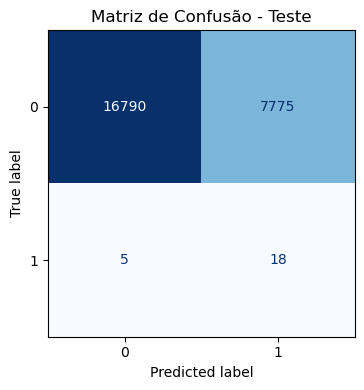

accuracy        0.683585
recall          0.782609
precision        0.00231
f1              0.004606
auc             0.834297
logloss         0.444784
kappa           0.002746
mcc             0.030624
auprc           0.016944
custom_score    0.760286
dtype: object

In [64]:
model_predictor = result_lgbm_cp["predictor"]
best_w = result_lgbm_cp["best_weights"]
thr = result_lgbm_cp["best_threshold"]


metrics_lgbm_cp = evaluate_on_test(
    predictor_or_proba=model_predictor,
    test_df=test_df,
    target_col="failure",
    weights=best_w,
    threshold=thr,
    plot_cm=True
)

pd.Series(metrics_lgbm_cp).drop("confusion_matrix")

#### Comparando resultados

In [65]:
def summary_metrics(model_name, metrics_dict):
    metrics_dict['model'] = model_name
    return pd.Series(metrics_dict)

metrics_baseline_naive_series = summary_metrics("Baseline Naive", metrics_baseline_naive)
metrics_baseline_rf_series = summary_metrics("RandomForest", metrics_baseline_rf)
metrics_lgbm_cp_series = summary_metrics("LGBM + Conformal", metrics_lgbm_cp)

metrics_df = pd.DataFrame([metrics_baseline_naive_series, 
                           metrics_baseline_rf_series, 
                           metrics_lgbm_cp_series])
metrics_df

,accuracy,recall,precision,f1,auc,logloss,kappa,mcc,auprc,custom_score,confusion_matrix,model
0,0.999065,0.000000,0.00000,0.000000,0.500000,0.032308,0.000000,0.000000,0.000935,0.425748,"[[24565, 0], [23, 0]]",Baseline Naive
1,0.998943,0.000000,0.00000,0.000000,0.800068,0.016379,-0.000216,-0.000338,0.012966,0.435289,"[[24562, 3], [23, 0]]",RandomForest
2,0.683585,0.782609,0.00231,0.004606,0.834297,0.444784,0.002746,0.030624,0.016944,0.760286,"[[16790, 7775], [5, 18]]",LGBM + Conformal


#### Avaliando a separação das classes previstas pelo modelo LGBM conforme

U:\Users\0339867\AppData\Local\Temp\ipykernel_16680\3355625477.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_prob_lgbm[test_df['failure'] == 1], color='red', label='Predito (Classe 1 - Com Falha)', shade=True)
U:\Users\0339867\AppData\Local\Temp\ipykernel_16680\3355625477.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_prob_lgbm[test_df['failure'] == 0], color='blue', label='Predito (Classe 0 - Sem Falha)', shade=True)
U:\Users\0339867\AppData\Local\Temp\ipykernel_16680\3355625477.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(test_df['failure'][test_df['failure'] == 1], color='darkred', linestyle='--', label='Real (Classe 1 - Com Falha)', a

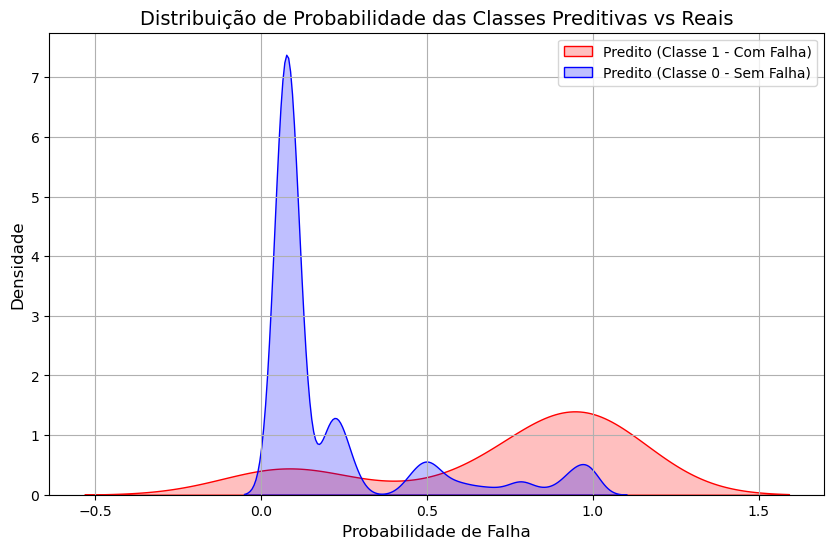

In [66]:
y_prob_lgbm = model_predictor.predict_proba(test_df[model_features])[:, 1]

plt.figure(figsize=(10, 6))

sns.kdeplot(y_prob_lgbm[test_df['failure'] == 1], color='red', label='Predito (Classe 1 - Com Falha)', shade=True)
sns.kdeplot(y_prob_lgbm[test_df['failure'] == 0], color='blue', label='Predito (Classe 0 - Sem Falha)', shade=True)

sns.kdeplot(test_df['failure'][test_df['failure'] == 1], color='darkred', linestyle='--', label='Real (Classe 1 - Com Falha)', alpha=0.5)
sns.kdeplot(test_df['failure'][test_df['failure'] == 0], color='darkblue', linestyle='--', label='Real (Classe 0 - Sem Falha)', alpha=0.5)

plt.title('Distribuição de Probabilidade das Classes Preditivas vs Reais', fontsize=14)
plt.xlabel('Probabilidade de Falha', fontsize=12)
plt.ylabel('Densidade', fontsize=12)
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

- Existe uma separação visível entre as distribuições, indicando que o modelo aprendeu padrões distintos para cada classe

- A classe 0 (sem falha) concentra-se próxima a 0, enquanto a classe 1 (com falha) distribui-se em probabilidades mais altas

- Porém há uma zona de sobreposição, o que demonstra o porque do excesso de falsos positivos (o modelo tem dificuldade de classificação nessa região)

#### Avaliando curva ROC

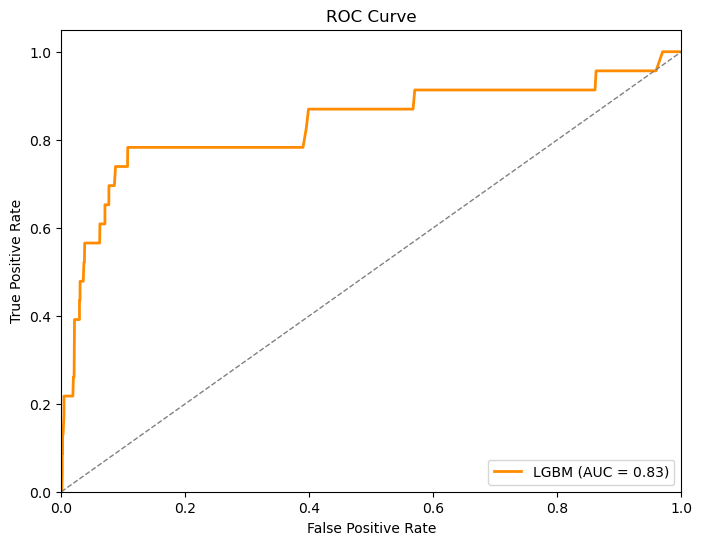

In [67]:
fpr, tpr, _ = roc_curve(test_df['failure'], y_prob_lgbm)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'LGBM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

#### Feature importance

- Shape values

u:\Users\0339867\AppData\Local\anaconda3\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


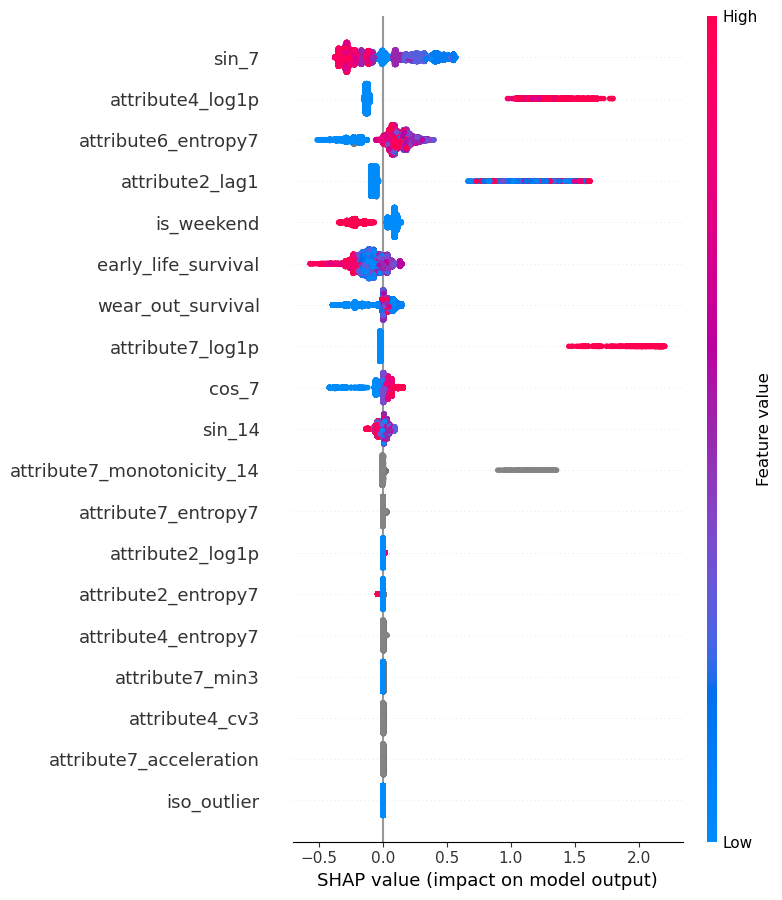

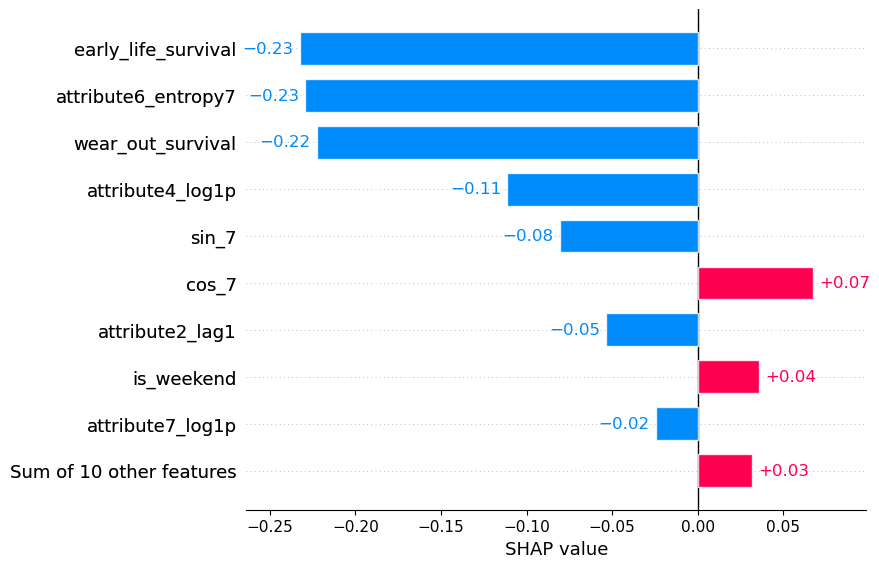

In [68]:
explainer = shap.TreeExplainer(model_predictor.model) 
 
shap_values = explainer.shap_values(test_df[model_features].drop(['failure'], axis=1))

shap.summary_plot(shap_values, test_df[model_features].drop(['failure'], axis=1))

explanation = shap.Explanation(values=shap_values[0], base_values=explainer.expected_value)
feature_names = test_df[model_features].drop(['failure'], axis=1).columns
explanation.feature_names = feature_names

shap.plots.bar(explanation)

- Principais indicadores de falha

    - early_life_survival: dispositivos em início de vida operacional aparentemente apresentam maior risco de falha (pode ser algum indício de problemas de instalação?)

    - attribute6_entropy7: alta entropia na janela de 7 dias do attribute6 sugere instabilidade operacional

    - wear_out_survival: dispositivos próximos ao fim da vida útil devem mostrar sinais de desgastes

    - attribute4_log1p: valores elevados do log do attribute4 indicam condições anômalas 

- Fatores protetivos

    - cos_7: pode indicar que padrões cíclicos estáveis protegem contra falhas

    - is_weekend: pode indicar uma menor carga operacional aos finais de semana 

#### Recomendações

- Intensificar testes em equipamentos novos para detectar falhas precocesso e instalação

- Programar manutenções durante períodos de menor risco (finais de semana)

- Criar alertas quando a entropia de 7 dias do atributo6 aumentar significativamente (por exemplo, entropy7 do attribute6 > percentil 90 histórico)

### Próximos passos para evolução do modelo

- Reformulação da métrica: A métrica atual utilizada favorece muitos falsos positivos. A mudança na forma de calibrar os pesos (substituindo os pesos fixos) e a inclusão de outras métricas que priorizem o equilíbrio entre precision-recall (como por exemplo F1 ou F-beta). Também poderia ser uma opção testar a inclusão da métrica precision, com uma penalização similar a que foi construída para o recall.

- O threshold atual é otimizado de forma global, porém uma abordagem que considere padrões sazonais e histórico de falhas individuais de cada dispositivo, podem ser mais eficiente.

- Analisar se a classe de falha pode ser subdividida em tipos específicos de falha

- Adicionar variáveis no feature engineering que ajudem a melhor separar a zona de sobreposição entre as classes, por exemplo:
    - Taxa de variação da entropia nos últimos 7 dias
    - "derivada" do wear_out_survival (aceleração do desgaste)
    - Combinações das principais features:
        - attribute6_entropy7 × wear_out_survival
        - early_life_survival / wear_out_survival
        - attribute4_log1p × attribute6_entropy7
        

